# Projet Knapsack Problem 0-1

**Équipe:** Chaabane, Arman, Bartosz, Ahmed

## Structure du projet

1. Infrastructure commune (Classes et structures de données)
2. Algorithmes implémentés
3. Système de benchmarking complet
4. Analyse comparative approfondie

---
## 1. Configuration et Imports

In [20]:
import time
import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from pathlib import Path
from collections import defaultdict
from types import SimpleNamespace

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

ALGO_COLORS = {
    'Brute Force': '#e41a1c',
    'Dynamic Programming': '#377eb8',
    'DP Top-Down': '#4daf4a',
    'Branch and Bound': '#984ea3',
    'Greedy Ratio': '#ff7f00', 
    'Greedy Value': '#ffff33', 
    'Greedy Weight': '#a65628', 
    'Fractional Knapsack': '#f781bf',
    'Randomized': '#999999', 
    'Genetic Algorithm': '#17becf',  
    'Genetic Adaptive': '#1f77b4',      
    'Simulated Annealing': '#d62728',   
    'SA Adaptive': '#ff9896',          
    'FTPAS (ε=0.1)': '#9467bd',         
    'FTPAS (ε=0.05)': '#8c564b',        
    'FTPAS Adaptive': '#e377c2',        
}

## Générateur de Benchmarks Knapsack

Ce générateur permet de créer des fichiers de benchmark personnalisés avec différents paramètres :
- **Type de corrélation** : uncorrelated, weakly_correlated, strongly_correlated, similar_weights
- **Nombre d'items (n)** : nombre d'objets dans l'instance
- **Plage des poids (R)** : valeur maximale pour les poids générés aléatoirement
- **Capacité** : peut être spécifiée ou calculée automatiquement (généralement 50% de la somme des poids)

In [21]:
import numpy as np
import os
from typing import Literal, Optional, Tuple, List
from dataclasses import dataclass

GENERATED_DIR = "benchmarks/generated"

@dataclass
class KnapsackInstance:
    n: int
    capacity: int
    weights: List[int]
    values: List[int]
    correlation_type: str
    
    def __str__(self):
        return f"KnapsackInstance(n={self.n}, capacity={self.capacity}, type={self.correlation_type})"


class KnapsackBenchmarkGenerator:
    CORRELATION_TYPES = [
        'uncorrelated',
        'weakly_correlated', 
        'strongly_correlated',
        'similar_weights',
        'inverse_strongly_correlated'
    ]
    
    def __init__(self):
        self.rng = np.random.default_rng()
    
    def generate(self, n: int, R: int = 1000, capacity: Optional[int] = None,
                 capacity_ratio: float = 0.5, correlation_type: str = 'uncorrelated',
                 correlation_param: float = 100.0) -> KnapsackInstance:
        if correlation_type not in self.CORRELATION_TYPES:
            raise ValueError(f"Type inconnu: {correlation_type}. Choix: {self.CORRELATION_TYPES}")
        
        weights = self._generate_weights(n, R, correlation_type, correlation_param)
        values = self._generate_values(weights, R, correlation_type, correlation_param)
        
        if capacity is None:
            capacity = int(capacity_ratio * sum(weights))
        capacity = max(1, capacity)
        
        return KnapsackInstance(n=n, capacity=capacity, weights=weights.tolist(), 
                                values=values.tolist(), correlation_type=correlation_type)
    
    def _generate_weights(self, n: int, R: int, correlation_type: str, correlation_param: float) -> np.ndarray:
        if correlation_type == 'similar_weights':
            weights = self.rng.normal(R / 2, correlation_param, n)
            weights = np.clip(weights, 1, R).astype(int)
        else:
            weights = self.rng.integers(1, R + 1, n)
        return weights.astype(int)
    
    def _generate_values(self, weights: np.ndarray, R: int, correlation_type: str, correlation_param: float) -> np.ndarray:
        n = len(weights)
        if correlation_type == 'uncorrelated':
            values = self.rng.integers(1, R + 1, n)
        elif correlation_type == 'weakly_correlated':
            noise = self.rng.integers(-int(correlation_param), int(correlation_param) + 1, n)
            values = np.maximum(weights + noise, 1)
        elif correlation_type == 'strongly_correlated':
            values = weights + int(correlation_param)
        elif correlation_type == 'similar_weights':
            values = self.rng.integers(1, R + 1, n)
        elif correlation_type == 'inverse_strongly_correlated':
            values = np.maximum(weights.max() - weights + int(correlation_param), 1)
        return values.astype(int)
    
    def _build_filename(self, instance: KnapsackInstance, index: int = None, format: str = 'standard') -> str:
        ext = '.kp' if format == 'kp' else '.txt'
        base = f"{instance.correlation_type}_n{instance.n}_c{instance.capacity}"
        if index is not None:
            return f"{base}_{index:03d}{ext}"
        return f"{base}{ext}"
    
    def save_to_file(self, instance: KnapsackInstance, filepath: str = None,
                     index: int = None, format: Literal['standard', 'kp'] = 'standard') -> str:
        if filepath is None:
            filepath = os.path.join(GENERATED_DIR, self._build_filename(instance, index, format))
        
        os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)
        with open(filepath, 'w') as f:
            if format == 'standard':
                f.write(f"{instance.n} {instance.capacity}\n")
                for v, w in zip(instance.values, instance.weights):
                    f.write(f"{v} {w}\n")
            elif format == 'kp':
                f.write(f"\n{instance.n}\n{instance.capacity}\n\n")
                for v, w in zip(instance.values, instance.weights):
                    f.write(f"{v} {w}\n")
        return filepath


def generate_benchmarks(n: int, capacity: int = None, correlation = 'uncorrelated',
                        R: int = 1000, count: int = 1, format: str = 'standard') -> List[KnapsackInstance]:
    """
    Génère un ou plusieurs fichiers de benchmark.
    
    Args:
        n: Nombre d'items
        capacity: Capacité du sac (None = 50% de la somme des poids)
        correlation: Type ou liste de types ('uncorrelated', 'weakly_correlated', 
                     'strongly_correlated', 'similar_weights', 'inverse_strongly_correlated')
        R: Poids max [1, R]
        count: Nombre de fichiers à générer par type
        format: 'standard' (.txt) ou 'kp'
    """
    generator = KnapsackBenchmarkGenerator()
    instances = []
    
    correlations = [correlation] if isinstance(correlation, str) else correlation
    
    for corr_type in correlations:
        for i in range(count):
            instance = generator.generate(n=n, R=R, capacity=capacity, correlation_type=corr_type)
            index = i + 1 if count > 1 else None
            filepath = generator.save_to_file(instance, index=index, format=format)
            instances.append(instance)
            print(f"✓ {filepath}")
    
    total = len(correlations) * count
    print(f"\n{total} fichier(s) généré(s) dans {GENERATED_DIR}/")
    return instances


print(f"Dossier: {GENERATED_DIR}")
print(f"Types: {KnapsackBenchmarkGenerator.CORRELATION_TYPES}")

Dossier: benchmarks/generated
Types: ['uncorrelated', 'weakly_correlated', 'strongly_correlated', 'similar_weights', 'inverse_strongly_correlated']


### Exemples d'utilisation du générateur

In [22]:
# =============================================================================
# GÉNÉRATION DE BENCHMARKS
# =============================================================================
# Types: 'uncorrelated', 'weakly_correlated', 'strongly_correlated', 
#        'similar_weights', 'inverse_strongly_correlated'
# =============================================================================
generate_benchmarks(n=100, capacity=2000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=500, capacity=2000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=1000, capacity=2000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=2000, capacity=2000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=3)
generate_benchmarks(n=5000, capacity=2000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=2)
generate_benchmarks(n=10000, capacity=2000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'])
generate_benchmarks(n=100, capacity=2000, correlation='similar_weights', count=3)
generate_benchmarks(n=200, capacity=2000, correlation='similar_weights', count=2)
generate_benchmarks(n=1000, capacity=2000, correlation='similar_weights', count=2)
generate_benchmarks(n=500, capacity=2000, correlation='similar_weights', count=2)







# generate_benchmarks(n=100, capacity=5000, correlation='uncorrelated')
# generate_benchmarks(n=100, capacity=5000, correlation='strongly_correlated', count=5)
# generate_benchmarks(n=100, capacity=5000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'])
# generate_benchmarks(n=100, capacity=5000, correlation=['uncorrelated', 'strongly_correlated', 'weakly_correlated'], count=5)

✓ benchmarks/generated/uncorrelated_n100_c2000_001.txt
✓ benchmarks/generated/uncorrelated_n100_c2000_002.txt
✓ benchmarks/generated/uncorrelated_n100_c2000_003.txt
✓ benchmarks/generated/strongly_correlated_n100_c2000_001.txt
✓ benchmarks/generated/strongly_correlated_n100_c2000_002.txt
✓ benchmarks/generated/strongly_correlated_n100_c2000_003.txt
✓ benchmarks/generated/weakly_correlated_n100_c2000_001.txt
✓ benchmarks/generated/weakly_correlated_n100_c2000_002.txt
✓ benchmarks/generated/weakly_correlated_n100_c2000_003.txt

9 fichier(s) généré(s) dans benchmarks/generated/
✓ benchmarks/generated/uncorrelated_n500_c2000_001.txt
✓ benchmarks/generated/uncorrelated_n500_c2000_002.txt
✓ benchmarks/generated/uncorrelated_n500_c2000_003.txt
✓ benchmarks/generated/strongly_correlated_n500_c2000_001.txt
✓ benchmarks/generated/strongly_correlated_n500_c2000_002.txt
✓ benchmarks/generated/strongly_correlated_n500_c2000_003.txt
✓ benchmarks/generated/weakly_correlated_n500_c2000_001.txt
✓ bench

[KnapsackInstance(n=500, capacity=2000, weights=[376, 668, 401, 362, 466, 565, 469, 552, 499, 384, 398, 566, 557, 668, 346, 566, 593, 396, 428, 589, 533, 342, 617, 476, 579, 378, 469, 420, 472, 505, 507, 448, 563, 648, 513, 617, 539, 489, 432, 419, 585, 569, 634, 518, 434, 484, 641, 352, 655, 492, 736, 440, 346, 542, 638, 533, 475, 577, 402, 370, 607, 821, 616, 431, 491, 551, 430, 626, 511, 695, 590, 649, 470, 514, 492, 676, 428, 535, 505, 434, 606, 392, 408, 526, 592, 628, 529, 449, 394, 597, 474, 443, 525, 521, 405, 483, 477, 531, 378, 476, 623, 581, 420, 680, 365, 475, 517, 599, 557, 570, 482, 266, 638, 649, 493, 535, 516, 655, 251, 535, 495, 555, 467, 452, 400, 348, 379, 489, 537, 560, 537, 576, 400, 531, 488, 604, 441, 414, 373, 473, 452, 483, 500, 581, 474, 483, 480, 507, 735, 629, 471, 465, 483, 486, 685, 435, 378, 591, 538, 521, 628, 483, 604, 541, 456, 453, 381, 405, 697, 641, 522, 404, 612, 527, 443, 422, 342, 543, 578, 510, 369, 615, 565, 402, 509, 568, 504, 359, 479, 404, 4

---
## 2. Structures de Données Communes

In [23]:
class Item:
    """Représente un item avec son poids et sa valeur"""
    def __init__(self, item_id, weight, value):
        self.id = item_id
        self.weight = weight
        self.value = value
    
    def ratio(self):
        return self.value / self.weight if self.weight > 0 else 0
    
    def __repr__(self):
        return f"Item({self.id}, w={self.weight}, v={self.value})"


class Problem:
    """Représente une instance du problème de knapsack"""
    def __init__(self, items, capacity):
        self.items = items
        self.capacity = capacity
        self.n = len(items)


class Solution:
    """Représente une solution au problème"""
    def __init__(self, selected_items, total_value, total_weight, time_taken):
        self.selected_items = selected_items
        self.total_value = total_value
        self.total_weight = total_weight
        self.time = time_taken
        self.usage_percent = (total_weight / 1.0) * 100  # Sera mis à jour

---
## 3. Parsing et Gestion des Benchmarks

In [24]:
# Note: La fonction parse_benchmark_file() est maintenant définie dans la section 5.1
# avec discover_benchmarks() pour supporter les deux formats de fichiers (.txt et .kp)
# Voir la cellule "Découverte automatique des benchmarks" plus bas
pass

---
## 4. Algorithmes Implémentés

### 4.1 Brute Force

In [25]:
def brute_force(problem):
    """Algorithme exhaustif O(2^n)"""
    start_time = time.time()
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for size in range(problem.n + 1):
        for combo in combinations(range(problem.n), size):
            total_weight = sum(problem.items[i].weight for i in combo)
            total_value = sum(problem.items[i].value for i in combo)
            
            if total_weight <= problem.capacity and total_value > best_value:
                best_value = total_value
                best_weight = total_weight
                best_items = list(combo)
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.2 Programmation Dynamique

In [26]:
def dynamic_programming(problem):
    """Programmation dynamique O(n x C) avec protection"""
    start_time = time.time()
    
    n = problem.n
    C = problem.capacity
    
    total_cells = n * C
    if total_cells > 10_000_000:
        print(f"DP Skip: matrice trop grande ({n}×{C:,} = {total_cells:,})")
        return None
    
    estimated_mb = (total_cells * 8) / (1024 * 1024)
    if estimated_mb > 500:
        print(f"DP Skip: mémoire > 500 MB ({estimated_mb:.0f} MB)")
        return None
    
    dp = [[0 for _ in range(C + 1)] for _ in range(n + 1)]
    
    for i in range(1, n + 1):
        item = problem.items[i - 1]
        for w in range(C + 1):
            dp[i][w] = dp[i - 1][w]
            if item.weight <= w:
                dp[i][w] = max(dp[i][w], dp[i - 1][w - item.weight] + item.value)
    
    # Reconstruction
    selected = []
    w = C
    for i in range(n, 0, -1):
        if dp[i][w] != dp[i - 1][w]:
            selected.append(i - 1)
            w -= problem.items[i - 1].weight
    
    total_value = dp[n][C]
    total_weight = sum(problem.items[i].weight for i in selected)
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.2.1 Programmation Dynamique Top-Down

In [27]:
def dynamic_programming_topdown(problem):
    """
    Programmation dynamique Top-Down avec mémoïsation
    
    Complexité temporelle: O(n × C)
    Complexité spatiale: O(n × C) pour le cache + O(n) pour la pile de récursion
    
    Avantages par rapport à Bottom-Up:
    - Ne calcule que les sous-problèmes nécessaires
    - Plus intuitif (suit la définition récursive)
    - Peut être plus rapide si tous les sous-problèmes ne sont pas nécessaires
    
    Returns:
        Solution object
    """
    import sys
    start_time = time.time()
    
    n = problem.n
    C = problem.capacity
    items = problem.items
    
    # Protection contre les grandes instances
    total_cells = n * C
    if total_cells > 10_000_000:
        print(f"DP Top-Down Skip: cache trop grand ({n}×{C:,} = {total_cells:,})")
        return None
    
    # Augmenter la limite de récursion si nécessaire
    old_limit = sys.getrecursionlimit()
    if n + 100 > old_limit:
        sys.setrecursionlimit(max(n + 100, old_limit))
    
    # Cache pour mémoïsation: memo[i][w] = valeur max avec items 0..i-1 et capacité w
    memo = {}
    
    def knapsack(i, w):
        """
        Retourne la valeur maximale possible avec les items 0..i-1 et capacité w
        """
        # Cas de base
        if i == 0 or w == 0:
            return 0
        
        # Vérifier le cache
        if (i, w) in memo:
            return memo[(i, w)]
        
        item = items[i - 1]
        
        # Si l'item est trop lourd, on ne peut pas le prendre
        if item.weight > w:
            result = knapsack(i - 1, w)
        else:
            # Max entre prendre et ne pas prendre l'item
            not_take = knapsack(i - 1, w)
            take = knapsack(i - 1, w - item.weight) + item.value
            result = max(not_take, take)
        
        memo[(i, w)] = result
        return result
    
    # Calculer la valeur optimale
    try:
        best_value = knapsack(n, C)
    except RecursionError:
        print(f"DP Top-Down Skip: récursion trop profonde (n={n})")
        sys.setrecursionlimit(old_limit)
        return None
    
    # Reconstruction de la solution
    selected = []
    w = C
    for i in range(n, 0, -1):
        if w == 0:
            break
        item = items[i - 1]
        # Si la valeur change quand on exclut cet item, c'est qu'on l'a pris
        val_with = memo.get((i, w), 0)
        val_without = memo.get((i - 1, w), 0)
        if val_with != val_without:
            selected.append(i - 1)
            w -= item.weight
    
    total_weight = sum(items[i].weight for i in selected)
    
    # Restaurer la limite de récursion
    sys.setrecursionlimit(old_limit)
    
    time_taken = time.time() - start_time
    sol = Solution(selected, best_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.3 Branch and Bound

In [28]:
def branch_and_bound(problem):
    """Branch and Bound avec élagage"""
    start_time = time.time()
    
    sorted_indices = sorted(range(problem.n), 
                          key=lambda i: problem.items[i].ratio(), 
                          reverse=True)
    
    best_value = 0
    best_solution = []
    
    def bound(level, current_weight, current_value):
        if current_weight >= problem.capacity:
            return 0
        
        value_bound = current_value
        total_weight = current_weight
        
        for i in range(level, problem.n):
            idx = sorted_indices[i]
            item = problem.items[idx]
            
            if total_weight + item.weight <= problem.capacity:
                total_weight += item.weight
                value_bound += item.value
            else:
                remaining = problem.capacity - total_weight
                value_bound += item.value * (remaining / item.weight)
                break
        
        return value_bound
    
    def branch(level, current_weight, current_value, current_items):
        nonlocal best_value, best_solution
        
        if level == problem.n:
            if current_value > best_value:
                best_value = current_value
                best_solution = current_items[:]
            return
        
        idx = sorted_indices[level]
        item = problem.items[idx]
        
        if current_weight + item.weight <= problem.capacity:
            new_value = current_value + item.value
            if bound(level + 1, current_weight + item.weight, new_value) > best_value:
                current_items.append(idx)
                branch(level + 1, current_weight + item.weight, new_value, current_items)
                current_items.pop()
        
        if bound(level + 1, current_weight, current_value) > best_value:
            branch(level + 1, current_weight, current_value, current_items)
    
    branch(0, 0, 0, [])
    
    total_weight = sum(problem.items[i].weight for i in best_solution)
    time_taken = time.time() - start_time
    
    sol = Solution(best_solution, best_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.4 Algorithmes Gloutons

In [29]:
def greedy_by_value(problem):
    """Greedy par valeur décroissante"""
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].value, reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_weight(problem):
    """Greedy par poids croissant"""
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].weight)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol


def greedy_by_ratio(problem):
    """Greedy par ratio valeur/poids décroissant"""
    start_time = time.time()
    
    sorted_items = sorted(enumerate(problem.items), key=lambda x: x[1].ratio(), reverse=True)
    
    selected = []
    total_weight = 0
    total_value = 0
    
    for idx, item in sorted_items:
        if total_weight + item.weight <= problem.capacity:
            selected.append(idx)
            total_weight += item.weight
            total_value += item.value
    
    time_taken = time.time() - start_time
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.4.1 Fractional Knapsack (Sac à dos fractionnel)

In [30]:
def fractional_knapsack(problem):
    """
    Fractional Knapsack - Algorithme glouton optimal pour le sac à dos fractionnel
    
    Complexité temporelle: O(n log n) pour le tri
    Complexité spatiale: O(n)
    
    Différence avec 0-1 Knapsack:
    - Permet de prendre une FRACTION d'un item
    - Solution optimale garantie (contrairement au 0-1)
    - Sert de borne supérieure pour le 0-1 Knapsack
    
    Stratégie: Trier par ratio valeur/poids décroissant et prendre 
    les items dans cet ordre (fractions si nécessaire)
    
    Returns:
        Solution object avec fraction_taken indiquant les fractions prises
    """
    start_time = time.time()
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # Trier les items par ratio valeur/poids décroissant
    sorted_items = sorted(enumerate(items), key=lambda x: x[1].ratio(), reverse=True)
    
    total_value = 0.0
    total_weight = 0.0
    selected = []  # Liste de tuples (index, fraction_prise)
    fractions = {}  # Pour stocker les fractions de chaque item
    
    remaining_capacity = capacity
    
    for idx, item in sorted_items:
        if remaining_capacity <= 0:
            break
            
        if item.weight <= remaining_capacity:
            # Prendre l'item entier
            selected.append(idx)
            fractions[idx] = 1.0
            total_value += item.value
            total_weight += item.weight
            remaining_capacity -= item.weight
        else:
            # Prendre une fraction de l'item
            fraction = remaining_capacity / item.weight
            fractions[idx] = fraction
            total_value += item.value * fraction
            total_weight += item.weight * fraction
            selected.append(idx)
            remaining_capacity = 0
    
    time_taken = time.time() - start_time
    
    # Créer la solution
    # Note: total_value peut être un float, on le garde ainsi pour la précision
    sol = Solution(selected, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity) * 100 if capacity > 0 else 0
    sol.fractions = fractions  # Stocker les fractions pour référence
    sol.is_fractional = True  # Marquer comme solution fractionnelle
    
    return sol


def fractional_knapsack_bound(problem):
    """
    Calcule uniquement la borne supérieure (valeur max du fractional knapsack)
    Utile pour Branch and Bound et comparaisons
    
    Returns:
        float: Valeur maximale possible (borne supérieure pour 0-1)
    """
    sorted_items = sorted(problem.items, key=lambda x: x.ratio(), reverse=True)
    
    total_value = 0.0
    remaining_capacity = problem.capacity
    
    for item in sorted_items:
        if remaining_capacity <= 0:
            break
        if item.weight <= remaining_capacity:
            total_value += item.value
            remaining_capacity -= item.weight
        else:
            total_value += item.value * (remaining_capacity / item.weight)
            break
    
    return total_value

### 4.5 Approche Randomisée

In [31]:
def randomized_approach(problem, iterations=1000, seed=None):
    """Approche randomisée multi-start"""
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
    
    best_value = 0
    best_weight = 0
    best_items = []
    
    for _ in range(iterations):
        indices = list(range(problem.n))
        random.shuffle(indices)
        
        selected = []
        total_weight = 0
        total_value = 0
        
        for idx in indices:
            item = problem.items[idx]
            if total_weight + item.weight <= problem.capacity:
                selected.append(idx)
                total_weight += item.weight
                total_value += item.value
        
        if total_value > best_value:
            best_value = total_value
            best_weight = total_weight
            best_items = selected
    
    time_taken = time.time() - start_time
    sol = Solution(best_items, best_value, best_weight, time_taken)
    sol.usage_percent = (best_weight / problem.capacity) * 100 if problem.capacity > 0 else 0
    return sol

### 4.6 Algorithme Génétique (Genetic Algorithm)

In [32]:
def genetic_algorithm(problem, population_size=100, generations=50, 
                     crossover_rate=0.8, mutation_rate=0.02, 
                     elitism_count=5, seed=None):
    """

    Args:
        problem: Instance du problème (Problem object)
        population_size: Taille de la population (nombre de chromosomes)
        generations: Nombre de générations (itérations)
        crossover_rate: Probabilité de croisement (0.0 à 1.0)
        mutation_rate: Probabilité de mutation par gène (0.0 à 1.0)
        elitism_count: Nombre de meilleures solutions à conserver
        seed: Graine aléatoire pour reproductibilité
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # === 1. FONCTION DE FITNESS ===
    def fitness(chromosome):
        """Qualité d'un chromosome (solution)"""
        total_weight = sum(chromosome[i] * items[i].weight for i in range(n))
        total_value = sum(chromosome[i] * items[i].value for i in range(n))
        
        # Pénalité si capacité dépassée
        if total_weight > capacity:
            # Pénalité proportionnelle au dépassement
            penalty = (total_weight - capacity) * 10
            return max(0, total_value - penalty)
        return total_value
    
    # POPULATION INITIALE
    def create_initial_population():
        """Crée la population initiale avec différentes stratégies"""
        population = []
        
        # 50% solutions aléatoires
        for _ in range(population_size // 2):
            chromosome = [random.randint(0, 1) for _ in range(n)]
            population.append(chromosome)
        
        # 25% solutions greedy (ratio)
        sorted_indices = sorted(range(n), key=lambda i: items[i].ratio(), reverse=True)
        for _ in range(population_size // 4):
            chromosome = [0] * n
            weight = 0
            for idx in sorted_indices:
                if weight + items[idx].weight <= capacity and random.random() > 0.3:
                    chromosome[idx] = 1
                    weight += items[idx].weight
            population.append(chromosome)
        
        # 25% solutions avec densité variable
        for _ in range(population_size - len(population)):
            chromosome = [0] * n
            density = random.uniform(0.2, 0.8)
            weight = 0
            for i in range(n):
                if random.random() < density and weight + items[i].weight <= capacity:
                    chromosome[i] = 1
                    weight += items[i].weight
            population.append(chromosome)
        
        return population
    
    # SÉLECTION PAR TOURNOI
    def tournament_selection(population, fitnesses, tournament_size=3):
        """Sélectionne un individu par tournoi"""
        tournament_indices = random.sample(range(len(population)), tournament_size)
        tournament_fitnesses = [fitnesses[i] for i in tournament_indices]
        winner_idx = tournament_indices[tournament_fitnesses.index(max(tournament_fitnesses))]
        return population[winner_idx]
    
    # CROISEMENT (CROSSOVER)
    def crossover(parent1, parent2):
        """Croisement à deux points"""
        if random.random() > crossover_rate:
            return parent1[:], parent2[:]
        
        # Deux points de coupure
        point1 = random.randint(1, n - 2)
        point2 = random.randint(point1 + 1, n - 1)
        
        child1 = parent1[:point1] + parent2[point1:point2] + parent1[point2:]
        child2 = parent2[:point1] + parent1[point1:point2] + parent2[point2:]
        
        return child1, child2
    
    # MUTATION
    def mutate(chromosome):
        """Mutation par flip de bits"""
        mutated = chromosome[:]
        for i in range(n):
            if random.random() < mutation_rate:
                mutated[i] = 1 - mutated[i]  # Flip 0->1 ou 1->0
        return mutated
    
    # ALGORITHME PRINCIPAL
    population = create_initial_population()
    best_chromosome = None
    best_fitness = -1
    
    for gen in range(generations):
        # Évaluation de la population
        fitnesses = [fitness(chromo) for chromo in population]
        
        # Mise à jour de la meilleure solution
        gen_best_idx = fitnesses.index(max(fitnesses))
        gen_best_fitness = fitnesses[gen_best_idx]
        
        if gen_best_fitness > best_fitness:
            best_fitness = gen_best_fitness
            best_chromosome = population[gen_best_idx][:]
        
        # Tri par fitness (pour l'élitisme)
        sorted_indices = sorted(range(len(population)), key=lambda i: fitnesses[i], reverse=True)
        
        # Nouvelle génération
        new_population = []
        
        # Élitisme : garder les meilleurs
        for i in range(elitism_count):
            new_population.append(population[sorted_indices[i]][:])
        
        # Génération du reste de la population
        while len(new_population) < population_size:
            # Sélection
            parent1 = tournament_selection(population, fitnesses)
            parent2 = tournament_selection(population, fitnesses)
            
            # Croisement
            child1, child2 = crossover(parent1, parent2)
            
            # Mutation
            child1 = mutate(child1)
            child2 = mutate(child2)
            
            new_population.append(child1)
            if len(new_population) < population_size:
                new_population.append(child2)
        
        population = new_population
    
    # MEILLEURE SOLUTION
    selected_items = [i for i in range(n) if best_chromosome[i] == 1]
    total_value = sum(items[i].value for i in selected_items)
    total_weight = sum(items[i].weight for i in selected_items)
    
    time_taken = time.time() - start_time
    
    sol = Solution(selected_items, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity * 100) if capacity > 0 else 0
    
    return sol


def genetic_algorithm_adaptive(problem):
    """
    Version adaptative de l'algorithme génétique
    Ajuste les paramètres selon la taille du problème
    """
    n = problem.n
    
    if n <= 50:
        return genetic_algorithm(problem, population_size=50, generations=30, mutation_rate=0.03)
    elif n <= 100:
        return genetic_algorithm(problem, population_size=80, generations=40, mutation_rate=0.02)
    elif n <= 500:
        return genetic_algorithm(problem, population_size=100, generations=50, mutation_rate=0.02)
    elif n <= 1000:
        return genetic_algorithm(problem, population_size=120, generations=40, mutation_rate=0.01)
    else:
        return genetic_algorithm(problem, population_size=150, generations=30, mutation_rate=0.01)

### 4.6.1 Simulated Annealing (Recuit Simulé)

**Principe:** Inspiré du recuit métallurgique, l'algorithme explore l'espace des solutions en acceptant parfois des solutions moins bonnes pour échapper aux optima locaux. La probabilité d'accepter une mauvaise solution diminue avec la "température".

In [33]:
def simulated_annealing(problem, initial_temp=1000, cooling_rate=0.995, 
                        min_temp=1, max_iterations=10000, seed=None):
    """
    Simulated Annealing (Recuit Simulé) pour le Knapsack 0-1
    
    Complexité temporelle: O(max_iterations × n)
    Complexité spatiale: O(n)
    
    Principe:
    - Commence avec une solution initiale (greedy)
    - À chaque itération, génère un voisin en flippant un bit
    - Accepte toujours les améliorations
    - Accepte les dégradations avec probabilité exp(-ΔE/T)
    - La température T diminue progressivement (refroidissement)
    
    Args:
        problem: Instance du problème
        initial_temp: Température initiale (contrôle l'exploration)
        cooling_rate: Taux de refroidissement (0.9 à 0.999)
        min_temp: Température minimale (critère d'arrêt)
        max_iterations: Nombre maximum d'itérations
        seed: Graine aléatoire pour reproductibilité
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    if seed is not None:
        random.seed(seed)
    
    n = problem.n
    capacity = problem.capacity
    items = problem.items
    
    # === FONCTION D'ÉVALUATION ===
    def evaluate(solution):
        """Calcule valeur et poids d'une solution (liste de 0/1)"""
        total_value = sum(solution[i] * items[i].value for i in range(n))
        total_weight = sum(solution[i] * items[i].weight for i in range(n))
        return total_value, total_weight
    
    def fitness(solution):
        """Fitness avec pénalité si capacité dépassée"""
        value, weight = evaluate(solution)
        if weight > capacity:
            # Pénalité proportionnelle au dépassement
            return value - (weight - capacity) * 10
        return value
    
    # === SOLUTION INITIALE (Greedy par ratio) ===
    current_solution = [0] * n
    sorted_indices = sorted(range(n), key=lambda i: items[i].ratio(), reverse=True)
    current_weight = 0
    for idx in sorted_indices:
        if current_weight + items[idx].weight <= capacity:
            current_solution[idx] = 1
            current_weight += items[idx].weight
    
    current_fitness = fitness(current_solution)
    best_solution = current_solution[:]
    best_fitness = current_fitness
    
    # === BOUCLE PRINCIPALE ===
    temperature = initial_temp
    iteration = 0
    
    while temperature > min_temp and iteration < max_iterations:
        # Générer un voisin en flippant un bit aléatoire
        neighbor = current_solution[:]
        flip_idx = random.randint(0, n - 1)
        neighbor[flip_idx] = 1 - neighbor[flip_idx]
        
        neighbor_fitness = fitness(neighbor)
        
        # Calculer la différence d'énergie
        delta = neighbor_fitness - current_fitness
        
        # Décision d'acceptation
        if delta > 0:
            # Amélioration : toujours accepter
            current_solution = neighbor
            current_fitness = neighbor_fitness
        else:
            # Dégradation : accepter avec probabilité exp(delta/T)
            acceptance_prob = math.exp(delta / temperature)
            if random.random() < acceptance_prob:
                current_solution = neighbor
                current_fitness = neighbor_fitness
        
        # Mettre à jour la meilleure solution
        if current_fitness > best_fitness:
            # Vérifier que la solution est valide
            _, weight = evaluate(current_solution)
            if weight <= capacity:
                best_solution = current_solution[:]
                best_fitness = current_fitness
        
        # Refroidissement
        temperature *= cooling_rate
        iteration += 1
    
    # === RÉSULTAT FINAL ===
    # S'assurer que la meilleure solution est valide
    selected_items = [i for i in range(n) if best_solution[i] == 1]
    total_value = sum(items[i].value for i in selected_items)
    total_weight = sum(items[i].weight for i in selected_items)
    
    # Réparer si nécessaire (retirer des items si surpoids)
    if total_weight > capacity:
        # Trier par ratio croissant et retirer
        selected_sorted = sorted(selected_items, key=lambda i: items[i].ratio())
        while total_weight > capacity and selected_sorted:
            remove_idx = selected_sorted.pop(0)
            total_weight -= items[remove_idx].weight
            total_value -= items[remove_idx].value
            selected_items.remove(remove_idx)
    
    time_taken = time.time() - start_time
    
    sol = Solution(selected_items, total_value, total_weight, time_taken)
    sol.usage_percent = (total_weight / capacity * 100) if capacity > 0 else 0
    sol.iterations = iteration
    sol.final_temperature = temperature
    
    return sol


def simulated_annealing_adaptive(problem):
    """
    Version adaptative de Simulated Annealing
    Ajuste les paramètres selon la taille du problème
    """
    n = problem.n
    
    if n <= 50:
        return simulated_annealing(problem, initial_temp=500, cooling_rate=0.99, max_iterations=5000)
    elif n <= 200:
        return simulated_annealing(problem, initial_temp=1000, cooling_rate=0.995, max_iterations=10000)
    elif n <= 1000:
        return simulated_annealing(problem, initial_temp=2000, cooling_rate=0.997, max_iterations=15000)
    else:
        return simulated_annealing(problem, initial_temp=5000, cooling_rate=0.999, max_iterations=20000)

### 4.7 FTPAS

In [34]:
def ftpas(problem, epsilon=0.1):
    """
    Complexité: O(n³/ε)
    
    Args:
        problem: Instance du problème (Problem object)
        epsilon: Paramètre d'approximation (0 < ε < 1)
                Plus ε est petit, meilleure est l'approximation (mais plus lent)
    
    Returns:
        Solution object
    """
    start_time = time.time()
    
    n = problem.n
    items = problem.items
    capacity = problem.capacity
    
    if epsilon <= 0 or epsilon >= 1:
        print(f"FTPAS: epsilon doit être dans ]0,1[, reçu {epsilon}")
        return None
    
    v_max = max(item.value for item in items)
    
    # Facteur de scaling
    # K = (ε * v_max) / n
    K = (epsilon * v_max) / n
    
    # Si K trop petit, problèmes numériques
    if K < 1e-10:
        K = 1e-10
    
    # Créer les valeurs scalées (arrondi inférieur)
    scaled_items = []
    for item in items:
        scaled_value = math.floor(item.value / K)
        scaled_items.append({
            'original_idx': item.id,
            'weight': item.weight,
            'value': item.value,
            'scaled_value': scaled_value
        })
    
    V_scaled = sum(si['scaled_value'] for si in scaled_items)
    
    if V_scaled > 1_000_000:
        print(f"FTPAS Skip: V_scaled trop grand ({V_scaled:,})")
        return None
    
    # Protection supplémentaire
    estimated_mb = (n * V_scaled * 8) / (1024 * 1024)
    if estimated_mb > 200:  # Max 200 MB
        print(f"FTPAS Skip: mémoire estimée trop grande ({estimated_mb:.0f} MB)")
        return None
    
    # DP sur les valeurs scalées
    # dp[i][v] = poids minimum pour obtenir exactement la valeur scalée v avec les i premiers items
    INF = float('inf')
    dp = [[INF for _ in range(int(V_scaled) + 1)] for _ in range(n + 1)]
    dp[0][0] = 0
    
    for i in range(1, n + 1):
        si = scaled_items[i - 1]
        for v in range(int(V_scaled) + 1):
            # Ne pas prendre l'item i
            dp[i][v] = dp[i-1][v]
            
            # Prendre l'item i
            if v >= si['scaled_value']:
                prev_v = v - si['scaled_value']
                if dp[i-1][prev_v] != INF:
                    new_weight = dp[i-1][prev_v] + si['weight']
                    if new_weight <= capacity:
                        dp[i][v] = min(dp[i][v], new_weight)
    
    best_scaled_value = 0
    for v in range(int(V_scaled) + 1):
        if dp[n][v] <= capacity:
            best_scaled_value = v
    
    # Reconstruction de la solution
    selected = []
    v = best_scaled_value
    for i in range(n, 0, -1):
        if v == 0:
            break
        si = scaled_items[i - 1]
        prev_v = v - si['scaled_value']
        if prev_v >= 0 and dp[i-1][prev_v] != INF:
            if dp[i][v] == dp[i-1][prev_v] + si['weight']:
                selected.append(si['original_idx'])
                v = prev_v
    
    # Calculer la valeur non scalée de la solution
    total_value = sum(items[idx].value for idx in selected)
    total_weight = sum(items[idx].weight for idx in selected)
    
    time_taken = time.time() - start_time
    
    # Créer l'objet Solution
    sol = SimpleNamespace(
        selected_items=selected,
        total_value=total_value,
        total_weight=total_weight,
        time=time_taken,
        usage_percent=(total_weight / capacity * 100) if capacity > 0 else 0,
        epsilon=epsilon,
        scaling_factor=K
    )
    
    return sol


def ftpas_adaptive(problem, time_budget=None):
    """
    Ajuste epsilon selon la taille du problème
    
    Args:
        problem: Instance du problème
        time_budget: Budget de temps optionnel (non utilisé pour l'instant)
    
    Returns:
        Solution object
    """
    n = problem.n
    
    if n <= 50:
        epsilon = 0.1
    elif n <= 100:
        epsilon = 0.2
    elif n <= 500:
        epsilon = 0.3
    else:
        epsilon = 0.5  # Très rapide pour grandes instances
    
    return ftpas(problem, epsilon)

---
## 5. Système de Benchmarking

### 5.1 Configuration des Tests

In [35]:
MAX_N_CORRELATED = 1000 

INCLUDE_CORRELATED = True  # Inclure uncorrelated/weakly/strongly_correlated
INCLUDE_GENERATED = True   # Inclure les benchmarks générés (benchmarks/generated/)


def discover_benchmarks(base_path='benchmarks', max_n_correlated=None):
    """
    Découvre automatiquement tous les fichiers benchmark disponibles.
    Inclut: low_dimension, large_scale, uncorrelated, weakly_correlated, strongly_correlated, generated
    
    Args:
        base_path: Chemin vers le dossier benchmarks
        max_n_correlated: Taille max pour les benchmarks corrélés (None = utilise MAX_N_CORRELATED)
    
    Returns:
        dict: Structure contenant les benchmarks organisés par catégorie
    """
    if max_n_correlated is None:
        max_n_correlated = MAX_N_CORRELATED
        
    base = Path(base_path)
    
    if not base.exists():
        print(f"Dossier '{base_path}' non trouvé")
        return None
    
    structure = {
        'base_path': str(base),
        'benchmarks': {}
    }
    
    # Scanner low_dimension et large_scale - SANS limite de taille
    simple_categories = ['low_dimension', 'large_scale']
    
    for category in simple_categories:
        category_path = base / category
        if not category_path.exists():
            continue
            
        for file_path in category_path.glob('*.txt'):
            filename = file_path.name
            
            if category == 'low_dimension':
                parts = filename.replace('.txt', '').split('_')
                try:
                    n = int(parts[3])
                    cap = int(parts[4])
                except (IndexError, ValueError):
                    continue
            else:
                parts = filename.replace('.txt', '').split('_')
                try:
                    n = int(parts[2])
                    cap = int(parts[3])
                except (IndexError, ValueError):
                    continue
            
            # PAS de filtre de taille pour large_scale et low_dimension
            key = f"{category}_{filename}"
            structure['benchmarks'][key] = {
                'path': str(file_path),
                'correlation': category,
                'size': f"n={n}",
                'capacity': f"c={cap}",
                'n': n,
                'capacity_value': cap,
                'format': 'standard'
            }
    
    # Scanner uncorrelated, weakly_correlated, strongly_correlated - AVEC limite de taille
    if INCLUDE_CORRELATED:
        correlated_categories = ['uncorrelated', 'weakly_correlated', 'strongly_correlated']
        
        for category in correlated_categories:
            category_path = base / category
            if not category_path.exists():
                continue
            
            for file_path in category_path.glob('**/*.kp'):
                path_parts = file_path.relative_to(category_path).parts
                
                n = None
                r_value = None
                
                for part in path_parts:
                    if part.startswith('n') and part[1:].isdigit():
                        n = int(part[1:])
                    elif part.startswith('r') and part[1:].isdigit():
                        r_value = int(part[1:])
                
                if n is None:
                    continue
                
                # Filtrer par taille maximale SEULEMENT pour les corrélés
                if n > max_n_correlated:
                    continue
                
                try:
                    with open(file_path, 'r') as f:
                        lines = f.readlines()
                        cap = int(lines[2].strip()) if len(lines) > 2 else 0
                except:
                    cap = r_value if r_value else 0
                
                filename = file_path.name
                key = f"{category}_{'/'.join(path_parts)}"
                
                structure['benchmarks'][key] = {
                    'path': str(file_path),
                    'correlation': category,
                    'size': f"n={n}",
                    'capacity': f"c={cap}",
                    'n': n,
                    'capacity_value': cap,
                    'format': 'kp'
                }
    
    # Scanner generated/ - fichiers .txt générés par generate_benchmarks()
    if INCLUDE_GENERATED:
        generated_path = base / 'generated'
        if generated_path.exists():
            for file_path in generated_path.glob('*.txt'):
                filename = file_path.name
                # Format: {correlation}_n{n}_c{capacity}.txt ou {correlation}_n{n}_c{capacity}_{index}.txt
                parts = filename.replace('.txt', '').split('_')
                try:
                    # Trouver n et c dans le nom
                    correlation = parts[0]
                    n = None
                    cap = None
                    for part in parts:
                        if part.startswith('n') and part[1:].isdigit():
                            n = int(part[1:])
                        elif part.startswith('c') and part[1:].isdigit():
                            cap = int(part[1:])
                    
                    if n is None or cap is None:
                        continue
                    
                    key = f"generated_{filename}"
                    structure['benchmarks'][key] = {
                        'path': str(file_path),
                        'correlation': f"generated_{correlation}",
                        'size': f"n={n}",
                        'capacity': f"c={cap}",
                        'n': n,
                        'capacity_value': cap,
                        'format': 'standard'
                    }
                except (IndexError, ValueError):
                    continue
    
    print(f"Découvert {len(structure['benchmarks'])} benchmarks")
    return structure


def parse_benchmark_file(filepath):
    """Parse un fichier benchmark .txt ou .kp
    
    Format .txt (standard): 
    - Ligne 1: n capacity (séparés par espace)
    - Lignes suivantes: value weight (profit puis poids)
    
    Format .kp:
    - Ligne 1: vide ou commentaire
    - Ligne 2: n
    - Ligne 3: capacity
    - Lignes suivantes: value weight
    """
    try:
        with open(filepath, 'r') as f:
            lines = [line.strip() for line in f.readlines()]
        
        if filepath.endswith('.kp'):
            start_idx = 0
            while start_idx < len(lines) and not lines[start_idx]:
                start_idx += 1
            
            n = int(lines[start_idx])
            capacity = int(lines[start_idx + 1])
            
            items = []
            for i in range(n):
                line_idx = start_idx + 2 + i
                if line_idx >= len(lines):
                    break
                parts = lines[line_idx].split()
                if len(parts) >= 2:
                    value = int(parts[0])
                    weight = int(parts[1])
                    items.append(Item(i, weight, value))
        else:
            first_line_parts = lines[0].split()
            n = int(first_line_parts[0])
            capacity = int(first_line_parts[1])
            
            items = []
            for i in range(n):
                parts = lines[1 + i].split()
                value = int(parts[0])
                weight = int(parts[1])
                items.append(Item(i, weight, value))
        
        return Problem(items, capacity)
    except Exception as e:
        print(f"Erreur parsing {filepath}: {e}")
        return None


# Initialiser la structure des benchmarks
BENCHMARK_STRUCTURE = discover_benchmarks()

if BENCHMARK_STRUCTURE:
    print(f"\nConfiguration actuelle:")
    print(f"  - large_scale & low_dimension: TOUS les fichiers (y compris n=10000)")
    print(f"  - Corrélés (uncorrelated, weakly, strongly): max n={MAX_N_CORRELATED}")
    print(f"\nCatégories disponibles:")
    categories = {}
    sizes_by_cat = {}
    for key, info in BENCHMARK_STRUCTURE['benchmarks'].items():
        cat = info['correlation']
        if cat not in categories:
            categories[cat] = 0
            sizes_by_cat[cat] = set()
        categories[cat] += 1
        sizes_by_cat[cat].add(info['n'])
    for cat, count in sorted(categories.items()):
        sizes = sorted(sizes_by_cat[cat])
        print(f"  - {cat}: {count} fichiers (n={sizes})")

Découvert 85 benchmarks

Configuration actuelle:
  - large_scale & low_dimension: TOUS les fichiers (y compris n=10000)
  - Corrélés (uncorrelated, weakly, strongly): max n=1000

Catégories disponibles:
  - generated_similar: 9 fichiers (n=[100, 200, 500, 1000])
  - generated_strongly: 15 fichiers (n=[100, 500, 1000, 2000, 5000, 10000])
  - generated_uncorrelated: 15 fichiers (n=[100, 500, 1000, 2000, 5000, 10000])
  - generated_weakly: 15 fichiers (n=[100, 500, 1000, 2000, 5000, 10000])
  - large_scale: 21 fichiers (n=[100, 200, 500, 1000, 2000, 5000, 10000])
  - low_dimension: 10 fichiers (n=[4, 5, 7, 10, 15, 20, 23])


In [36]:
# Définition des algorithmes à tester
# max_n = taille maximale pour exécuter l'algo (float('inf') = pas de limite)
ALL_ALGORITHMS = [
    ('Brute Force', brute_force, 25),                    # O(2^n) - max ~25 sinon trop long
    ('Dynamic Programming', dynamic_programming, 5000),   # O(n×C) - protection mémoire interne
    ('DP Top-Down', dynamic_programming_topdown, 5000),   # O(n×C) - protection mémoire interne
    ('Branch and Bound', branch_and_bound, 500),
    ('Greedy Ratio', greedy_by_ratio, float('inf')),
    ('Greedy Value', greedy_by_value, float('inf')),
    ('Greedy Weight', greedy_by_weight, float('inf')),
    ('Fractional Knapsack', fractional_knapsack, float('inf')),
    ('Randomized', lambda p: randomized_approach(p, iterations=100), float('inf')),
    ('Genetic Algorithm', lambda p: genetic_algorithm(p, population_size=100, generations=50), float('inf')),
    ('Genetic Adaptive', genetic_algorithm_adaptive, float('inf')),
    ('Simulated Annealing', lambda p: simulated_annealing(p, initial_temp=1000, cooling_rate=0.995), float('inf')),
    ('SA Adaptive', simulated_annealing_adaptive, float('inf')),
    ('FTPAS (ε=0.1)', lambda p: ftpas(p, epsilon=0.1), float('inf')),
    ('FTPAS (ε=0.05)', lambda p: ftpas(p, epsilon=0.05), float('inf')),
    ('FTPAS Adaptive', ftpas_adaptive, float('inf')),
]


def should_run_algorithm(algo_name, n, max_n, correlation=None):
    """Détermine si un algorithme doit être exécuté selon la taille et la corrélation"""
    # Brute Force uniquement sur low_dimension
    if algo_name == 'Brute Force' and correlation != 'low_dimension':
        return False
    return n <= max_n


def run_benchmark(benchmark_info, algorithms=None, timeout=300):
    """
    Exécute un benchmark sur un fichier.
    
    Returns:
        dict: Résultats pour chaque algorithme
    """
    if algorithms is None:
        algorithms = ALL_ALGORITHMS
    
    problem = parse_benchmark_file(benchmark_info['path'])
    if problem is None:
        return None
    
    results = {
        'info': benchmark_info,
        'n': problem.n,
        'capacity': problem.capacity,
        'algorithms': {}
    }
    
    for algo_name, algo_func, max_n in algorithms:
        if not should_run_algorithm(algo_name, problem.n, max_n):
            results['algorithms'][algo_name] = {'skipped': True, 'reason': f'n={problem.n} > max_n={max_n}'}
            continue
        
        try:
            #GESTION DES ERREURS
            start = time.time()
            sol = algo_func(problem)
            elapsed = time.time() - start
            
            # Vérifier timeout
            if elapsed > timeout:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': f'timeout (>{timeout}s)'
                }
                print(f"{algo_name}: timeout ({elapsed:.1f}s)")
                continue
            
            # Vérifier si algo a retourné None (protection interne)
            if sol is None:
                results['algorithms'][algo_name] = {
                    'skipped': True,
                    'reason': 'protection_triggered'
                }
                continue
            # FIN GESTION ERREURS
            
            results['algorithms'][algo_name] = {
                'value': sol.total_value,
                'weight': sol.total_weight,
                'time': sol.time,
                'usage': sol.usage_percent,
                'items_count': len(sol.selected_items),
                'skipped': False
            }
            
        except KeyboardInterrupt:
            print(f"\nInterruption manuelle sur {algo_name}")
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'interrupted'
            }
            continue  # Continuer avec les autres algorithmes
            
        except MemoryError:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': 'memory_error'
            }
            print(f"{algo_name}: Mémoire insuffisante")
            
        except Exception as e:
            results['algorithms'][algo_name] = {
                'skipped': True,
                'reason': str(e)
            }
            print(f"{algo_name}: {str(e)}")

        return results

### 5.2 Exécution Complète des Benchmarks

**Attention:** Cette cellule peut prendre plusieurs minutes selon le nombre de benchmarks.

In [37]:
def run_all_benchmarks():
    """
    Exécute tous les benchmarks disponibles.
    Sauvegarde UNIQUEMENT à la fin, pas de sauvegarde partielle.
    Continue même en cas d'erreur sur un algorithme ou un benchmark.
    
    Returns:
        DataFrame avec tous les résultats
    """
    if BENCHMARK_STRUCTURE is None:
        print("Aucun benchmark disponible")
        return None
    
    all_results = []
    total = len(BENCHMARK_STRUCTURE['benchmarks'])
    
    print(f"Exécution de {total} benchmarks...")    
    for i, (key, bench_info) in enumerate(BENCHMARK_STRUCTURE['benchmarks'].items(), 1):
        print(f"\n[{i}/{total}] {bench_info['correlation']} | {bench_info['size']} | {bench_info['capacity']}")
        
        try:
            # Parser le problème
            problem = parse_benchmark_file(bench_info['path'])
            if problem is None:
                print(f"  ERREUR: Impossible de parser ce benchmark, skip")
                continue
            
            # Informations sur le problème
            print(f"  n={problem.n}, capacity={problem.capacity}")
            
            # Tester chaque algorithme
            for algo_name, algo_func, max_n in ALL_ALGORITHMS:
                # Vérifier si on doit exécuter cet algo
                if not should_run_algorithm(algo_name, problem.n, max_n, bench_info['correlation']):
                    if algo_name == 'Brute Force' and bench_info['correlation'] != 'low_dimension':
                        print(f"  SKIP {algo_name}: uniquement sur low_dimension")
                    else:
                        print(f"  SKIP {algo_name}: n={problem.n} > max_n={max_n}")
                    continue
                
                try:
                    # Exécuter l'algorithme
                    start_algo = time.time()
                    sol = algo_func(problem)
                    elapsed = time.time() - start_algo
                    
                    # Si l'algo prend plus de 5 minutes, on le note mais on garde le résultat
                    if elapsed > 300:
                        print(f"  WARNING {algo_name}: temps très long ({elapsed:.1f}s)")
                    
                    # Vérifier si l'algo a retourné None (protection interne)
                    if sol is None:
                        print(f"  SKIP {algo_name}: protection déclenchée")
                        continue
                    
                    # Enregistrer le résultat
                    row = {
                        'correlation': bench_info['correlation'],
                        'n': problem.n,
                        'capacity_type': bench_info['capacity'],
                        'capacity_value': problem.capacity,
                        'algorithm': algo_name,
                        'value': sol.total_value,
                        'time_ms': sol.time * 1000,
                        'usage_percent': sol.usage_percent,
                        'items_selected': len(sol.selected_items)
                    }
                    all_results.append(row)
                                    
                except MemoryError:
                    print(f"  ERROR {algo_name}: Erreur mémoire")
                    continue
                
                except KeyboardInterrupt:
                    print(f"\n\nINTERRUPTION MANUELLE DÉTECTÉE")
                    print(f"Résultats collectés jusqu'ici: {len(all_results)} lignes")
                    
                    if len(all_results) > 0:
                        df = pd.DataFrame(all_results)
                        df.to_csv('benchmark_results_interrupted.csv', index=False)
                        print("Sauvegarde d'urgence: 'benchmark_results_interrupted.csv'")
                        return df
                    else:
                        print("Aucun résultat à sauvegarder")
                        return None
                
                except Exception as e:
                    print(f"  ERROR {algo_name}: {str(e)}")
                    continue
        
        except Exception as e:
            print(f"  ERROR sur ce benchmark: {str(e)}")
            continue
    
    # FIN DE TOUS LES BENCHMARKS
    print(f"\n\n{'='*60}")
    print(f"TERMINÉ ! {len(all_results)} résultats collectés")
    print(f"{'='*60}\n")
    
    if len(all_results) == 0:
        print("ATTENTION: Aucun résultat collecté")
        return None
    
    # Créer le DataFrame final
    df = pd.DataFrame(all_results)
    
    # Sauvegarder
    try:
        df.to_csv('benchmark_results.csv', index=False)
        print("Résultats sauvegardés: 'benchmark_results.csv'")
        
        # Afficher un résumé
        print(f"\nRésumé:")
        print(f"  - {df['algorithm'].nunique()} algorithmes testés")
        print(f"  - {df['n'].nunique()} tailles différentes")
        print(f"  - {df['correlation'].nunique()} types de corrélation")
        print(f"\nAperçu des résultats:")
        print(df.groupby('algorithm')['value'].agg(['count', 'mean', 'std']))
        
    except Exception as e:
        print(f"ERROR lors de la sauvegarde: {e}")
        print("Le DataFrame est quand même retourné")
    
    return df

### 5.3 Chargement des Résultats

Si les benchmarks ont déjà été exécutés, charger les résultats.

In [38]:
# Charger les résultats
try:
    results_df = run_all_benchmarks()
    print(f"\nAperçu:")
except FileNotFoundError:
    print("Fichier 'benchmark_results.csv' non trouvé")
    print("Exécutez d'abord: results_df = run_all_benchmarks()")
    results_df = None

Exécution de 85 benchmarks...

[1/85] low_dimension | n=15 | c=375
Erreur parsing benchmarks/low_dimension/f5_l-d_kp_15_375.txt: invalid literal for int() with base 10: '0.125126'
  ERREUR: Impossible de parser ce benchmark, skip

[2/85] low_dimension | n=7 | c=50
  n=7, capacity=50

[3/85] low_dimension | n=10 | c=269
  n=10, capacity=269

[4/85] low_dimension | n=4 | c=20
  n=4, capacity=20

[5/85] low_dimension | n=23 | c=10000
  n=23, capacity=10000

[6/85] low_dimension | n=5 | c=80
  n=5, capacity=80

[7/85] low_dimension | n=20 | c=878
  n=20, capacity=878

[8/85] low_dimension | n=4 | c=11
  n=4, capacity=11

[9/85] low_dimension | n=10 | c=60
  n=10, capacity=60

[10/85] low_dimension | n=20 | c=879
  n=20, capacity=879

[11/85] large_scale | n=5000 | c=1000
  n=5000, capacity=25016
  SKIP Brute Force: uniquement sur low_dimension
DP Skip: matrice trop grande (5000×25,016 = 125,080,000)
  SKIP Dynamic Programming: protection déclenchée
DP Top-Down Skip: cache trop grand (5000×

---
## 6. Visualisations simples

Ci-dessous :
- Graphe 1 : Valeur totale (axe Y) par algorithme (axe X), couleur = type de dataset (correlation).
- Graphe 2 : Temps d'exécution (ms) par algorithme, couleur = taille `n`.
- Graphe 3 : Scatter Temps (X) vs Valeur (Y), 1 point par algorithme, étiquette avec le nom.

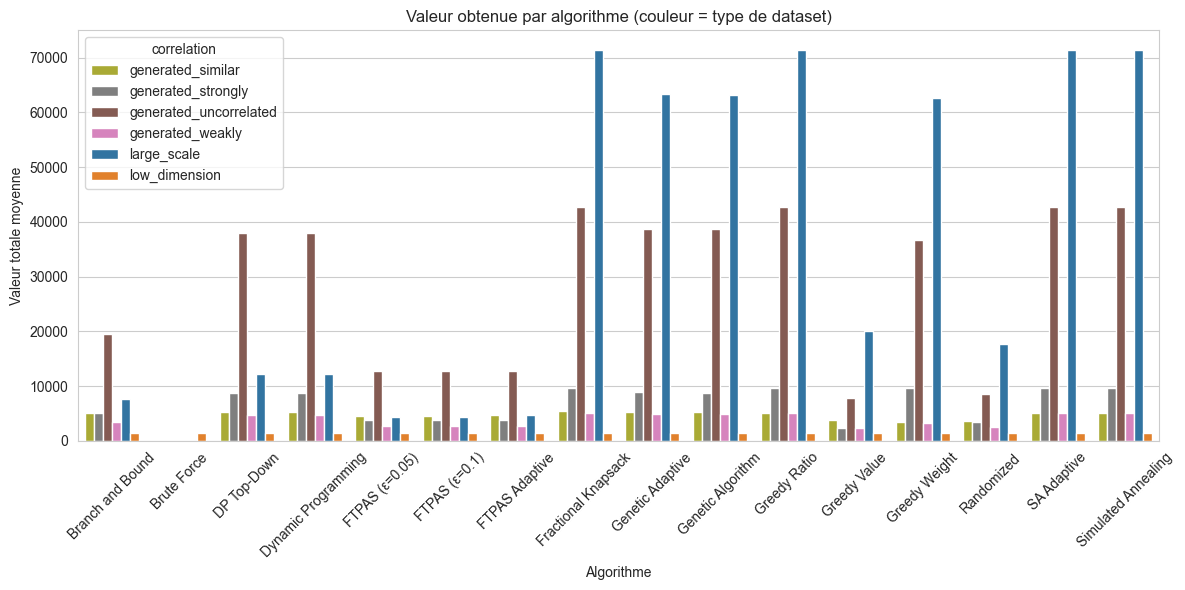

In [39]:
# Graphique 1 : Qualité (valeur totale) par algorithme, couleur = correlation
if results_df is not None:
    df = results_df.copy()
    # moyenne valeur par algorithme x correlation
    agg = df.groupby(['algorithm', 'correlation'])['value'].mean().reset_index()
    
    plt.figure(figsize=(12,6))
    # Palette pour toutes les catégories
    palette_map = {
        'large_scale': '#1f77b4',
        'low_dimension': '#ff7f0e',
        'uncorrelated': '#2ca02c',
        'weakly_correlated': '#d62728',
        'strongly_correlated': '#9467bd',
        'generated_uncorrelated': '#8c564b',
        'generated_weakly_correlated': '#e377c2',
        'generated_strongly_correlated': '#7f7f7f',
        'generated_similar_weights': '#bcbd22',
        'generated_inverse_strongly_correlated': '#17becf',
        # Versions courtes au cas où
        'generated_weakly': '#e377c2',
        'generated_strongly': '#7f7f7f',
        'generated_similar': '#bcbd22',
    }
    # Filtrer la palette pour ne garder que les catégories présentes
    categories_present = agg['correlation'].unique()
    palette_filtered = {k: v for k, v in palette_map.items() if k in categories_present}
    # Ajouter des couleurs auto pour catégories inconnues
    for cat in categories_present:
        if cat not in palette_filtered:
            palette_filtered[cat] = None
    
    sns.barplot(data=agg, x='algorithm', y='value', hue='correlation', palette=palette_filtered)
    plt.xlabel('Algorithme')
    plt.ylabel('Valeur totale moyenne')
    plt.title('Valeur obtenue par algorithme (couleur = type de dataset)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

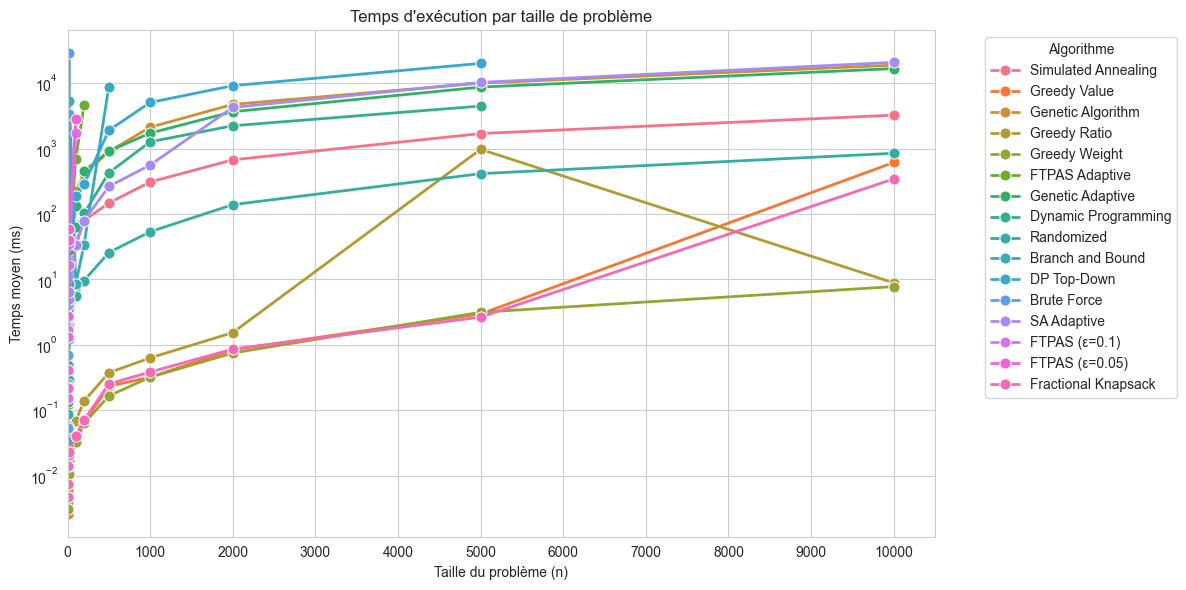

In [40]:
# Graphique 2 : Temps d'exécution par taille n
if results_df is not None:
    df = results_df.copy()
    
    # Moyenne du temps par algorithme et taille n
    agg_time = df.groupby(['algorithm', 'n'])['time_ms'].mean().reset_index()
    
    # Trier par n
    agg_time = agg_time.sort_values('n')
    
    plt.figure(figsize=(12,6))
    
    # Utiliser lineplot avec algorithme comme hue (couleur)
    sns.lineplot(data=agg_time, x='n', y='time_ms', hue='algorithm', marker='o', palette='husl', linewidth=2, markersize=8)
    
    plt.xlabel('Taille du problème (n)')
    plt.ylabel('Temps moyen (ms)')
    plt.title('Temps d\'exécution par taille de problème')
    plt.yscale('log')
    
    # Axe X avec ticks tous les 1000
    max_n = int(agg_time['n'].max())
    plt.xticks(range(0, max_n + 1000, 1000))
    plt.xlim(0, max_n + 500)
    
    plt.legend(title='Algorithme', bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

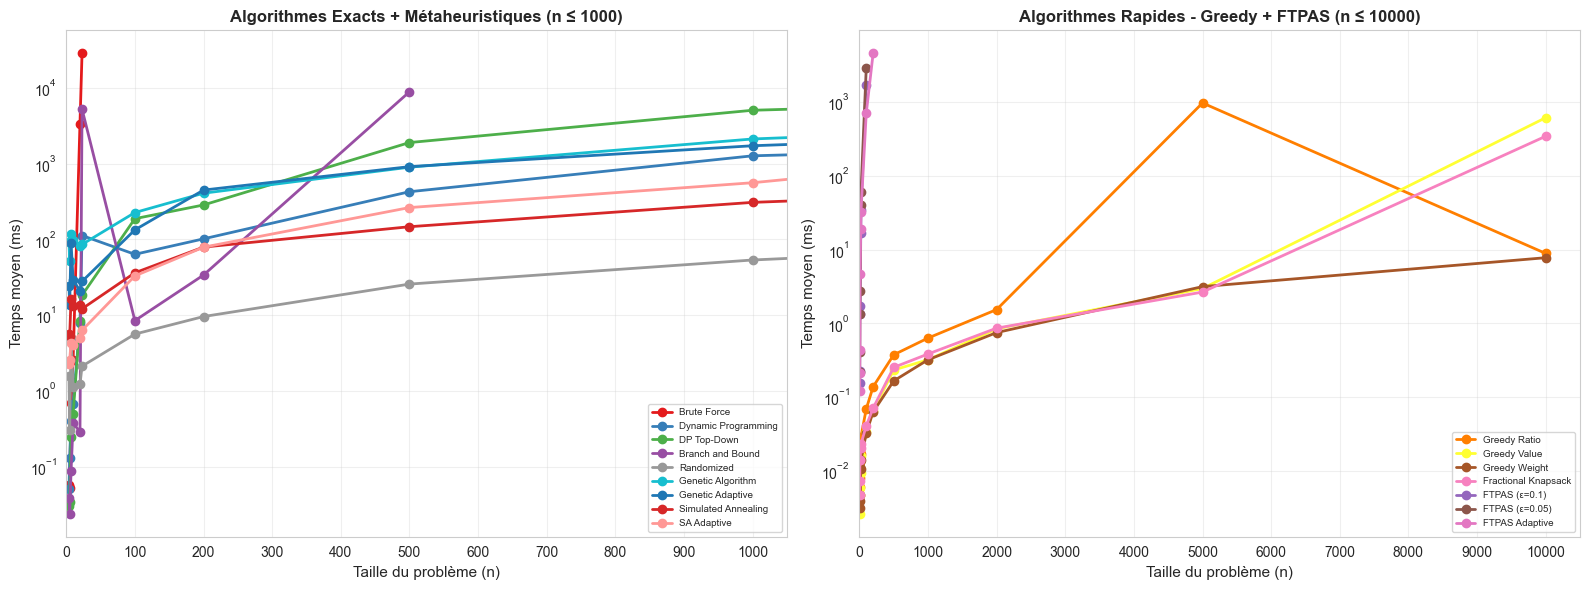

In [41]:
# Graphique 2bis : Temps d'exécution par groupe d'algorithmes
if results_df is not None:
    df = results_df.copy()
    agg_time = df.groupby(['algorithm', 'n'])['time_ms'].mean().reset_index()
    
    # Groupe 1: Algorithmes avec données jusqu'à n~1000 (exacts + métaheuristiques)
    algos_limited = ['Brute Force', 'Dynamic Programming', 'DP Top-Down', 'Branch and Bound',
                     'Randomized', 'Genetic Algorithm', 'Genetic Adaptive', 
                     'Simulated Annealing', 'SA Adaptive']
    
    # Groupe 2: Algorithmes rapides scalables (Greedy + FTPAS)
    algos_scalable = ['Greedy Ratio', 'Greedy Value', 'Greedy Weight', 'Fractional Knapsack',
                      'FTPAS (ε=0.1)', 'FTPAS (ε=0.05)', 'FTPAS Adaptive']
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- Graphique 2a: Algorithmes Exacts + Métaheuristiques (n <= 1000) ---
    ax1 = axes[0]
    data_limited = agg_time[agg_time['algorithm'].isin(algos_limited)]
    for algo in algos_limited:
        algo_data = data_limited[data_limited['algorithm'] == algo].sort_values('n')
        if len(algo_data) > 0:
            color = ALGO_COLORS.get(algo, '#333333')
            ax1.plot(algo_data['n'], algo_data['time_ms'], 'o-', label=algo, color=color, linewidth=2, markersize=6)
    ax1.set_xlabel('Taille du problème (n)', fontsize=11)
    ax1.set_ylabel('Temps moyen (ms)', fontsize=11)
    ax1.set_title('Algorithmes Exacts + Métaheuristiques (n ≤ 1000)', fontsize=12, fontweight='bold')
    ax1.set_yscale('log')
    ax1.set_xticks(range(0, 1100, 100))
    ax1.set_xlim(0, 1050)
    ax1.legend(fontsize=7, loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # --- Graphique 2b: Algorithmes Rapides (Greedy + FTPAS, n <= 10000) ---
    ax2 = axes[1]
    data_scalable = agg_time[agg_time['algorithm'].isin(algos_scalable)]
    for algo in algos_scalable:
        algo_data = data_scalable[data_scalable['algorithm'] == algo].sort_values('n')
        if len(algo_data) > 0:
            color = ALGO_COLORS.get(algo, '#333333')
            ax2.plot(algo_data['n'], algo_data['time_ms'], 'o-', label=algo, color=color, linewidth=2, markersize=6)
    ax2.set_xlabel('Taille du problème (n)', fontsize=11)
    ax2.set_ylabel('Temps moyen (ms)', fontsize=11)
    ax2.set_title('Algorithmes Rapides - Greedy + FTPAS (n ≤ 10000)', fontsize=12, fontweight='bold')
    ax2.set_yscale('log')
    ax2.set_xticks(range(0, 11000, 1000))
    ax2.set_xlim(0, 10500)
    ax2.legend(fontsize=7, loc='lower right')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé.")

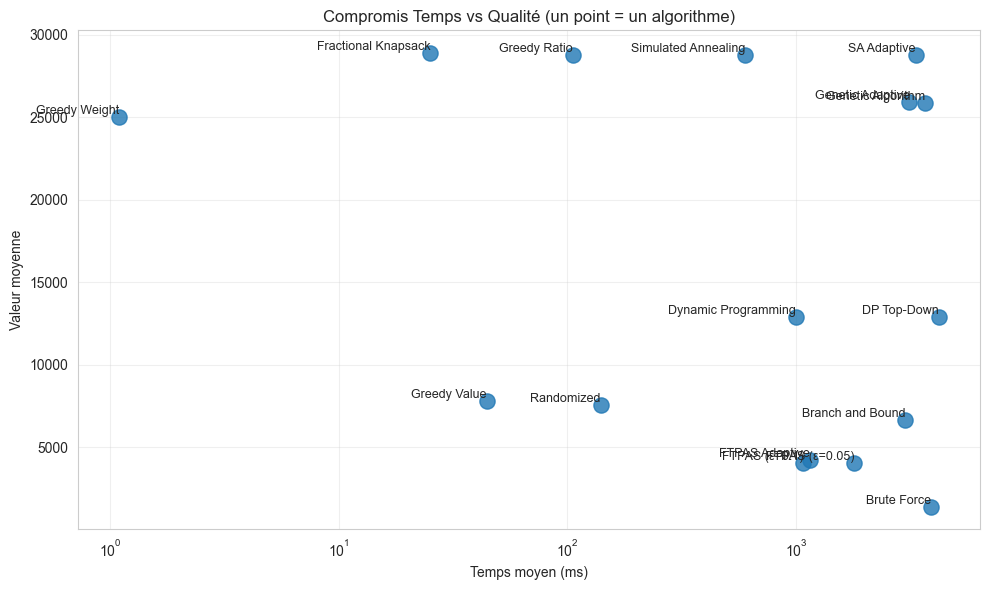

In [42]:
# Graphique 3 : Scatter Temps (X) vs Valeur (Y), 1 point = 1 algorithme (moyennes), annoté
if results_df is not None:
    df = results_df.copy()
    # prendre la moyenne temps et valeur par algorithme
    summary = df.groupby('algorithm').agg({'time_ms':'mean','value':'mean'}).reset_index()
    
    plt.figure(figsize=(10,6))
    plt.scatter(summary['time_ms'], summary['value'], s=120, alpha=0.8)
    for i, row in summary.iterrows():
        plt.text(row['time_ms'], row['value'], row['algorithm'], fontsize=9,
                 verticalalignment='bottom', horizontalalignment='right')
    plt.xscale('log')
    plt.xlabel('Temps moyen (ms)')
    plt.ylabel('Valeur moyenne')
    plt.title('Compromis Temps vs Qualité (un point = un algorithme)')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

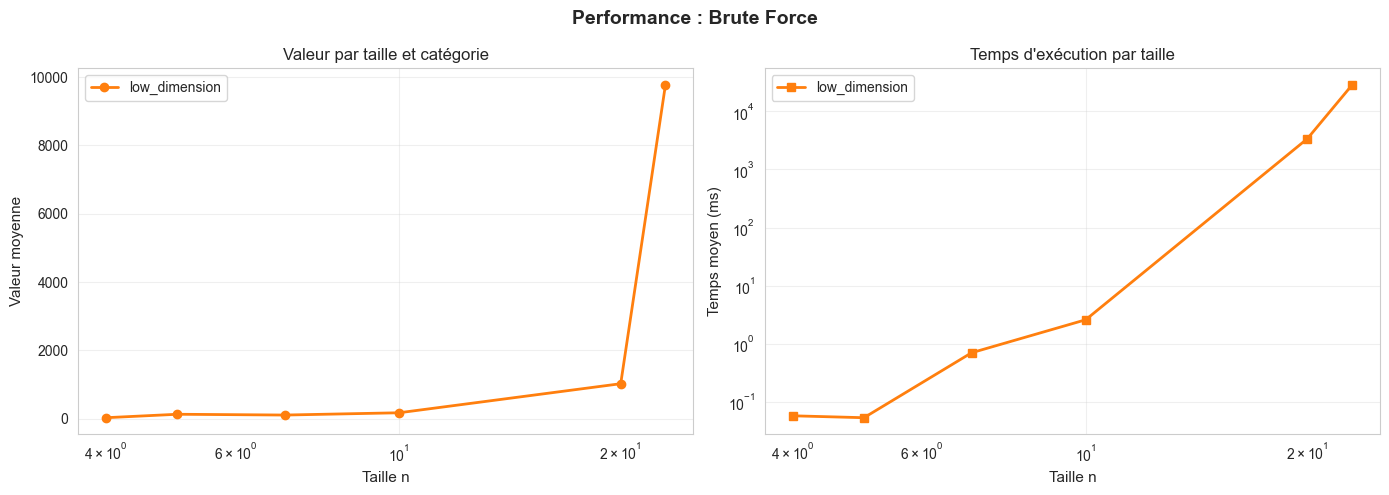

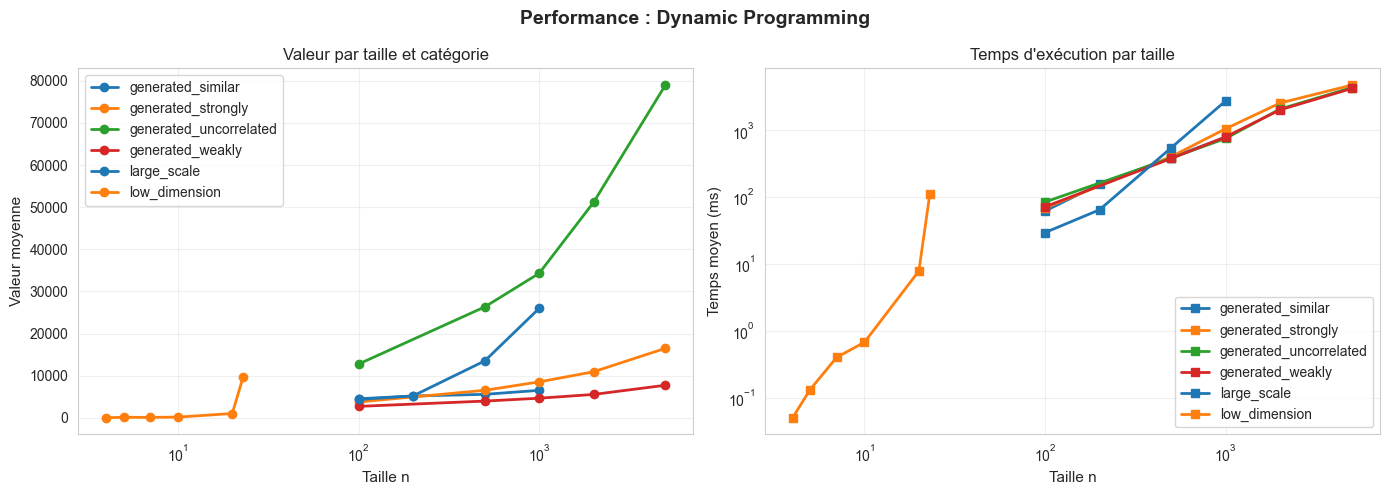

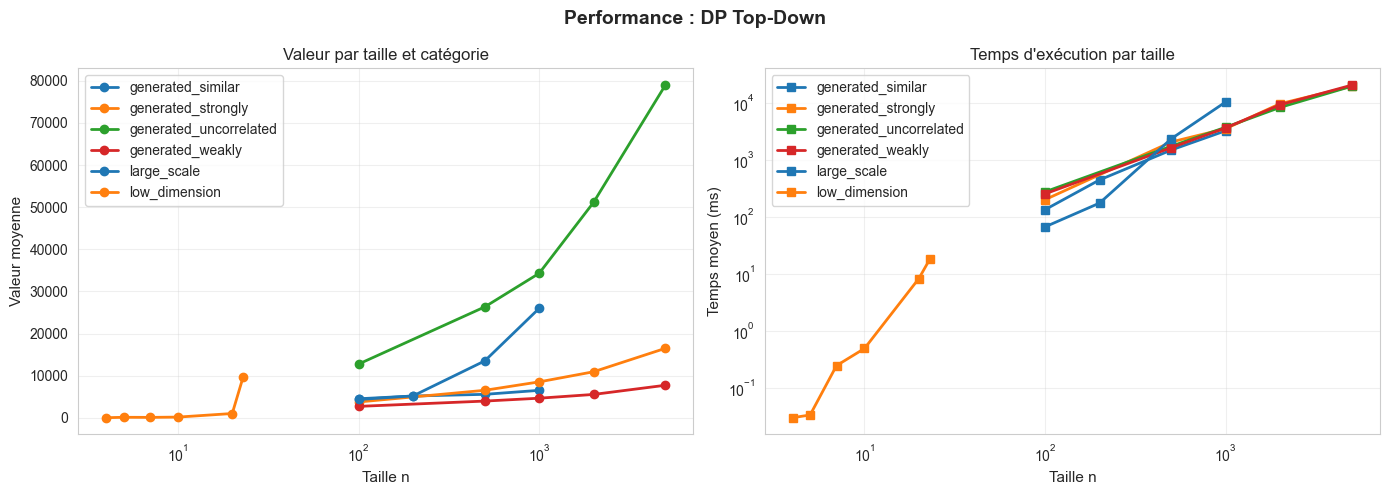

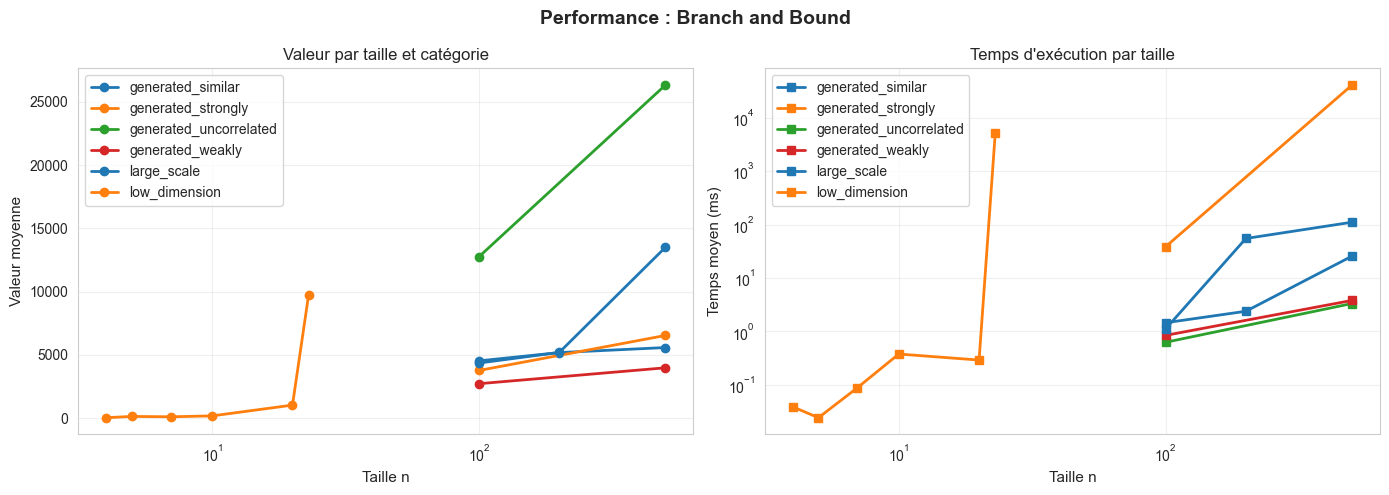

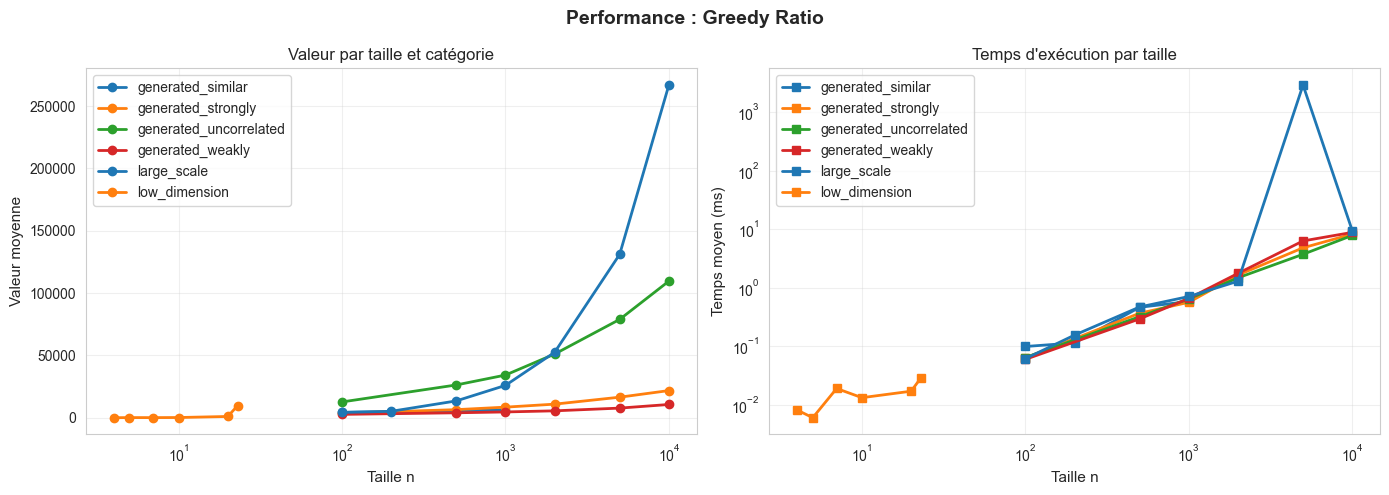

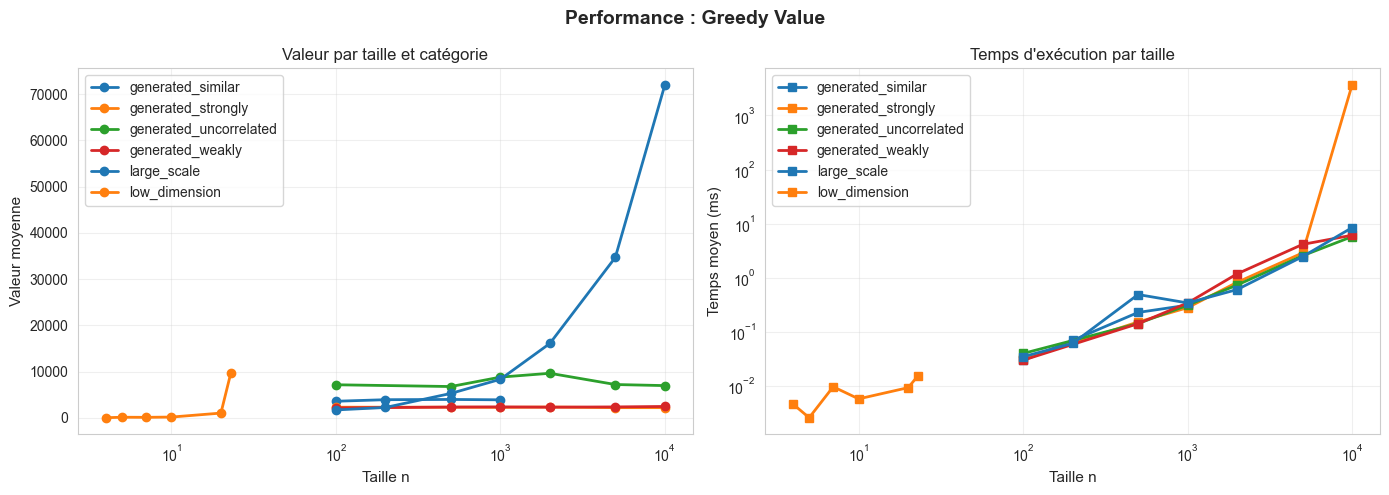

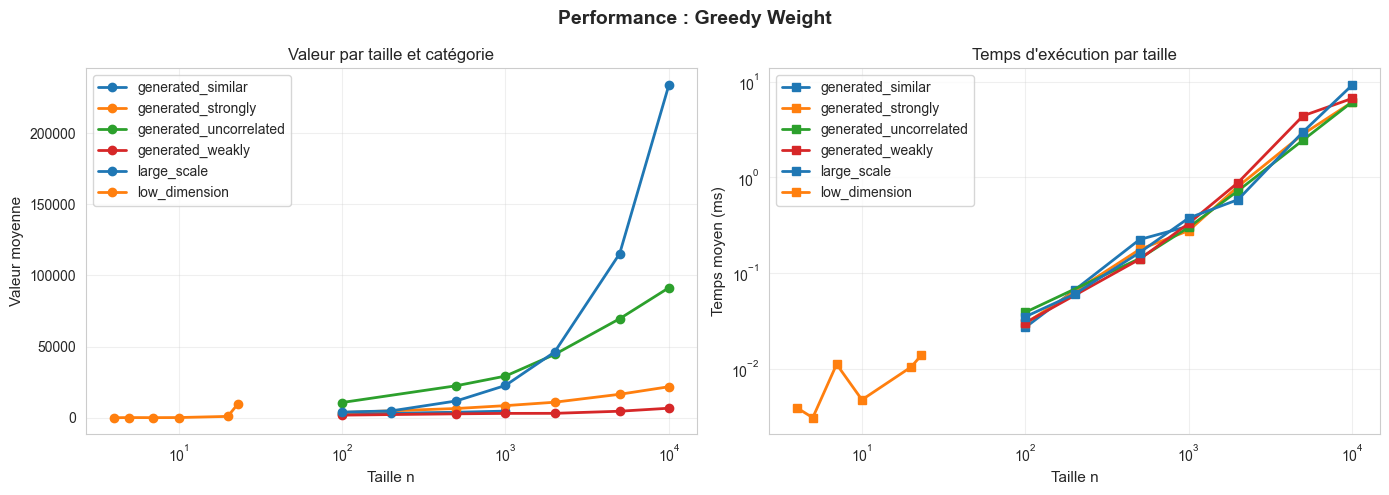

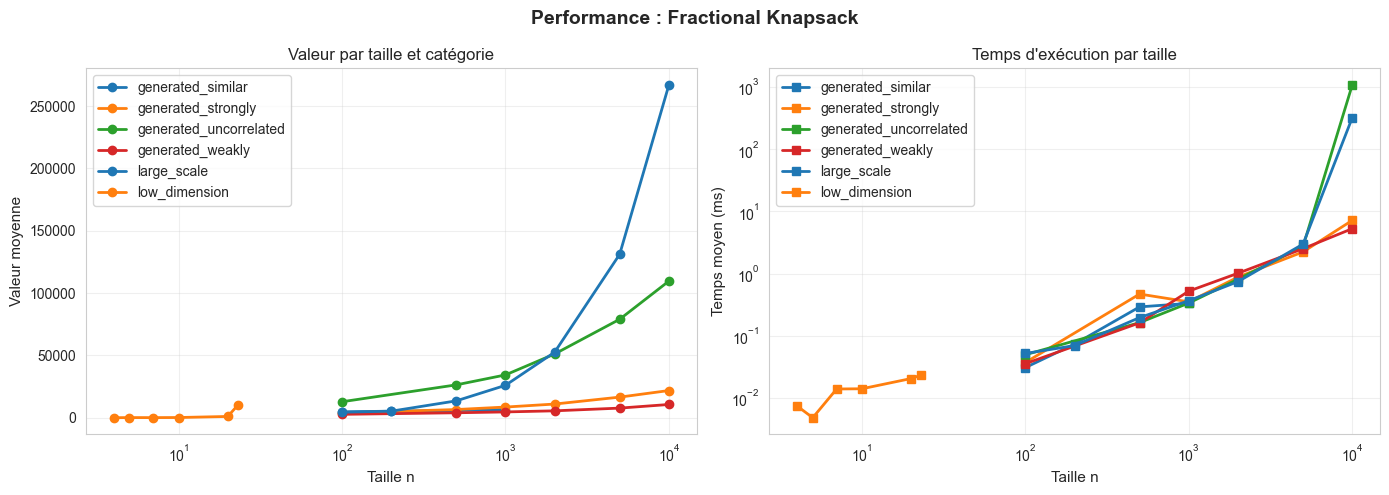

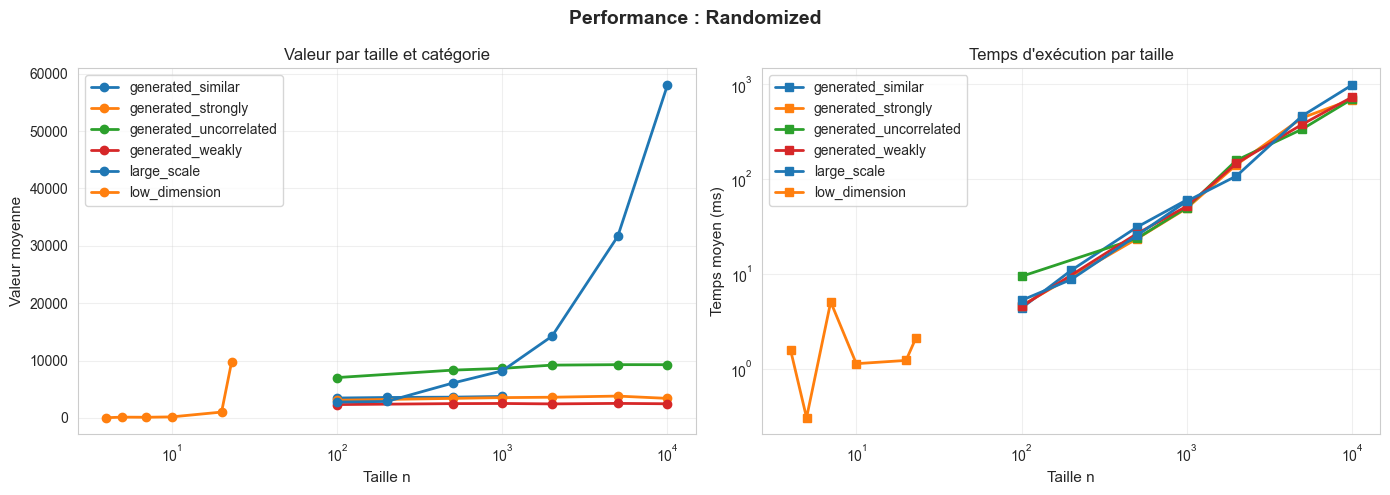

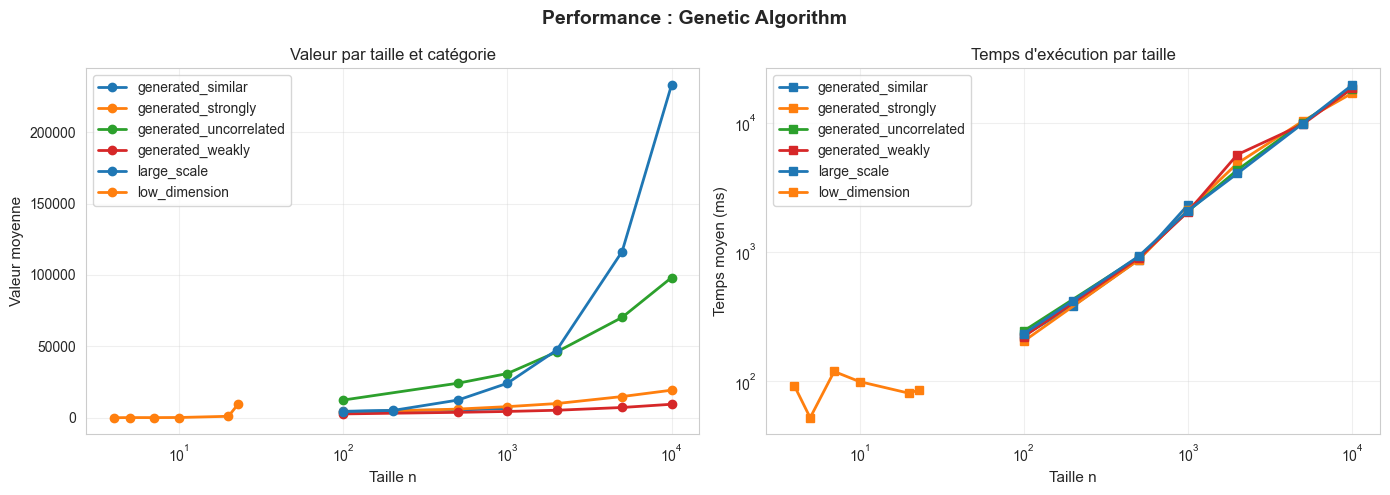

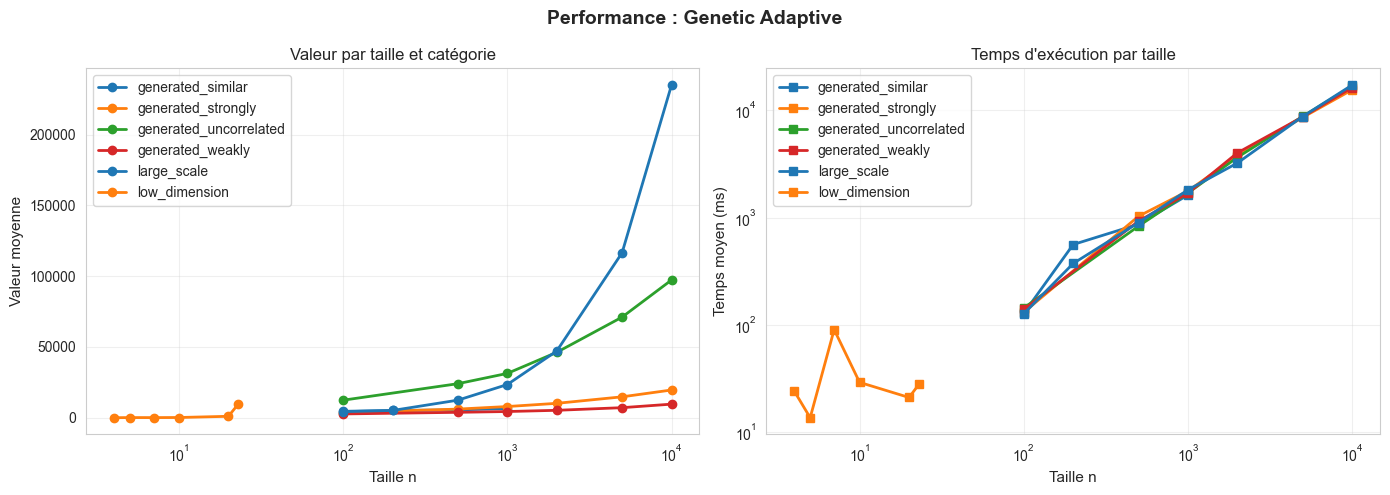

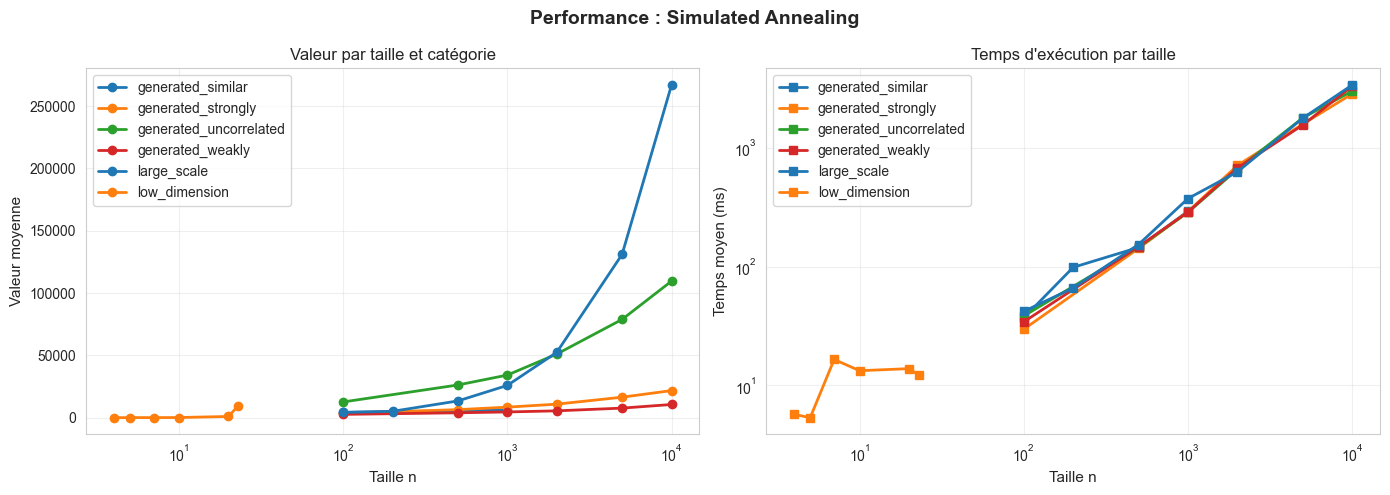

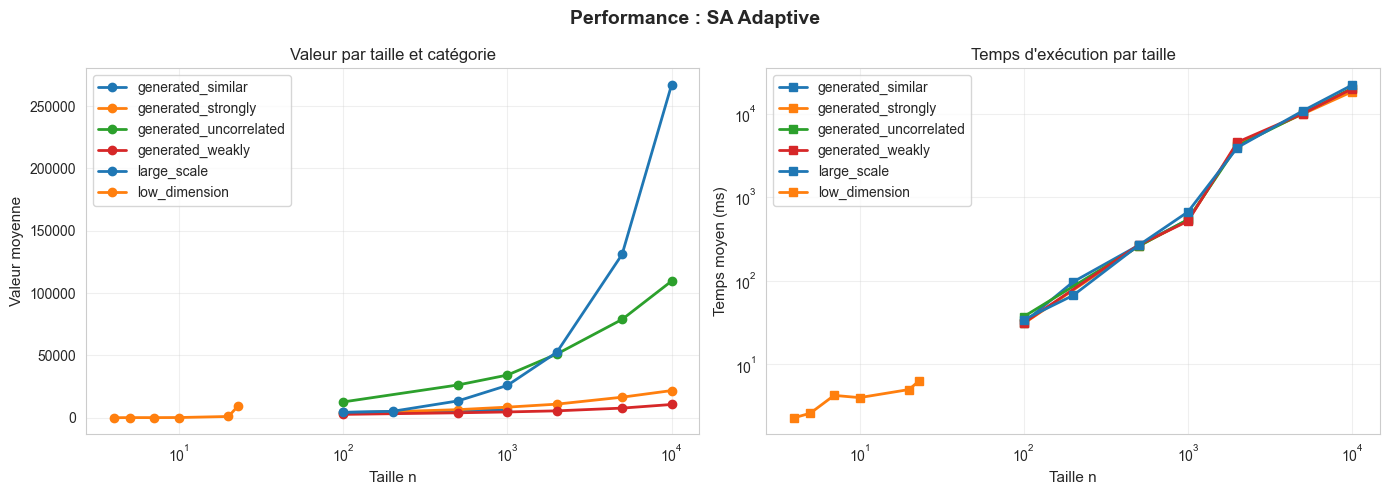

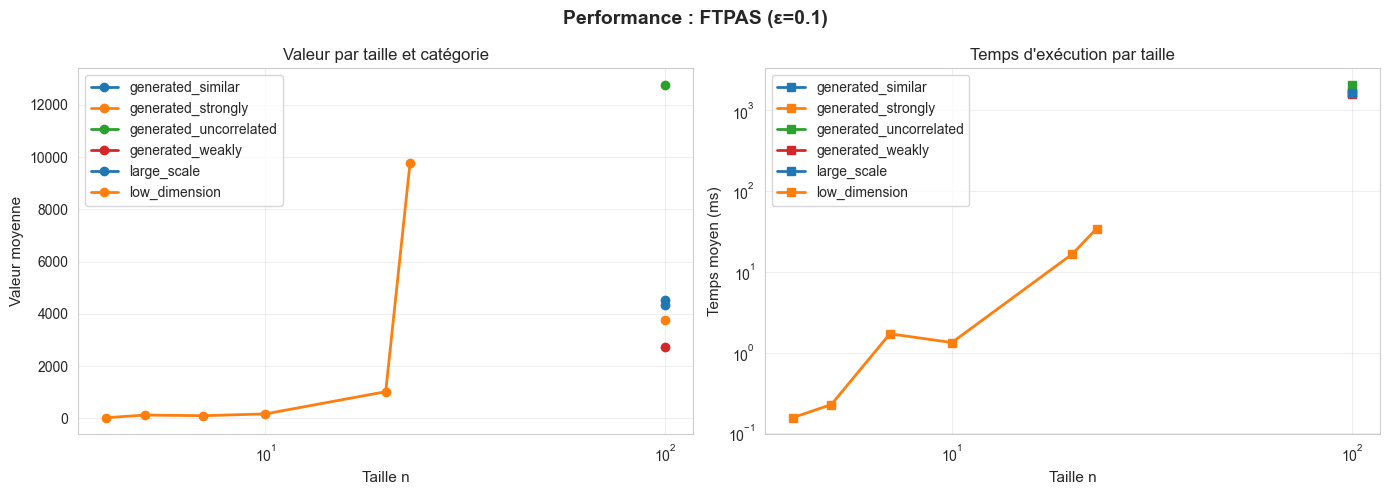

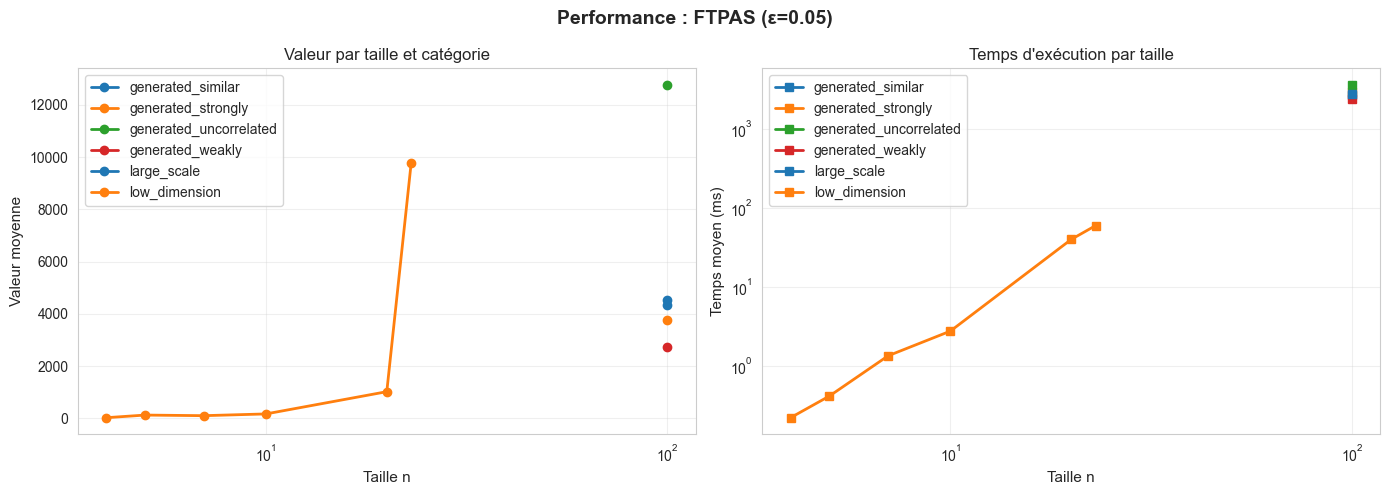

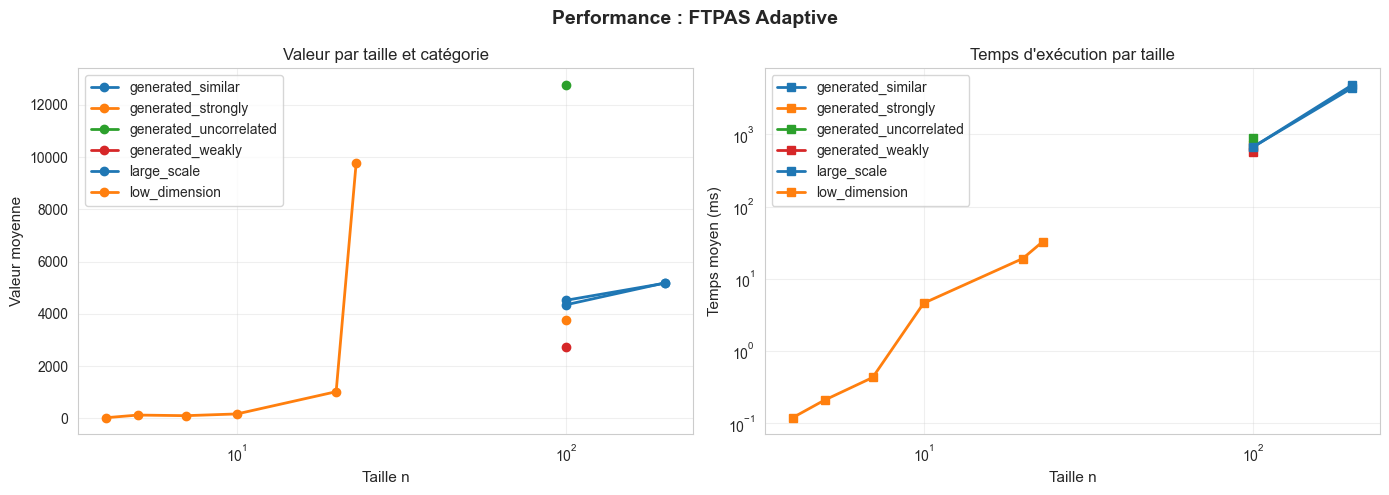

In [43]:
if results_df is not None:
    df = results_df.copy()
    
    algorithms = df['algorithm'].unique()
    
    # couleurs pour les deux catégories principales
    colors_cat = {'large_scale':'#1f77b4','low_dimension':'#ff7f0e'}
    
    for algo in algorithms:
        algo_data = df[df['algorithm'] == algo].copy()
        
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        fig.suptitle(f'Performance : {algo}', fontsize=14, fontweight='bold')
        
        # Valeur par catégorie et taille n
        if 'category' in algo_data.columns:
            agg_value = algo_data.groupby(['category', 'n'])['value'].mean().reset_index()
            groups = agg_value['category'].unique()
        else:
            # fallback vers 'correlation' si présent
            agg_value = algo_data.groupby(['correlation', 'n'])['value'].mean().reset_index()
            agg_value = agg_value.rename(columns={'correlation':'category'})
            groups = agg_value['category'].unique()

        for cat in groups:
            cat_data = agg_value[agg_value['category'] == cat]
            axes[0].plot(cat_data['n'], cat_data['value'], marker='o', label=cat, linewidth=2,
                         color=colors_cat.get(cat, None))
        
        axes[0].set_xlabel('Taille n', fontsize=11)
        axes[0].set_ylabel('Valeur moyenne', fontsize=11)
        axes[0].set_title('Valeur par taille et catégorie')
        axes[0].legend()
        axes[0].grid(alpha=0.3)
        axes[0].set_xscale('log')
        
        # Temps d'exécution par taille n
        if 'category' in algo_data.columns:
            agg_time = algo_data.groupby(['category', 'n'])['time_ms'].mean().reset_index()
        else:
            agg_time = algo_data.groupby(['correlation', 'n'])['time_ms'].mean().reset_index()
            agg_time = agg_time.rename(columns={'correlation':'category'})

        for cat in agg_time['category'].unique():
            cat_data = agg_time[agg_time['category'] == cat]
            axes[1].plot(cat_data['n'], cat_data['time_ms'], marker='s', label=cat, linewidth=2,
                         color=colors_cat.get(cat, None))
        
        axes[1].set_xlabel('Taille n', fontsize=11)
        axes[1].set_ylabel('Temps moyen (ms)', fontsize=11)
        axes[1].set_title('Temps d\'exécution par taille')
        axes[1].legend()
        axes[1].grid(alpha=0.3)
        axes[1].set_xscale('log')
        axes[1].set_yscale('log')
        
        plt.tight_layout()
        plt.show()
        print(f"\n{'='*60}\n")
else:
    print("results_df non chargé. Exécutez d'abord la cellule qui charge 'benchmark_results.csv'.")

### 6.2 Analyse par Type de Corrélation

Ces graphiques comparent les performances des algorithmes selon le type de données :
- **uncorrelated**: Poids et valeurs indépendants
- **weakly_correlated**: Légère corrélation entre poids et valeurs  
- **strongly_correlated**: Forte corrélation (valeur ≈ poids + constante)

Les instances fortement corrélées sont généralement plus difficiles pour les heuristiques.

In [44]:
# Graphique 4 : Comparaison par type de corrélation
if results_df is not None:
    df = results_df.copy()
    
    # Vérifier quels types de corrélation sont présents
    correlation_types = df['correlation'].unique()
    print(f"Types de corrélation présents: {correlation_types}")
    
    # Palette de couleurs pour les corrélations
    corr_colors = {
        'uncorrelated': '#2ecc71',        # Vert
        'weakly_correlated': '#f39c12',   # Orange
        'strongly_correlated': '#e74c3c', # Rouge
        'low_dimension': '#3498db',       # Bleu
        'large_scale': '#9b59b6'          # Violet
    }
    
    # Si on a les 3 types de corrélation, créer des graphiques comparatifs
    corr_types_present = [c for c in ['uncorrelated', 'weakly_correlated', 'strongly_correlated'] 
                          if c in correlation_types]
    
    if len(corr_types_present) > 0:
        print(f"\nAnalyse des corrélations: {corr_types_present}")
        
        # ---- Graphique 4a: Valeur moyenne par algorithme et corrélation ----
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Filtrer seulement les types de corrélation
        df_corr = df[df['correlation'].isin(corr_types_present)]
        
        if len(df_corr) > 0:
            # Valeur moyenne
            agg_val = df_corr.groupby(['algorithm', 'correlation'])['value'].mean().reset_index()
            pivot_val = agg_val.pivot(index='algorithm', columns='correlation', values='value')
            
            ax1 = axes[0]
            pivot_val.plot(kind='bar', ax=ax1, color=[corr_colors.get(c, '#333') for c in pivot_val.columns])
            ax1.set_xlabel('Algorithme', fontsize=11)
            ax1.set_ylabel('Valeur moyenne', fontsize=11)
            ax1.set_title('Valeur obtenue par type de corrélation', fontsize=12, fontweight='bold')
            ax1.tick_params(axis='x', rotation=45)
            ax1.legend(title='Corrélation')
            ax1.grid(alpha=0.3, axis='y')
            
            # Temps moyen
            agg_time = df_corr.groupby(['algorithm', 'correlation'])['time_ms'].mean().reset_index()
            pivot_time = agg_time.pivot(index='algorithm', columns='correlation', values='time_ms')
            
            ax2 = axes[1]
            pivot_time.plot(kind='bar', ax=ax2, color=[corr_colors.get(c, '#333') for c in pivot_time.columns])
            ax2.set_xlabel('Algorithme', fontsize=11)
            ax2.set_ylabel('Temps moyen (ms)', fontsize=11)
            ax2.set_title('Temps d\'exécution par type de corrélation', fontsize=12, fontweight='bold')
            ax2.tick_params(axis='x', rotation=45)
            ax2.set_yscale('log')
            ax2.legend(title='Corrélation')
            ax2.grid(alpha=0.3, axis='y')
            
            plt.tight_layout()
            plt.show()
        else:
            print("Pas de données pour les types de corrélation")
    else:
        print("\nLes benchmarks de corrélation (uncorrelated, weakly_correlated, strongly_correlated)")
        print("n'ont pas encore été exécutés.")
        print("Pour les inclure, relancez run_all_benchmarks() après avoir modifié discover_benchmarks()")
else:
    print("results_df non chargé.")

Types de corrélation présents: ['low_dimension' 'large_scale' 'generated_weakly' 'generated_strongly'
 'generated_uncorrelated' 'generated_similar']

Les benchmarks de corrélation (uncorrelated, weakly_correlated, strongly_correlated)
n'ont pas encore été exécutés.
Pour les inclure, relancez run_all_benchmarks() après avoir modifié discover_benchmarks()


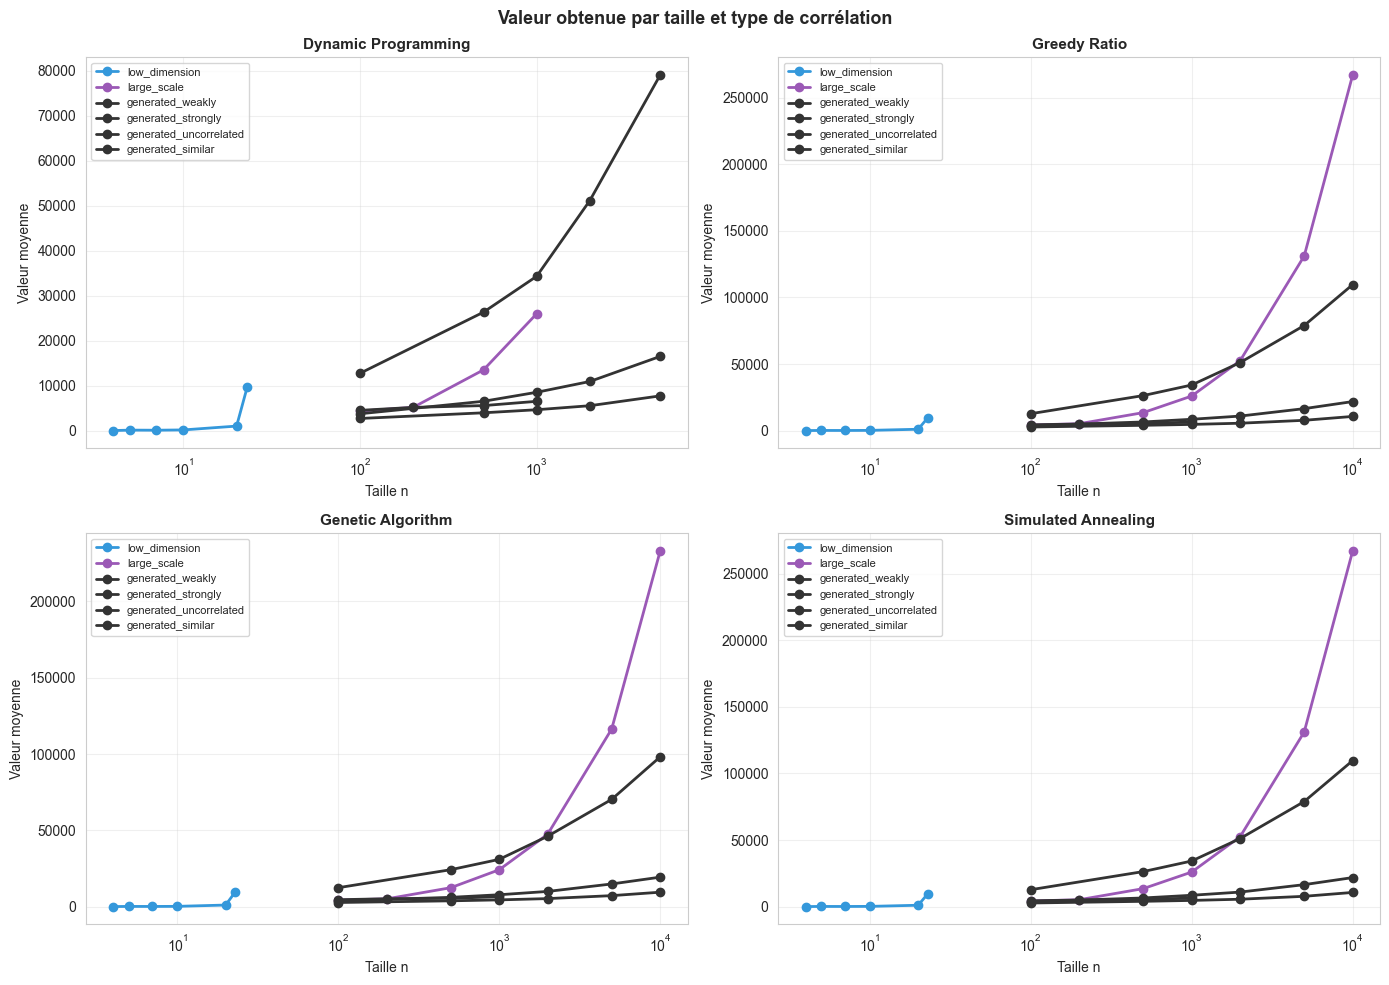

In [45]:
# Graphique 5 : Évolution des performances selon n pour chaque type de corrélation
if results_df is not None:
    df = results_df.copy()
    
    # Palette de couleurs pour les corrélations
    corr_colors = {
        'uncorrelated': '#2ecc71',
        'weakly_correlated': '#f39c12', 
        'strongly_correlated': '#e74c3c',
        'low_dimension': '#3498db',
        'large_scale': '#9b59b6'
    }
    
    # Sélectionner quelques algorithmes représentatifs pour la lisibilité
    algos_to_show = ['Dynamic Programming', 'Greedy Ratio', 'Genetic Algorithm', 'Simulated Annealing']
    algos_present = [a for a in algos_to_show if a in df['algorithm'].unique()]
    
    if len(algos_present) > 0:
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for idx, algo in enumerate(algos_present[:4]):
            ax = axes[idx]
            algo_data = df[df['algorithm'] == algo]
            
            for corr in algo_data['correlation'].unique():
                corr_data = algo_data[algo_data['correlation'] == corr]
                agg = corr_data.groupby('n').agg({'value': 'mean', 'time_ms': 'mean'}).reset_index()
                agg = agg.sort_values('n')
                
                color = corr_colors.get(corr, '#333')
                ax.plot(agg['n'], agg['value'], 'o-', label=corr, color=color, linewidth=2, markersize=6)
            
            ax.set_xlabel('Taille n', fontsize=10)
            ax.set_ylabel('Valeur moyenne', fontsize=10)
            ax.set_title(f'{algo}', fontsize=11, fontweight='bold')
            ax.legend(fontsize=8)
            ax.grid(alpha=0.3)
            ax.set_xscale('log')
        
        plt.suptitle('Valeur obtenue par taille et type de corrélation', fontsize=13, fontweight='bold')
        plt.tight_layout()
        plt.show()
else:
    print("results_df non chargé.")

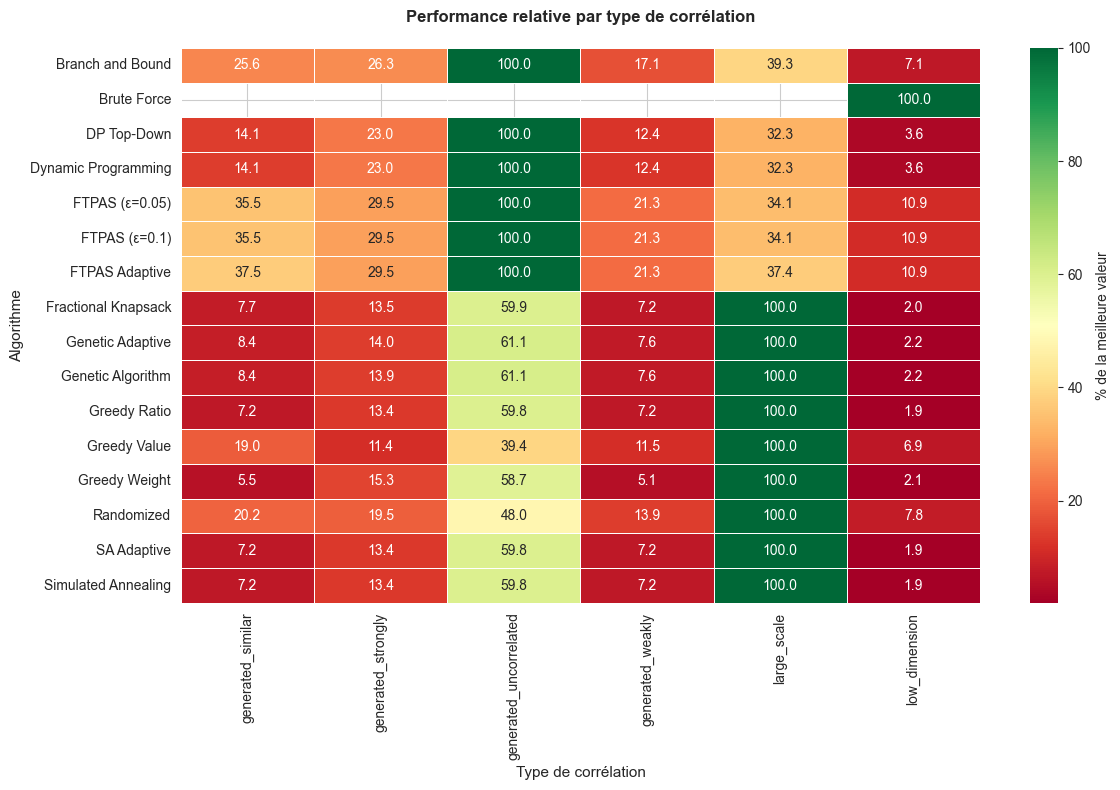

In [46]:
# Graphique 6 : Heatmap de performance relative par corrélation
if results_df is not None:
    df = results_df.copy()
    
    # Calculer la valeur moyenne par algorithme et corrélation
    pivot = df.groupby(['algorithm', 'correlation'])['value'].mean().unstack()
    
    if pivot.shape[1] > 1:  # Au moins 2 types de corrélation
        # Normaliser par ligne (algorithme) pour voir les différences relatives
        pivot_norm = pivot.div(pivot.max(axis=1), axis=0) * 100
        
        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_norm, annot=True, fmt='.1f', cmap='RdYlGn', 
                    cbar_kws={'label': '% de la meilleure valeur'},
                    linewidths=0.5)
        plt.title('Performance relative par type de corrélation\n', 
                  fontsize=12, fontweight='bold')
        plt.xlabel('Type de corrélation', fontsize=11)
        plt.ylabel('Algorithme', fontsize=11)
        plt.tight_layout()
        plt.show()
        
else:
    print("results_df non chargé.")

In [47]:
# Graphique 7 : Tableau récapitulatif détaillé
if results_df is not None:
    df = results_df.copy()
    
    # Créer un tableau récapitulatif complet
    summary = df.groupby(['correlation', 'algorithm']).agg({
        'value': ['mean', 'std', 'count'],
        'time_ms': ['mean', 'std'],
        'n': ['min', 'max']
    }).round(2)
    
    # Aplatir les colonnes multi-niveaux
    summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
    summary = summary.reset_index()
    
    print("=" * 80)
    print("TABLEAU RÉCAPITULATIF DES RÉSULTATS PAR TYPE DE CORRÉLATION")
    print("=" * 80)
    
    for corr in summary['correlation'].unique():
        print(f"\n>>> {corr.upper()} <<<")
        print("-" * 60)
        corr_data = summary[summary['correlation'] == corr]
        
        # Trier par valeur moyenne décroissante
        corr_data = corr_data.sort_values('value_mean', ascending=False)
        
        for _, row in corr_data.iterrows():
            print(f"  {row['algorithm']:25s} | Valeur: {row['value_mean']:>10.1f} ± {row['value_std']:>8.1f} | "
                  f"Temps: {row['time_ms_mean']:>10.2f}ms | n: {int(row['n_min'])}-{int(row['n_max'])}")
    
    print("\n" + "=" * 80)
else:
    print("results_df non chargé.")

TABLEAU RÉCAPITULATIF DES RÉSULTATS PAR TYPE DE CORRÉLATION

>>> GENERATED_SIMILAR <<<
------------------------------------------------------------
  Fractional Knapsack       | Valeur:     5492.8 ±    828.9 | Temps:       0.16ms | n: 100-1000
  Dynamic Programming       | Valeur:     5347.1 ±    844.1 | Temps:     319.04ms | n: 100-1000
  DP Top-Down               | Valeur:     5347.1 ±    844.1 | Temps:    1205.78ms | n: 100-1000
  Genetic Adaptive          | Valeur:     5339.7 ±    827.6 | Temps:     720.50ms | n: 100-1000
  Genetic Algorithm         | Valeur:     5300.3 ±    832.8 | Temps:     870.22ms | n: 100-1000
  Simulated Annealing       | Valeur:     5148.6 ±    895.8 | Temps:     131.92ms | n: 100-1000
  Greedy Ratio              | Valeur:     5148.6 ±    895.8 | Temps:       0.29ms | n: 100-1000
  SA Adaptive               | Valeur:     5148.6 ±    895.8 | Temps:     210.58ms | n: 100-1000
  Branch and Bound          | Valeur:     5010.7 ±    555.0 | Temps:       8.64ms | 

---
## 7. Analyse de Complexité

### 7.1 Complexité Théorique des Algorithmes

| Algorithme | Complexité Temporelle | Complexité Spatiale | Type |
|------------|----------------------|---------------------|------|
| **Brute Force** | $O(2^n)$ | $O(n)$ | Exact |
| **DP Bottom-Up** | $O(n \cdot C)$ | $O(n \cdot C)$ | Exact (pseudo-poly) |
| **DP Top-Down** | $O(n \cdot C)$ | $O(n \cdot C)$ | Exact (pseudo-poly) |
| **Branch & Bound** | $O(2^n)$ pire cas | $O(n)$ | Exact |
| **Greedy (ratio)** | $O(n \log n)$ | $O(n)$ | Approximation |
| **Fractional Knapsack** | $O(n \log n)$ | $O(n)$ | Exact (relaxé) |
| **Randomized** | $O(k \cdot n)$ | $O(n)$ | Heuristique |
| **Genetic Algorithm** | $O(g \cdot p \cdot n)$ | $O(p \cdot n)$ | Métaheuristique |
| **Simulated Annealing** | $O(i \cdot n)$ | $O(n)$ | Métaheuristique |
| **FPTAS** | $O(n^2 / \varepsilon)$ | $O(n / \varepsilon)$ | Approximation |

$n$ = nombre d'items
$C$ = capacité 
$k$ = itérations
$g$ = générations
$p$ = population
$i$ = itérations SA
$\varepsilon$ = paramètre d'approximation

---
## 8. Analyses Statistiques Avancées

Cette section présente des analyses approfondies qui répondent à des questions concrètes sur les performances des algorithmes, leurs forces et leurs faiblesses. Chaque graphique et analyse est conçu pour apporter des insights actionnables.


### 8.1 Question 1: Quel algorithme offre le meilleur compromis qualité/temps selon la taille du problème ?

**Objectif:** Identifier les algorithmes les plus efficaces pour différentes gammes de tailles, en considérant à la fois la qualité de la solution et le temps d'exécution.


### 8.2 Question 2: Les algorithmes adaptatifs (Genetic Adaptive, SA Adaptive) sont-ils réellement meilleurs que leurs versions fixes ?

**Objectif:** Comparer les performances des versions adaptatives vs fixes pour démontrer l'intérêt de l'adaptation des paramètres.



COMPARAISON: Genetic Adaptive vs Genetic Algorithm
Nombre d'instances comparées: 222

Amélioration moyenne de la valeur: 22.50%
  - Meilleure amélioration: 600.62%
  - Pire cas: -85.15%
  - Écart-type: 106.90%

Changement moyen du temps: -19.93%
  - Plus rapide de: -26.05% (quand plus rapide)
  - Plus lent de: 19.26% (quand plus lent)

Test t apparié (valeur):
  - Statistique t: 0.0252
  - p-value: 0.9799
  → Pas de différence significative

COMPARAISON: SA Adaptive vs Simulated Annealing
Nombre d'instances comparées: 222

Amélioration moyenne de la valeur: 23.52%
  - Meilleure amélioration: 599.94%
  - Pire cas: -85.71%
  - Écart-type: 112.13%

Changement moyen du temps: 189.12%
  - Plus rapide de: -29.39% (quand plus rapide)
  - Plus lent de: 254.29% (quand plus lent)

Test t apparié (valeur):
  - Statistique t: 0.0001
  - p-value: 0.9999
  → Pas de différence significative


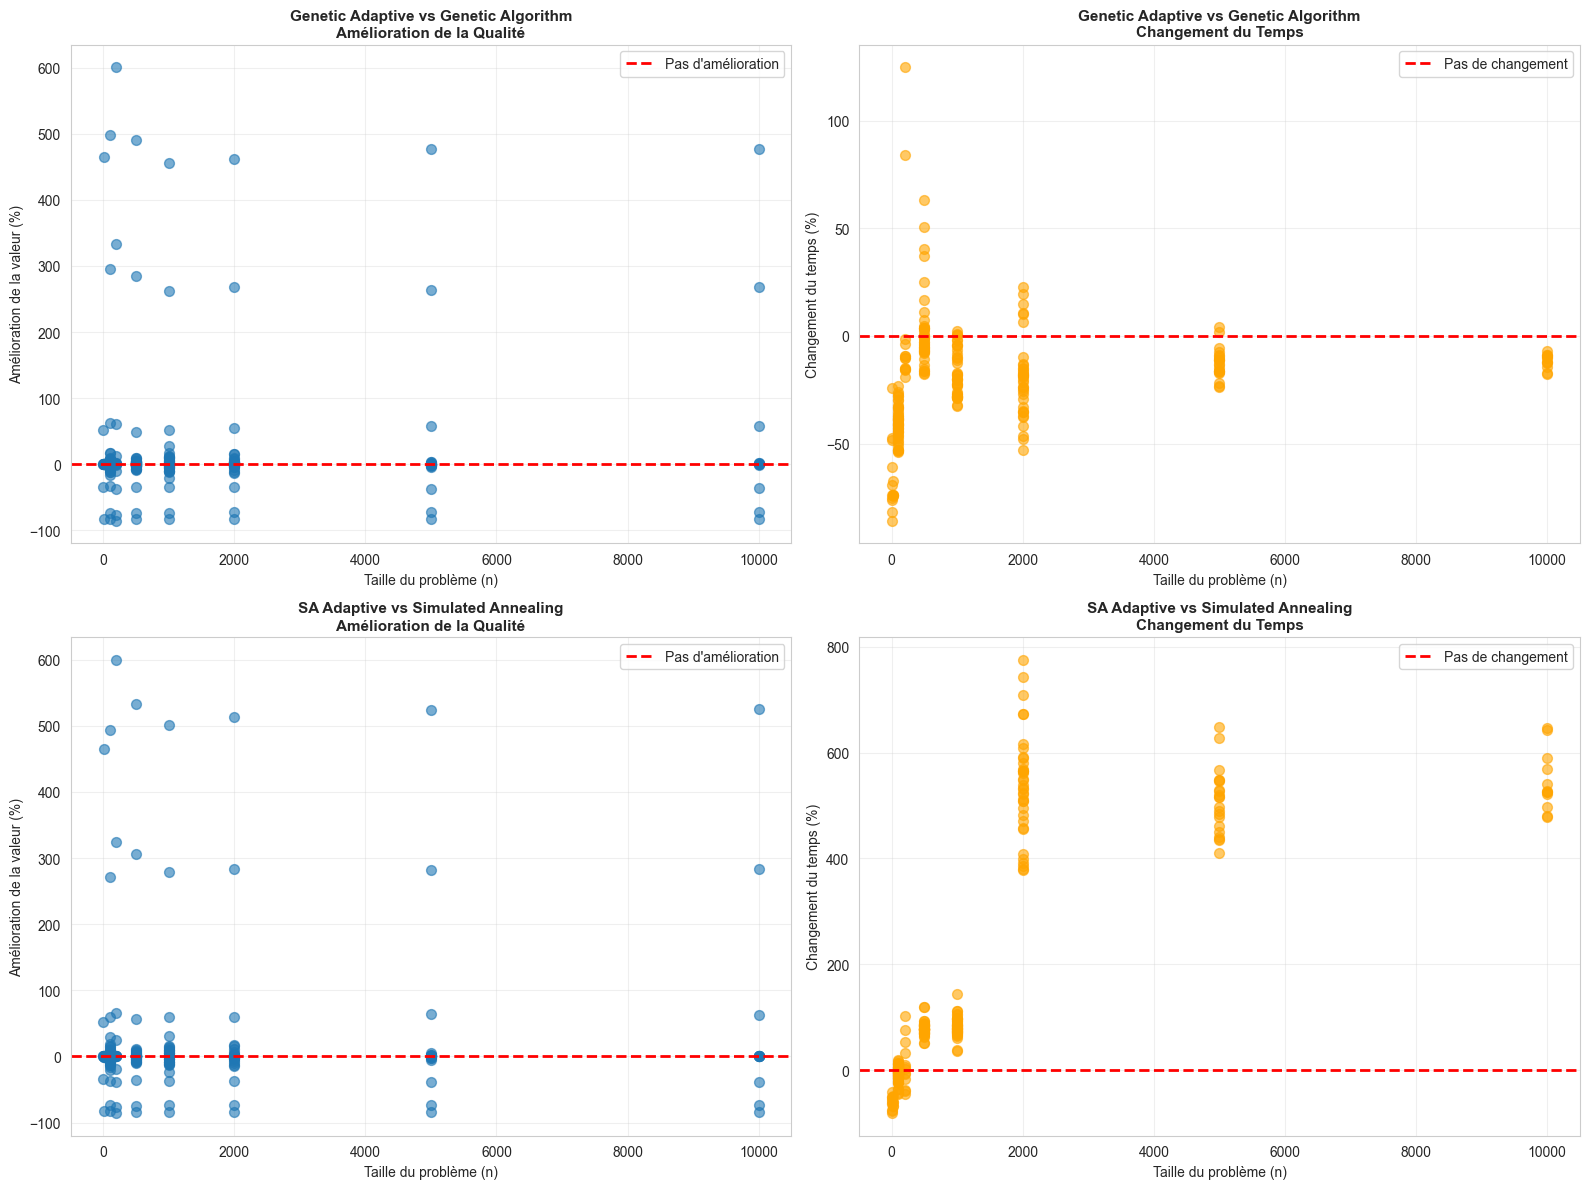

In [49]:
if results_df is not None:
    df = results_df.copy()
    
    # Paires d'algorithmes adaptatifs vs fixes
    adaptive_pairs = [
        ('Genetic Algorithm', 'Genetic Adaptive'),
        ('Simulated Annealing', 'SA Adaptive')
    ]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    for pair_idx, (fixed_name, adaptive_name) in enumerate(adaptive_pairs):
        # Vérifier que les deux algorithmes existent dans les données
        if fixed_name not in df['algorithm'].values or adaptive_name not in df['algorithm'].values:
            continue
        
        fixed_data = df[df['algorithm'] == fixed_name].copy()
        adaptive_data = df[df['algorithm'] == adaptive_name].copy()
        
        # Fusionner sur n et correlation pour comparer instance par instance
        merged = pd.merge(
            fixed_data[['n', 'correlation', 'value', 'time_ms']],
            adaptive_data[['n', 'correlation', 'value', 'time_ms']],
            on=['n', 'correlation'],
            suffixes=('_fixed', '_adaptive'),
            how='inner'
        )
        
        if len(merged) == 0:
            continue
        
        # Calculer les différences
        merged['value_diff'] = merged['value_adaptive'] - merged['value_fixed']
        merged['time_diff'] = merged['time_ms_adaptive'] - merged['time_ms_fixed']
        merged['value_improvement_pct'] = (merged['value_diff'] / merged['value_fixed']) * 100
        merged['time_change_pct'] = (merged['time_diff'] / merged['time_ms_fixed']) * 100
        
        # Graphique 1: Amélioration de la valeur
        ax1 = axes[pair_idx, 0]
        ax1.scatter(merged['n'], merged['value_improvement_pct'], alpha=0.6, s=50)
        ax1.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Pas d\'amélioration')
        ax1.set_xlabel('Taille du problème (n)', fontsize=10)
        ax1.set_ylabel('Amélioration de la valeur (%)', fontsize=10)
        ax1.set_title(f'{adaptive_name} vs {fixed_name}\nAmélioration de la Qualité', 
                     fontsize=11, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # Graphique 2: Changement du temps
        ax2 = axes[pair_idx, 1]
        ax2.scatter(merged['n'], merged['time_change_pct'], alpha=0.6, s=50, color='orange')
        ax2.axhline(y=0, color='r', linestyle='--', linewidth=2, label='Pas de changement')
        ax2.set_xlabel('Taille du problème (n)', fontsize=10)
        ax2.set_ylabel('Changement du temps (%)', fontsize=10)
        ax2.set_title(f'{adaptive_name} vs {fixed_name}\nChangement du Temps', 
                     fontsize=11, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Statistiques
        print(f"\n{'='*70}")
        print(f"COMPARAISON: {adaptive_name} vs {fixed_name}")
        print(f"{'='*70}")
        print(f"Nombre d'instances comparées: {len(merged)}")
        print(f"\nAmélioration moyenne de la valeur: {merged['value_improvement_pct'].mean():.2f}%")
        print(f"  - Meilleure amélioration: {merged['value_improvement_pct'].max():.2f}%")
        print(f"  - Pire cas: {merged['value_improvement_pct'].min():.2f}%")
        print(f"  - Écart-type: {merged['value_improvement_pct'].std():.2f}%")
        
        print(f"\nChangement moyen du temps: {merged['time_change_pct'].mean():.2f}%")
        print(f"  - Plus rapide de: {merged[merged['time_change_pct'] < 0]['time_change_pct'].mean():.2f}% (quand plus rapide)")
        print(f"  - Plus lent de: {merged[merged['time_change_pct'] > 0]['time_change_pct'].mean():.2f}% (quand plus lent)")
        
        # Test statistique
        from scipy.stats import ttest_rel
        t_stat, p_value = ttest_rel(merged['value_adaptive'], merged['value_fixed'])
        print(f"\nTest t apparié (valeur):")
        print(f"  - Statistique t: {t_stat:.4f}")
        print(f"  - p-value: {p_value:.4f}")
        if p_value < 0.05:
            print(f"  → Différence statistiquement significative (p < 0.05)")
        else:
            print(f"  → Pas de différence significative")
    
    plt.tight_layout()
    plt.show()
else:
    print("results_df non chargé.")


### 8.3 Question 3: Quelle est la robustesse (consistance) de chaque algorithme face à différents types de problèmes ?

**Objectif:** Mesurer la variance et la stabilité des performances pour identifier les algorithmes les plus fiables.


/var/folders/my/kkvcbml94_96ry9m6ps6wcr00000gn/T/ipykernel_5742/1980196355.py:58: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot(box_data, labels=[a for a in algo_order if a in df_plot['algorithm'].values],


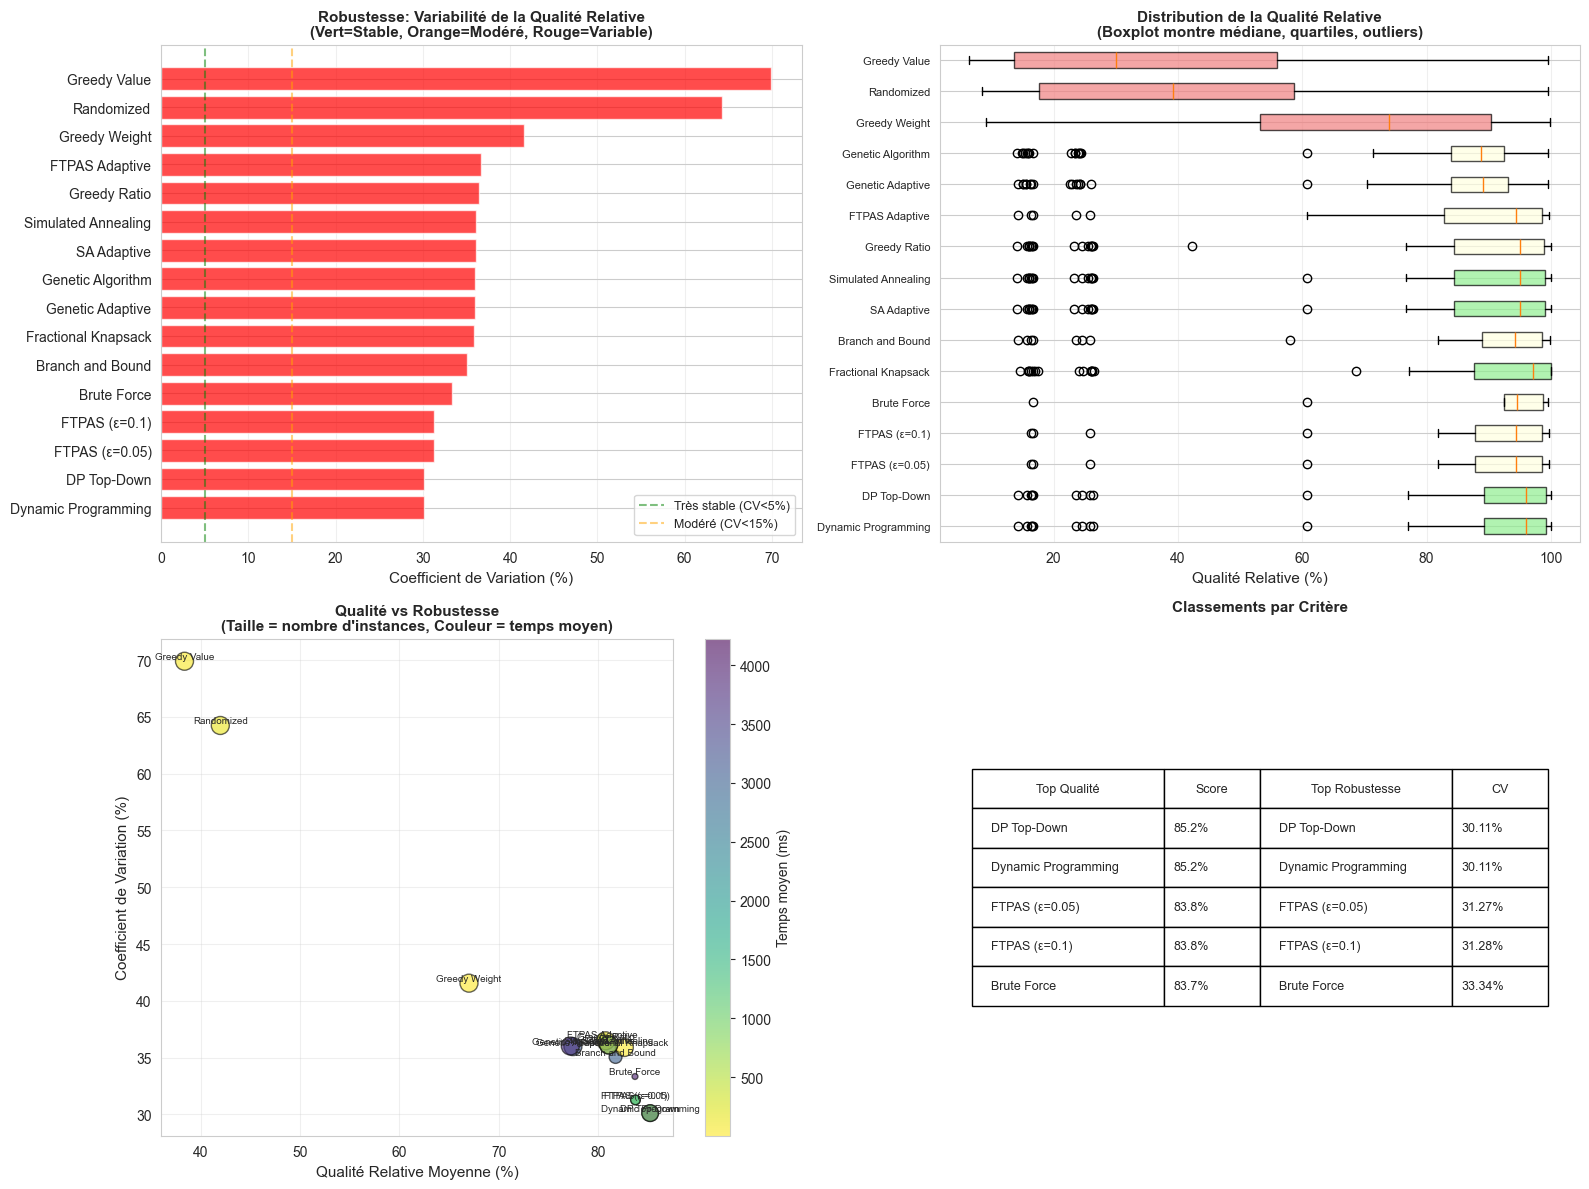


ANALYSE DE ROBUSTESSE DES ALGORITHMES

Top 5 Algorithmes les Plus Robustes (CV le plus faible):
  1. DP Top-Down               | CV: 30.11% | Qualité moyenne:  85.2%
  2. Dynamic Programming       | CV: 30.11% | Qualité moyenne:  85.2%
  3. FTPAS (ε=0.05)            | CV: 31.27% | Qualité moyenne:  83.8%
  4. FTPAS (ε=0.1)             | CV: 31.28% | Qualité moyenne:  83.8%
  5. Brute Force               | CV: 33.34% | Qualité moyenne:  83.7%

Top 5 Algorithmes les Moins Robustes (CV le plus élevé):
  1. Greedy Value              | CV: 69.90% | Qualité moyenne:  38.4%
  2. Randomized                | CV: 64.24% | Qualité moyenne:  42.0%
  3. Greedy Weight             | CV: 41.55% | Qualité moyenne:  67.0%
  4. FTPAS Adaptive            | CV: 36.65% | Qualité moyenne:  80.4%
  5. Greedy Ratio              | CV: 36.48% | Qualité moyenne:  80.8%


In [51]:
if results_df is not None:
    df = results_df.copy()
    
    # Calculer le coefficient de variation (CV = std/mean) pour mesurer la robustesse
    # Un CV faible = performances stables, un CV élevé = performances variables
    
    algo_stats = df.groupby('algorithm').agg({
        'value': ['mean', 'std', 'min', 'max'],
        'time_ms': ['mean', 'std'],
        'n': 'count'
    }).reset_index()
    
    algo_stats.columns = ['algorithm', 'value_mean', 'value_std', 'value_min', 'value_max', 
                          'time_mean', 'time_std', 'count']
    
    algo_stats['value_cv'] = (algo_stats['value_std'] / algo_stats['value_mean']) * 100
    algo_stats['time_cv'] = (algo_stats['time_std'] / algo_stats['time_mean']) * 100
    algo_stats['value_range'] = algo_stats['value_max'] - algo_stats['value_min']
    algo_stats['value_range_pct'] = (algo_stats['value_range'] / algo_stats['value_mean']) * 100
    
    # Normaliser la qualité relative pour comparer
    df['max_value_per_instance'] = df.groupby(['n', 'correlation'])['value'].transform('max')
    df['relative_quality'] = (df['value'] / df['max_value_per_instance']) * 100
    
    relative_stats = df.groupby('algorithm')['relative_quality'].agg(['mean', 'std', 'min']).reset_index()
    relative_stats['relative_cv'] = (relative_stats['std'] / relative_stats['mean']) * 100
    
    # FIX: Renommer les colonnes correctement
    relative_stats.columns = ['algorithm', 'relative_quality', 'relative_std', 'relative_min', 'relative_cv']
    
    algo_stats = algo_stats.merge(relative_stats[['algorithm', 'relative_quality', 'relative_cv']], 
                                  on='algorithm', how='left')
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Coefficient de variation de la valeur (robustesse)
    ax1 = axes[0, 0]
    algo_stats_sorted = algo_stats.sort_values('relative_cv')
    colors = ['green' if cv < 5 else 'orange' if cv < 15 else 'red' for cv in algo_stats_sorted['relative_cv']]
    bars1 = ax1.barh(algo_stats_sorted['algorithm'], algo_stats_sorted['relative_cv'], color=colors, alpha=0.7)
    ax1.set_xlabel('Coefficient de Variation (%)', fontsize=11)
    ax1.set_title('Robustesse: Variabilité de la Qualité Relative\n(Vert=Stable, Orange=Modéré, Rouge=Variable)', 
                 fontsize=11, fontweight='bold')
    ax1.axvline(x=5, color='green', linestyle='--', alpha=0.5, label='Très stable (CV<5%)')
    ax1.axvline(x=15, color='orange', linestyle='--', alpha=0.5, label='Modéré (CV<15%)')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # 2. Boxplot de la qualité relative par algorithme
    ax2 = axes[0, 1]
    algo_order = algo_stats.sort_values('relative_quality', ascending=False)['algorithm'].tolist()
    df_plot = df[df['algorithm'].isin(algo_order)].copy()
    df_plot['algorithm'] = pd.Categorical(df_plot['algorithm'], categories=algo_order)
    
    box_data = [df_plot[df_plot['algorithm'] == algo]['relative_quality'].values 
                for algo in algo_order if algo in df_plot['algorithm'].values]
    bp = ax2.boxplot(box_data, labels=[a for a in algo_order if a in df_plot['algorithm'].values],
                    vert=False, patch_artist=True)
    
    # Colorier les boxplots selon la médiane
    for patch, algo in zip(bp['boxes'], [a for a in algo_order if a in df_plot['algorithm'].values]):
        median_val = df_plot[df_plot['algorithm'] == algo]['relative_quality'].median()
        patch.set_facecolor('lightgreen' if median_val > 95 else 'lightyellow' if median_val > 85 else 'lightcoral')
        patch.set_alpha(0.7)
    
    ax2.set_xlabel('Qualité Relative (%)', fontsize=11)
    ax2.set_title('Distribution de la Qualité Relative\n(Boxplot montre médiane, quartiles, outliers)', 
                 fontsize=11, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='x')
    plt.setp(ax2.get_yticklabels(), fontsize=8)
    
    # 3. Scatter: Qualité moyenne vs Robustesse (CV)
    ax3 = axes[1, 0]
    scatter = ax3.scatter(algo_stats['relative_quality'], algo_stats['relative_cv'],
                         s=algo_stats['count']*2, alpha=0.6, c=algo_stats['time_mean'],
                         cmap='viridis_r', edgecolors='black', linewidth=1)
    
    for _, row in algo_stats.iterrows():
        ax3.annotate(row['algorithm'], 
                    (row['relative_quality'], row['relative_cv']),
                    fontsize=7, ha='center', va='bottom')
    
    ax3.set_xlabel('Qualité Relative Moyenne (%)', fontsize=11)
    ax3.set_ylabel('Coefficient de Variation (%)', fontsize=11)
    ax3.set_title('Qualité vs Robustesse\n(Taille = nombre d\'instances, Couleur = temps moyen)', 
                 fontsize=11, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax3, label='Temps moyen (ms)')
    
    # 4. Tableau des meilleurs algorithmes par critère
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Top 5 par différents critères
    top_quality = algo_stats.nlargest(5, 'relative_quality')[['algorithm', 'relative_quality']]
    top_robust = algo_stats.nsmallest(5, 'relative_cv')[['algorithm', 'relative_cv']]
    
    table_data = []
    for i in range(5):
        row = [
            top_quality.iloc[i]['algorithm'] if i < len(top_quality) else '',
            f"{top_quality.iloc[i]['relative_quality']:.1f}%" if i < len(top_quality) else '',
            top_robust.iloc[i]['algorithm'] if i < len(top_robust) else '',
            f"{top_robust.iloc[i]['relative_cv']:.2f}%" if i < len(top_robust) else ''
        ]
        table_data.append(row)
    
    table = ax4.table(cellText=table_data,
                     colLabels=['Top Qualité', 'Score', 'Top Robustesse', 'CV'],
                     cellLoc='left',
                     loc='center',
                     colWidths=[0.3, 0.15, 0.3, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax4.set_title('Classements par Critère', fontsize=11, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Résumé statistique
    print("\n" + "="*80)
    print("ANALYSE DE ROBUSTESSE DES ALGORITHMES")
    print("="*80)
    print("\nTop 5 Algorithmes les Plus Robustes (CV le plus faible):")
    for i, (_, row) in enumerate(algo_stats.nsmallest(5, 'relative_cv').iterrows(), 1):
        print(f"  {i}. {row['algorithm']:25s} | CV: {row['relative_cv']:5.2f}% | "
              f"Qualité moyenne: {row['relative_quality']:5.1f}%")
    
    print("\nTop 5 Algorithmes les Moins Robustes (CV le plus élevé):")
    for i, (_, row) in enumerate(algo_stats.nlargest(5, 'relative_cv').iterrows(), 1):
        print(f"  {i}. {row['algorithm']:25s} | CV: {row['relative_cv']:5.2f}% | "
              f"Qualité moyenne: {row['relative_quality']:5.1f}%")
else:
    print("results_df non chargé.")

### 8.4 Question 4: Comment les algorithmes se comportent-ils face à différents types de corrélation ?

**Objectif:** Identifier quels algorithmes sont les plus sensibles ou résistants aux caractéristiques structurelles des données.


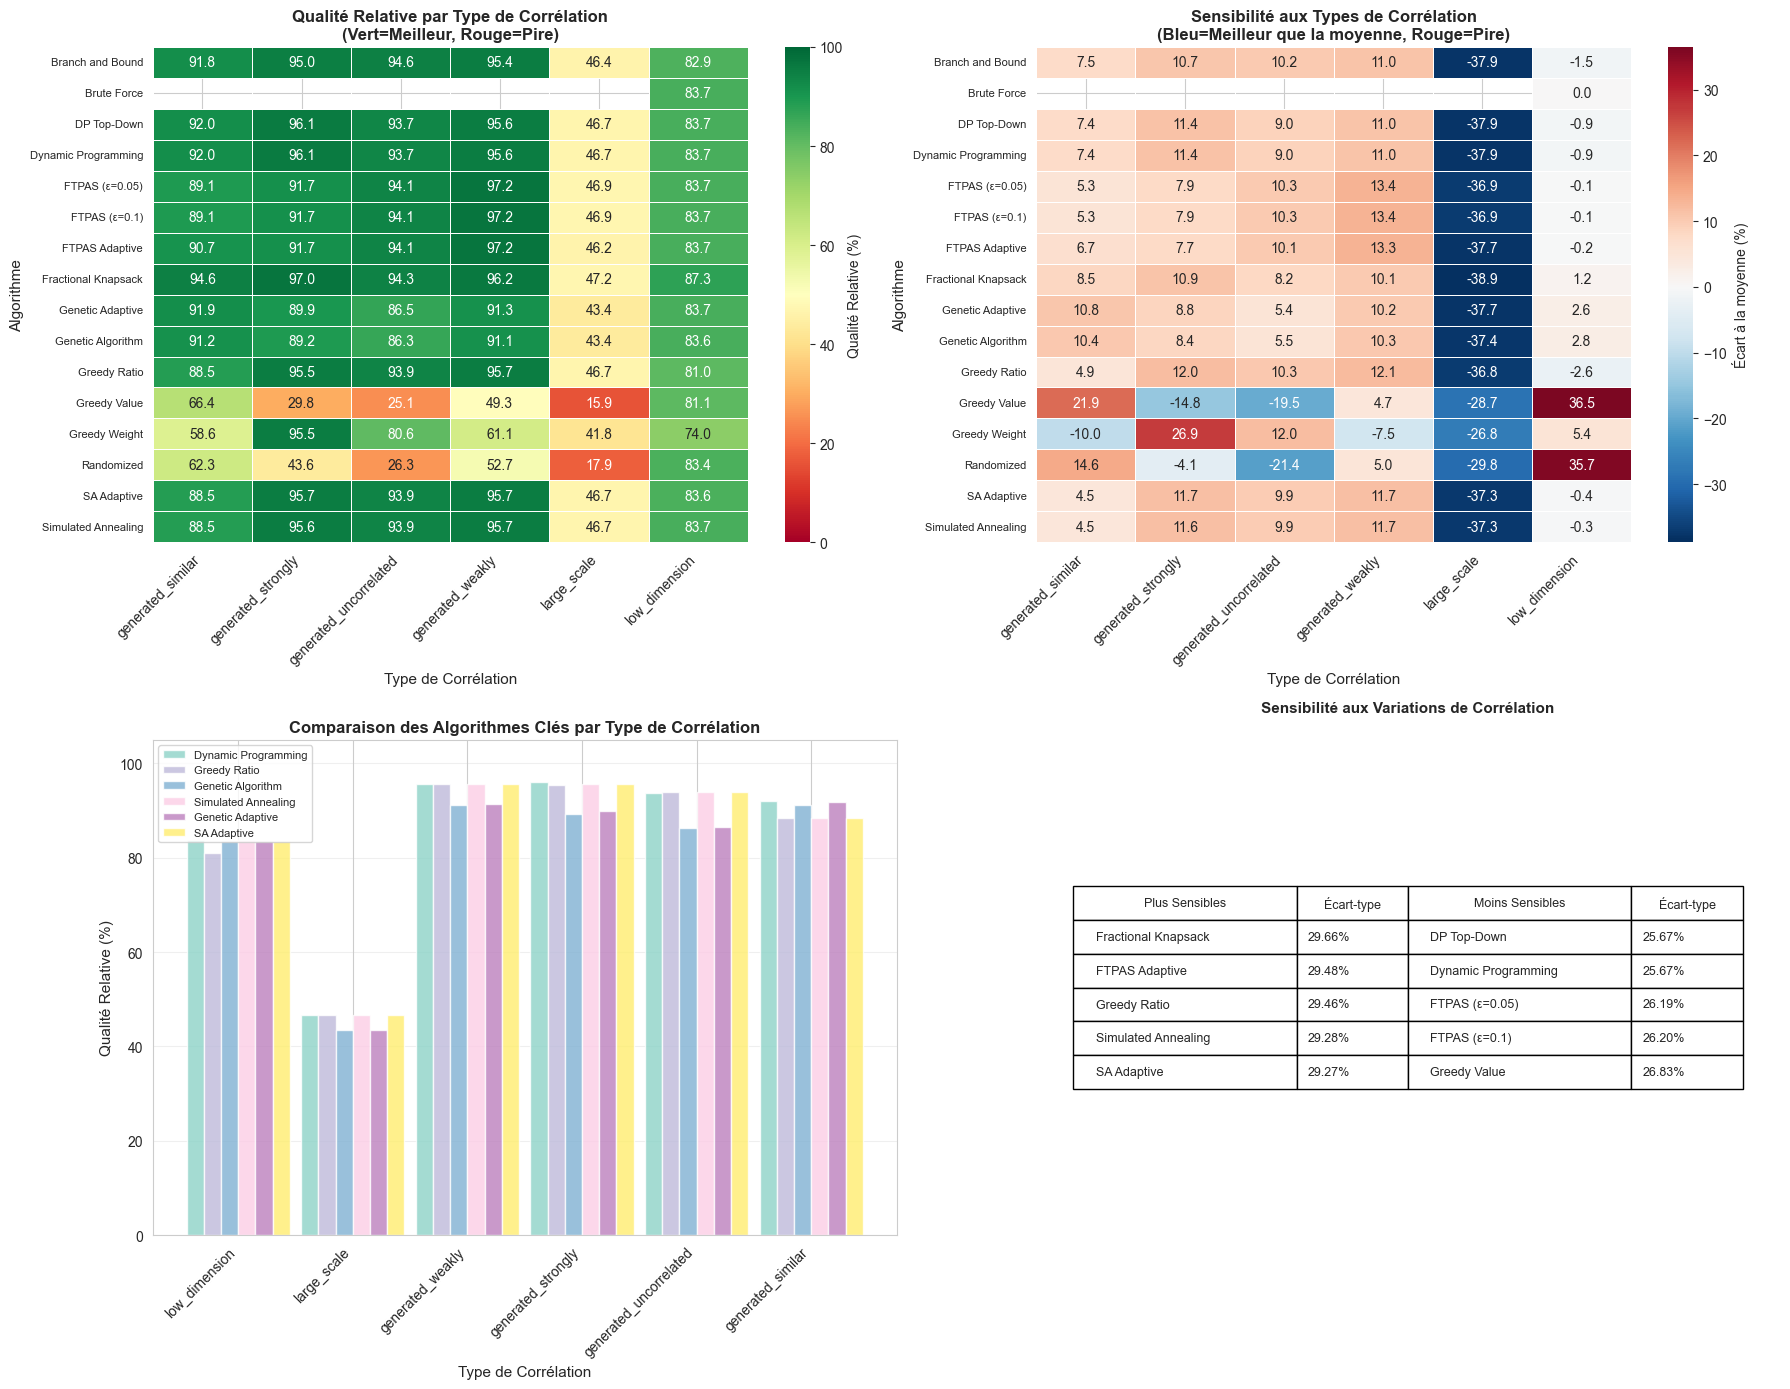


ANALYSE DE SENSIBILITÉ AUX TYPES DE CORRÉLATION

>>> LOW_DIMENSION <<<
  Top 3 algorithmes:
    1. Fractional Knapsack       | Qualité: 87.3%
    2. Brute Force               | Qualité: 83.7%
    3. DP Top-Down               | Qualité: 83.7%

>>> LARGE_SCALE <<<
  Top 3 algorithmes:
    1. Fractional Knapsack       | Qualité: 47.2%
    2. FTPAS (ε=0.05)            | Qualité: 46.9%
    3. FTPAS (ε=0.1)             | Qualité: 46.9%

>>> GENERATED_WEAKLY <<<
  Top 3 algorithmes:
    1. FTPAS (ε=0.05)            | Qualité: 97.2%
    2. FTPAS (ε=0.1)             | Qualité: 97.2%
    3. FTPAS Adaptive            | Qualité: 97.2%

>>> GENERATED_STRONGLY <<<
  Top 3 algorithmes:
    1. Fractional Knapsack       | Qualité: 97.0%
    2. DP Top-Down               | Qualité: 96.1%
    3. Dynamic Programming       | Qualité: 96.1%

>>> GENERATED_UNCORRELATED <<<
  Top 3 algorithmes:
    1. Branch and Bound          | Qualité: 94.6%
    2. Fractional Knapsack       | Qualité: 94.3%
    3. FTPAS (ε=

In [52]:
if results_df is not None:
    df = results_df.copy()
    
    # Normaliser la qualité
    df['max_value_per_instance'] = df.groupby(['n', 'correlation'])['value'].transform('max')
    df['relative_quality'] = (df['value'] / df['max_value_per_instance']) * 100
    
    # Filtrer les corrélations générées
    correlation_types = [c for c in df['correlation'].unique() 
                        if 'generated' in str(c) or c in ['low_dimension', 'large_scale']]
    
    # Calculer les performances moyennes par algorithme et corrélation
    perf_by_corr = df.groupby(['algorithm', 'correlation']).agg({
        'relative_quality': 'mean',
        'time_ms': 'mean',
        'value': 'mean'
    }).reset_index()
    
    # Pivot pour faciliter la visualisation
    pivot_quality = perf_by_corr.pivot(index='algorithm', columns='correlation', values='relative_quality')
    pivot_time = perf_by_corr.pivot(index='algorithm', columns='correlation', values='time_ms')
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Heatmap de la qualité relative
    ax1 = axes[0, 0]
    if len(pivot_quality.columns) > 0:
        sns.heatmap(pivot_quality, annot=True, fmt='.1f', cmap='RdYlGn', 
                   cbar_kws={'label': 'Qualité Relative (%)'},
                   linewidths=0.5, ax=ax1, vmin=0, vmax=100)
        ax1.set_title('Qualité Relative par Type de Corrélation\n(Vert=Meilleur, Rouge=Pire)', 
                     fontsize=12, fontweight='bold')
        ax1.set_xlabel('Type de Corrélation', fontsize=11)
        ax1.set_ylabel('Algorithme', fontsize=11)
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax1.get_yticklabels(), fontsize=8)
    
    # 2. Écart de performance par rapport à la moyenne
    ax2 = axes[0, 1]
    if len(pivot_quality.columns) > 0:
        # Calculer l'écart par rapport à la moyenne de chaque algorithme
        pivot_quality_centered = pivot_quality.sub(pivot_quality.mean(axis=1), axis=0)
        sns.heatmap(pivot_quality_centered, annot=True, fmt='.1f', cmap='RdBu_r', 
                   center=0, cbar_kws={'label': 'Écart à la moyenne (%)'},
                   linewidths=0.5, ax=ax2)
        ax2.set_title('Sensibilité aux Types de Corrélation\n(Bleu=Meilleur que la moyenne, Rouge=Pire)', 
                     fontsize=12, fontweight='bold')
        ax2.set_xlabel('Type de Corrélation', fontsize=11)
        ax2.set_ylabel('Algorithme', fontsize=11)
        plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')
        plt.setp(ax2.get_yticklabels(), fontsize=8)
    
    # 3. Graphique en barres groupées pour quelques algorithmes clés
    ax3 = axes[1, 0]
    key_algos = ['Dynamic Programming', 'Greedy Ratio', 'Genetic Algorithm', 
                'Simulated Annealing', 'Genetic Adaptive', 'SA Adaptive']
    key_algos = [a for a in key_algos if a in pivot_quality.index]
    
    if len(key_algos) > 0:
        x = np.arange(len(correlation_types))
        width = 0.15
        colors_map = plt.cm.Set3(np.linspace(0, 1, len(key_algos)))
        
        for i, algo in enumerate(key_algos[:6]):
            values = [pivot_quality.loc[algo, corr] if corr in pivot_quality.columns else 0 
                     for corr in correlation_types]
            ax3.bar(x + i*width, values, width, label=algo, color=colors_map[i], alpha=0.8)
        
        ax3.set_xlabel('Type de Corrélation', fontsize=11)
        ax3.set_ylabel('Qualité Relative (%)', fontsize=11)
        ax3.set_title('Comparaison des Algorithmes Clés par Type de Corrélation', 
                     fontsize=12, fontweight='bold')
        ax3.set_xticks(x + width * (len(key_algos)-1) / 2)
        ax3.set_xticklabels(correlation_types, rotation=45, ha='right')
        ax3.legend(fontsize=8, loc='upper left')
        ax3.grid(True, alpha=0.3, axis='y')
        ax3.set_ylim(0, 105)
    
    # 4. Analyse de variance (ANOVA) pour identifier les algorithmes les plus sensibles
    ax4 = axes[1, 1]
    ax4.axis('off')
    
    # Calculer l'écart-type de la qualité relative par algorithme (mesure de sensibilité)
    sensitivity = df.groupby('algorithm')['relative_quality'].agg(['mean', 'std']).reset_index()
    sensitivity.columns = ['algorithm', 'mean_quality', 'std_quality']
    sensitivity = sensitivity.sort_values('std_quality', ascending=False)
    
    # Tableau des algorithmes les plus et moins sensibles
    table_data = []
    most_sensitive = sensitivity.nlargest(5, 'std_quality')
    least_sensitive = sensitivity.nsmallest(5, 'std_quality')
    
    for i in range(5):
        row = [
            most_sensitive.iloc[i]['algorithm'] if i < len(most_sensitive) else '',
            f"{most_sensitive.iloc[i]['std_quality']:.2f}%" if i < len(most_sensitive) else '',
            least_sensitive.iloc[i]['algorithm'] if i < len(least_sensitive) else '',
            f"{least_sensitive.iloc[i]['std_quality']:.2f}%" if i < len(least_sensitive) else ''
        ]
        table_data.append(row)
    
    table = ax4.table(cellText=table_data,
                     colLabels=['Plus Sensibles', 'Écart-type', 'Moins Sensibles', 'Écart-type'],
                     cellLoc='left',
                     loc='center',
                     colWidths=[0.3, 0.15, 0.3, 0.15])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax4.set_title('Sensibilité aux Variations de Corrélation', fontsize=11, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Analyse statistique détaillée
    print("\n" + "="*80)
    print("ANALYSE DE SENSIBILITÉ AUX TYPES DE CORRÉLATION")
    print("="*80)
    
    for corr_type in correlation_types[:5]:  # Limiter à 5 pour la lisibilité
        print(f"\n>>> {corr_type.upper()} <<<")
        corr_data = df[df['correlation'] == corr_type]
        if len(corr_data) == 0:
            continue
        
        top_algos = corr_data.groupby('algorithm')['relative_quality'].mean().nlargest(3)
        print("  Top 3 algorithmes:")
        for i, (algo, score) in enumerate(top_algos.items(), 1):
            print(f"    {i}. {algo:25s} | Qualité: {score:.1f}%")
else:
    print("results_df non chargé.")


### 8.5 Question 5: Analyse de convergence des métaheuristiques (Simulated Annealing et Genetic Algorithm)

**Objectif:** Comprendre comment les algorithmes métaheuristiques convergent vers leur solution et identifier les paramètres optimaux.


/var/folders/my/kkvcbml94_96ry9m6ps6wcr00000gn/T/ipykernel_5742/1246799839.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  algo_data['efficiency'] = algo_data['relative_quality'] / np.log1p(algo_data['time_ms'])
/var/folders/my/kkvcbml94_96ry9m6ps6wcr00000gn/T/ipykernel_5742/1246799839.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  algo_data['efficiency'] = algo_data['relative_quality'] / np.log1p(algo_data['time_ms'])
/var/folders/my/kkvcbml94_96ry9m6ps6wcr00000gn/T/ipykernel_5742/1246799839.py:

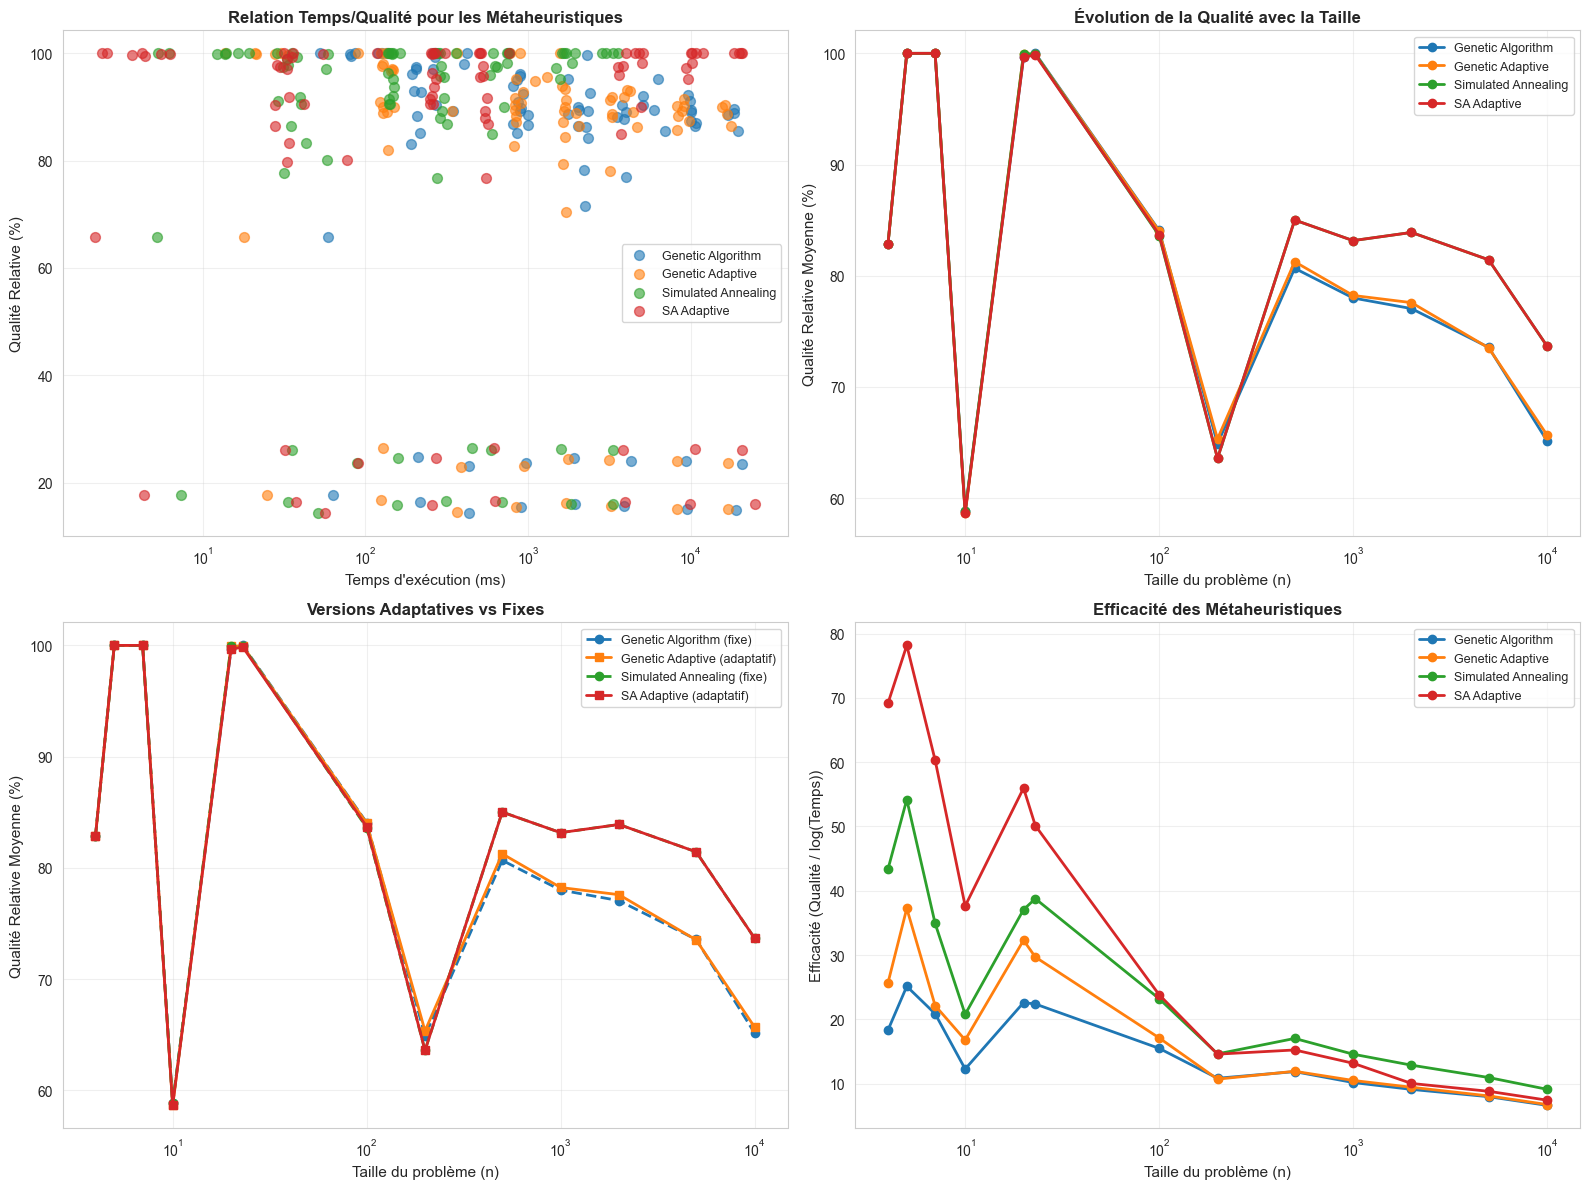


ANALYSE DES MÉTAHEURISTIQUES

Genetic Algorithm:
  Qualité moyenne: 78.18% ± 28.24%
  Temps moyen: 3667.58ms ± 5218.47ms
  Efficacité moyenne: 11.80
  Nombre d'instances: 84

Genetic Adaptive:
  Qualité moyenne: 78.45% ± 28.30%
  Temps moyen: 3139.45ms ± 4587.07ms
  Efficacité moyenne: 12.98
  Nombre d'instances: 84

Simulated Annealing:
  Qualité moyenne: 82.04% ± 29.58%
  Temps moyen: 597.75ms ± 896.06ms
  Efficacité moyenne: 17.89
  Nombre d'instances: 84

SA Adaptive:
  Qualité moyenne: 82.05% ± 29.56%
  Temps moyen: 3341.14ms ± 5867.00ms
  Efficacité moyenne: 18.89
  Nombre d'instances: 84


In [53]:
# Fonction pour tracer la convergence (nécessite de modifier les algorithmes pour retourner l'historique)
# Pour cette analyse, nous utiliserons les données disponibles et créerons des analyses basées sur les résultats

if results_df is not None:
    df = results_df.copy()
    
    # Analyser la relation entre temps d'exécution et qualité pour les métaheuristiques
    metaheuristics = ['Genetic Algorithm', 'Genetic Adaptive', 'Simulated Annealing', 'SA Adaptive']
    meta_data = df[df['algorithm'].isin(metaheuristics)].copy()
    
    if len(meta_data) > 0:
        # Normaliser la qualité
        meta_data['max_value_per_instance'] = meta_data.groupby(['n', 'correlation'])['value'].transform('max')
        meta_data['relative_quality'] = (meta_data['value'] / meta_data['max_value_per_instance']) * 100
        
        fig, axes = plt.subplots(2, 2, figsize=(16, 12))
        
        # 1. Temps vs Qualité pour les métaheuristiques
        ax1 = axes[0, 0]
        for algo in metaheuristics:
            algo_data = meta_data[meta_data['algorithm'] == algo]
            if len(algo_data) > 0:
                ax1.scatter(algo_data['time_ms'], algo_data['relative_quality'], 
                           label=algo, alpha=0.6, s=50)
        
        ax1.set_xlabel('Temps d\'exécution (ms)', fontsize=11)
        ax1.set_ylabel('Qualité Relative (%)', fontsize=11)
        ax1.set_title('Relation Temps/Qualité pour les Métaheuristiques', 
                     fontsize=12, fontweight='bold')
        ax1.set_xscale('log')
        ax1.legend(fontsize=9)
        ax1.grid(True, alpha=0.3)
        
        # 2. Qualité par taille de problème
        ax2 = axes[0, 1]
        for algo in metaheuristics:
            algo_data = meta_data[meta_data['algorithm'] == algo]
            if len(algo_data) > 0:
                agg = algo_data.groupby('n')['relative_quality'].mean().reset_index()
                agg = agg.sort_values('n')
                ax2.plot(agg['n'], agg['relative_quality'], 'o-', label=algo, linewidth=2, markersize=6)
        
        ax2.set_xlabel('Taille du problème (n)', fontsize=11)
        ax2.set_ylabel('Qualité Relative Moyenne (%)', fontsize=11)
        ax2.set_title('Évolution de la Qualité avec la Taille', 
                     fontsize=12, fontweight='bold')
        ax2.set_xscale('log')
        ax2.legend(fontsize=9)
        ax2.grid(True, alpha=0.3)
        
        # 3. Comparaison Adaptatif vs Non-adaptatif
        ax3 = axes[1, 0]
        comparison_pairs = [
            ('Genetic Algorithm', 'Genetic Adaptive'),
            ('Simulated Annealing', 'SA Adaptive')
        ]
        
        for fixed, adaptive in comparison_pairs:
            if fixed in meta_data['algorithm'].values and adaptive in meta_data['algorithm'].values:
                fixed_data = meta_data[meta_data['algorithm'] == fixed]
                adaptive_data = meta_data[meta_data['algorithm'] == adaptive]
                
                # Grouper par taille
                fixed_agg = fixed_data.groupby('n')['relative_quality'].mean().reset_index()
                adaptive_agg = adaptive_data.groupby('n')['relative_quality'].mean().reset_index()
                
                ax3.plot(fixed_agg['n'], fixed_agg['relative_quality'], 
                        'o--', label=f'{fixed} (fixe)', linewidth=2, markersize=6)
                ax3.plot(adaptive_agg['n'], adaptive_agg['relative_quality'], 
                        's-', label=f'{adaptive} (adaptatif)', linewidth=2, markersize=6)
        
        ax3.set_xlabel('Taille du problème (n)', fontsize=11)
        ax3.set_ylabel('Qualité Relative Moyenne (%)', fontsize=11)
        ax3.set_title('Versions Adaptatives vs Fixes', 
                     fontsize=12, fontweight='bold')
        ax3.set_xscale('log')
        ax3.legend(fontsize=9)
        ax3.grid(True, alpha=0.3)
        
        # 4. Efficacité (qualité/temps) par taille
        ax4 = axes[1, 1]
        for algo in metaheuristics:
            algo_data = meta_data[meta_data['algorithm'] == algo]
            if len(algo_data) > 0:
                algo_data['efficiency'] = algo_data['relative_quality'] / np.log1p(algo_data['time_ms'])
                agg = algo_data.groupby('n')['efficiency'].mean().reset_index()
                agg = agg.sort_values('n')
                ax4.plot(agg['n'], agg['efficiency'], 'o-', label=algo, linewidth=2, markersize=6)
        
        ax4.set_xlabel('Taille du problème (n)', fontsize=11)
        ax4.set_ylabel('Efficacité (Qualité / log(Temps))', fontsize=11)
        ax4.set_title('Efficacité des Métaheuristiques', 
                     fontsize=12, fontweight='bold')
        ax4.set_xscale('log')
        ax4.legend(fontsize=9)
        ax4.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Analyse statistique
        print("\n" + "="*80)
        print("ANALYSE DES MÉTAHEURISTIQUES")
        print("="*80)
        
        for algo in metaheuristics:
            algo_data = meta_data[meta_data['algorithm'] == algo]
            if len(algo_data) > 0:
                print(f"\n{algo}:")
                print(f"  Qualité moyenne: {algo_data['relative_quality'].mean():.2f}% ± {algo_data['relative_quality'].std():.2f}%")
                print(f"  Temps moyen: {algo_data['time_ms'].mean():.2f}ms ± {algo_data['time_ms'].std():.2f}ms")
                print(f"  Efficacité moyenne: {(algo_data['relative_quality'] / np.log1p(algo_data['time_ms'])).mean():.2f}")
                print(f"  Nombre d'instances: {len(algo_data)}")
    else:
        print("Pas de données pour les métaheuristiques.")
else:
    print("results_df non chargé.")


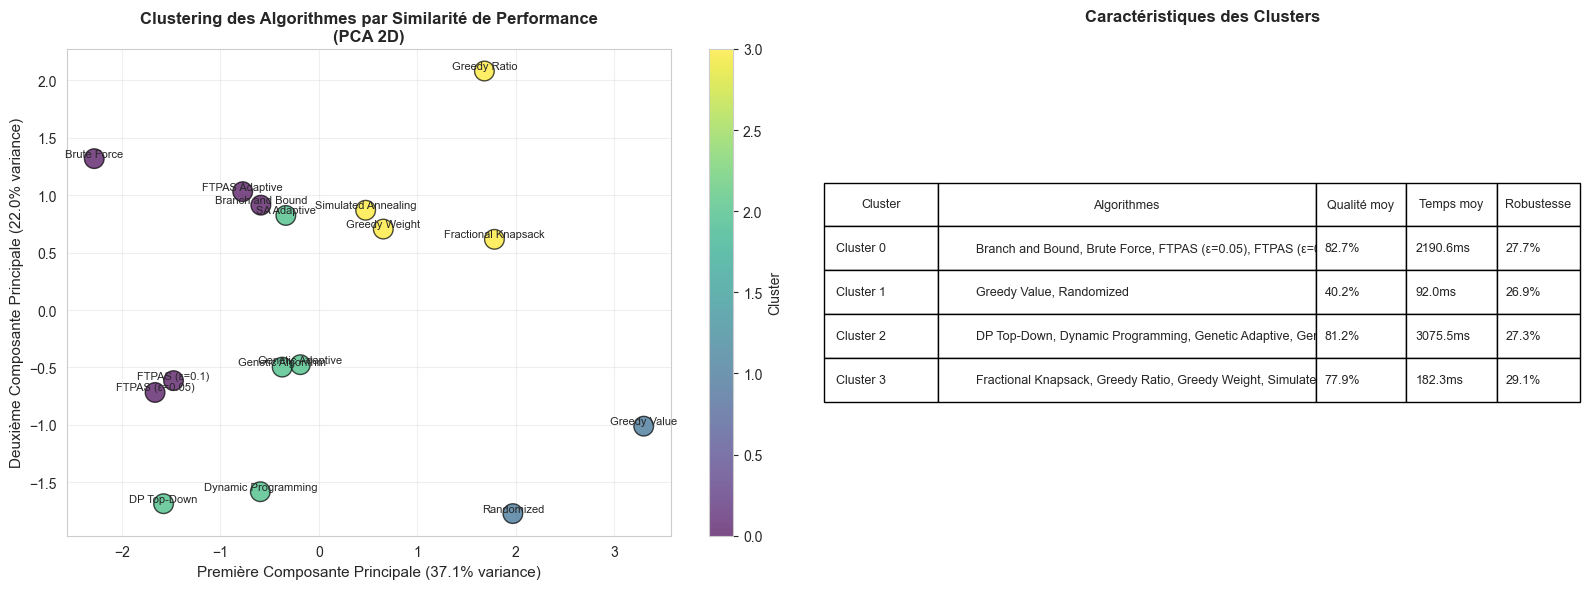


CLUSTERING DES ALGORITHMES PAR SIMILARITÉ DE PERFORMANCE

>>> CLUSTER 0 (5 algorithmes) <<<
Algorithmes: Branch and Bound, Brute Force, FTPAS (ε=0.05), FTPAS (ε=0.1), FTPAS Adaptive
  Qualité relative moyenne: 82.68%
  Temps moyen: 2190.59ms
  Robustesse (écart-type): 27.69%
  Scalabilité (n_max - n_min): 181

>>> CLUSTER 1 (2 algorithmes) <<<
Algorithmes: Greedy Value, Randomized
  Qualité relative moyenne: 40.18%
  Temps moyen: 92.02ms
  Robustesse (écart-type): 26.90%
  Scalabilité (n_max - n_min): 9996

>>> CLUSTER 2 (5 algorithmes) <<<
Algorithmes: DP Top-Down, Dynamic Programming, Genetic Adaptive, Genetic Algorithm, SA Adaptive
  Qualité relative moyenne: 81.24%
  Temps moyen: 3075.54ms
  Robustesse (écart-type): 27.25%
  Scalabilité (n_max - n_min): 7996

>>> CLUSTER 3 (4 algorithmes) <<<
Algorithmes: Fractional Knapsack, Greedy Ratio, Greedy Weight, Simulated Annealing
  Qualité relative moyenne: 77.86%
  Temps moyen: 182.30ms
  Robustesse (écart-type): 29.06%
  Scalabilité (

In [54]:
if results_df is not None:
    from sklearn.cluster import KMeans
    from sklearn.preprocessing import StandardScaler
    from sklearn.decomposition import PCA
    import warnings
    warnings.filterwarnings('ignore')
    
    df = results_df.copy()
    
    # Préparer les données pour le clustering
    # Caractéristiques par algorithme: qualité moyenne, temps moyen, robustesse, etc.
    algo_features = df.groupby('algorithm').agg({
        'value': ['mean', 'std'],
        'time_ms': ['mean', 'std'],
        'n': ['min', 'max', 'mean'],
        'usage_percent': 'mean'
    }).reset_index()
    
    algo_features.columns = ['algorithm', 'value_mean', 'value_std', 'time_mean', 'time_std',
                            'n_min', 'n_max', 'n_mean', 'usage_mean']
    
    # Normaliser la qualité relative
    df['max_value_per_instance'] = df.groupby(['n', 'correlation'])['value'].transform('max')
    df['relative_quality'] = (df['value'] / df['max_value_per_instance']) * 100
    
    relative_stats = df.groupby('algorithm')['relative_quality'].agg(['mean', 'std']).reset_index()
    relative_stats.columns = ['algorithm', 'relative_quality_mean', 'relative_quality_std']
    
    algo_features = algo_features.merge(relative_stats, on='algorithm')
    
    # Ajouter des métriques dérivées
    algo_features['value_cv'] = (algo_features['value_std'] / algo_features['value_mean']) * 100
    algo_features['time_cv'] = (algo_features['time_std'] / algo_features['time_mean']) * 100
    algo_features['scalability'] = algo_features['n_max'] - algo_features['n_min']
    
    # Sélectionner les features pour le clustering
    feature_cols = ['relative_quality_mean', 'relative_quality_std', 'time_mean', 
                   'time_cv', 'scalability', 'usage_mean']
    X = algo_features[feature_cols].values
    
    # Standardiser
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Clustering K-means
    n_clusters = 4
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(X_scaled)
    algo_features['cluster'] = clusters
    
    # Visualisation avec PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # 1. Clustering en 2D (PCA)
    ax1 = axes[0]
    scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', 
                         s=200, alpha=0.7, edgecolors='black', linewidth=1)
    
    for i, algo in enumerate(algo_features['algorithm']):
        ax1.annotate(algo, (X_pca[i, 0], X_pca[i, 1]), fontsize=8, ha='center', va='bottom')
    
    ax1.set_xlabel(f'Première Composante Principale ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=11)
    ax1.set_ylabel(f'Deuxième Composante Principale ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=11)
    ax1.set_title('Clustering des Algorithmes par Similarité de Performance\n(PCA 2D)', 
                fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax1, label='Cluster')
    
    # 2. Caractéristiques des clusters
    ax2 = axes[1]
    ax2.axis('off')
    
    cluster_summary = []
    for cluster_id in range(n_clusters):
        cluster_algos = algo_features[algo_features['cluster'] == cluster_id]
        cluster_summary.append({
            'Cluster': f'Cluster {cluster_id}',
            'Algorithmes': ', '.join(cluster_algos['algorithm'].tolist()),
            'Qualité moy': f"{cluster_algos['relative_quality_mean'].mean():.1f}%",
            'Temps moy': f"{cluster_algos['time_mean'].mean():.1f}ms",
            'Robustesse': f"{cluster_algos['relative_quality_std'].mean():.1f}%"
        })
    
    cluster_df = pd.DataFrame(cluster_summary)
    
    table = ax2.table(cellText=cluster_df.values,
                     colLabels=cluster_df.columns,
                     cellLoc='left',
                     loc='center',
                     colWidths=[0.15, 0.5, 0.12, 0.12, 0.11])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2.5)
    ax2.set_title('Caractéristiques des Clusters', fontsize=12, fontweight='bold', pad=20)
    
    plt.tight_layout()
    plt.show()
    
    # Analyse détaillée des clusters
    print("\n" + "="*80)
    print("CLUSTERING DES ALGORITHMES PAR SIMILARITÉ DE PERFORMANCE")
    print("="*80)
    
    for cluster_id in range(n_clusters):
        cluster_algos = algo_features[algo_features['cluster'] == cluster_id]
        print(f"\n>>> CLUSTER {cluster_id} ({len(cluster_algos)} algorithmes) <<<")
        print(f"Algorithmes: {', '.join(cluster_algos['algorithm'].tolist())}")
        print(f"  Qualité relative moyenne: {cluster_algos['relative_quality_mean'].mean():.2f}%")
        print(f"  Temps moyen: {cluster_algos['time_mean'].mean():.2f}ms")
        print(f"  Robustesse (écart-type): {cluster_algos['relative_quality_std'].mean():.2f}%")
        print(f"  Scalabilité (n_max - n_min): {cluster_algos['scalability'].mean():.0f}")
    
    # Interprétation
    print("\n" + "="*80)
    print("INTERPRÉTATION DES CLUSTERS:")
    print("="*80)
    print("Les algorithmes sont regroupés selon leurs caractéristiques de performance similaires.")
    print("Cela permet d'identifier des familles d'algorithmes avec des comportements comparables.")
else:
    print("results_df non chargé.")


### 8.7 Question 7: Analyse de régression - Prédire la performance selon la taille du problème

**Objectif:** Utiliser la régression pour modéliser l'évolution de la performance et identifier les tendances de scalabilité.


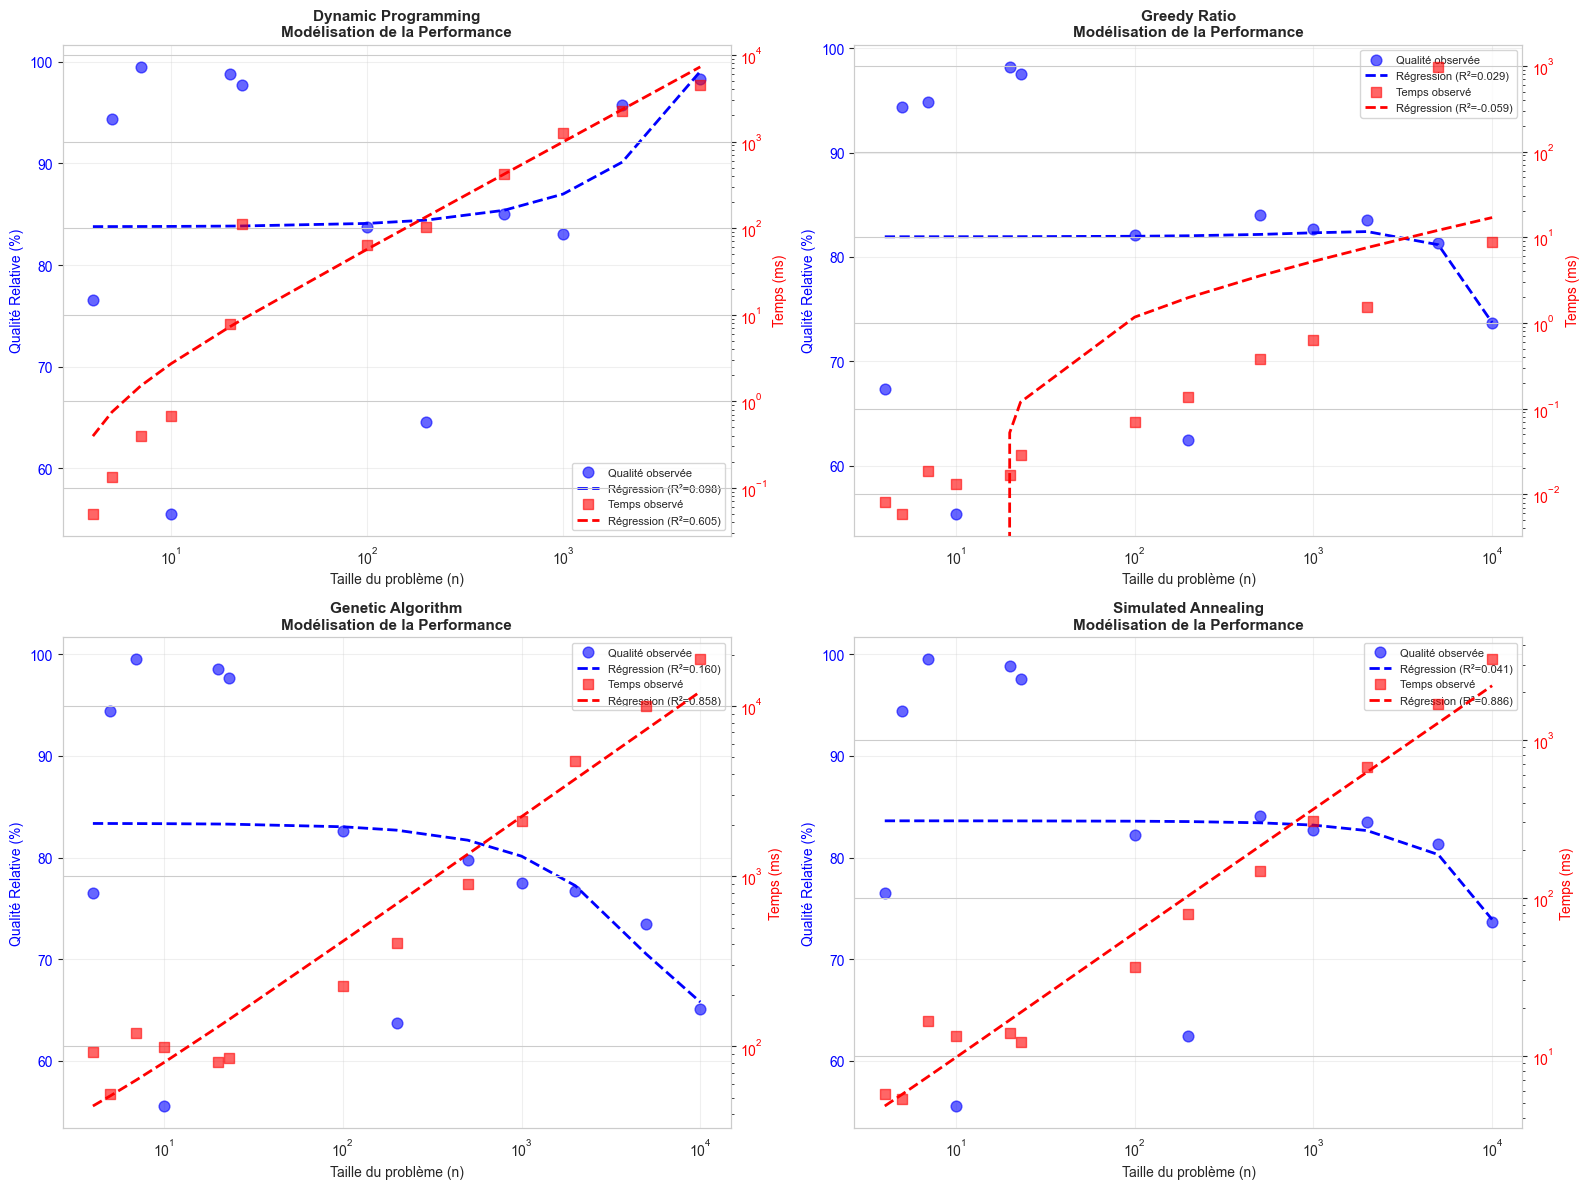


ANALYSE DE RÉGRESSION - MODÉLISATION DE LA PERFORMANCE

Dynamic Programming:
  Qualité: R² = 0.098 (tendance: croissant)
  Temps: R² = 0.605 (complexité estimée: O(n^1.24))

Greedy Ratio:
  Qualité: R² = 0.029 (tendance: croissant)
  Temps: R² = -0.059 (complexité estimée: O(n^0.46))

Genetic Algorithm:
  Qualité: R² = 0.160 (tendance: décroissant)
  Temps: R² = 0.858 (complexité estimée: O(n^0.73))

Simulated Annealing:
  Qualité: R² = 0.041 (tendance: décroissant)
  Temps: R² = 0.886 (complexité estimée: O(n^0.78))

INTERPRÉTATION:
R² proche de 1 = modèle prédit bien les données
R² < 0.5 = modèle peu fiable, performances variables
La complexité estimée donne une idée de la scalabilité de l'algorithme


In [55]:
if results_df is not None:
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.metrics import r2_score
    import warnings
    warnings.filterwarnings('ignore')
    
    df = results_df.copy()
    
    # Normaliser la qualité
    df['max_value_per_instance'] = df.groupby(['n', 'correlation'])['value'].transform('max')
    df['relative_quality'] = (df['value'] / df['max_value_per_instance']) * 100
    
    # Sélectionner quelques algorithmes représentatifs
    key_algos = ['Dynamic Programming', 'Greedy Ratio', 'Genetic Algorithm', 
                'Simulated Annealing', 'Branch and Bound']
    key_algos = [a for a in key_algos if a in df['algorithm'].values]
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    regression_results = []
    
    for idx, algo in enumerate(key_algos[:4]):
        ax = axes[idx]
        algo_data = df[df['algorithm'] == algo].copy()
        
        if len(algo_data) == 0:
            continue
        
        # Grouper par taille
        grouped = algo_data.groupby('n').agg({
            'relative_quality': 'mean',
            'time_ms': 'mean'
        }).reset_index().sort_values('n')
        
        X = grouped['n'].values.reshape(-1, 1)
        y_quality = grouped['relative_quality'].values
        y_time = grouped['time_ms'].values
        
        # Régression polynomiale pour la qualité
        poly_features = PolynomialFeatures(degree=2)
        X_poly = poly_features.fit_transform(X)
        
        reg_quality = LinearRegression()
        reg_quality.fit(X_poly, y_quality)
        y_pred_quality = reg_quality.predict(X_poly)
        r2_quality = r2_score(y_quality, y_pred_quality)
        
        # Régression pour le temps (log-log)
        X_log = np.log1p(X)
        y_log = np.log1p(y_time)
        reg_time = LinearRegression()
        reg_time.fit(X_log, y_log)
        y_pred_time = np.expm1(reg_time.predict(X_log))
        r2_time = r2_score(y_time, y_pred_time)
        
        # Visualisation
        ax2 = ax.twinx()
        
        # Qualité
        ax.scatter(grouped['n'], grouped['relative_quality'], color='blue', 
                  alpha=0.6, s=60, label='Qualité observée', zorder=3)
        ax.plot(grouped['n'], y_pred_quality, 'b--', linewidth=2, 
               label=f'Régression (R²={r2_quality:.3f})', zorder=2)
        ax.set_xlabel('Taille du problème (n)', fontsize=10)
        ax.set_ylabel('Qualité Relative (%)', fontsize=10, color='blue')
        ax.tick_params(axis='y', labelcolor='blue')
        ax.set_xscale('log')
        
        # Temps
        ax2.scatter(grouped['n'], grouped['time_ms'], color='red', 
                   alpha=0.6, s=60, marker='s', label='Temps observé', zorder=3)
        ax2.plot(grouped['n'], y_pred_time, 'r--', linewidth=2, 
                label=f'Régression (R²={r2_time:.3f})', zorder=2)
        ax2.set_ylabel('Temps (ms)', fontsize=10, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        ax2.set_yscale('log')
        
        ax.set_title(f'{algo}\nModélisation de la Performance', 
                    fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        
        # Légende combinée
        lines1, labels1 = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines1 + lines2, labels1 + labels2, loc='best', fontsize=8)
        
        # Stocker les résultats
        # Pour reg_quality: coef_[1] est le coefficient linéaire (après PolynomialFeatures degree=2)
        # Pour reg_time: coef_[0] est le coefficient (régression log-log avec une seule feature)
        quality_trend_coef = reg_quality.coef_[1] if len(reg_quality.coef_) > 1 else reg_quality.coef_[0]
        time_coef = float(reg_time.coef_[0])  # Convertir en float pour éviter les problèmes d'indexation
        
        regression_results.append({
            'algorithm': algo,
            'quality_r2': r2_quality,
            'time_r2': r2_time,
            'quality_trend': 'décroissant' if quality_trend_coef < 0 else 'croissant',
            'time_complexity': f"O(n^{time_coef:.2f})" if time_coef > 0 else 'O(1)'
        })
    
    plt.tight_layout()
    plt.show()
    
    # Tableau récapitulatif
    print("\n" + "="*80)
    print("ANALYSE DE RÉGRESSION - MODÉLISATION DE LA PERFORMANCE")
    print("="*80)
    
    reg_df = pd.DataFrame(regression_results)
    for _, row in reg_df.iterrows():
        print(f"\n{row['algorithm']}:")
        print(f"  Qualité: R² = {row['quality_r2']:.3f} (tendance: {row['quality_trend']})")
        print(f"  Temps: R² = {row['time_r2']:.3f} (complexité estimée: {row['time_complexity']})")
    
    print("\n" + "="*80)
    print("INTERPRÉTATION:")
    print("="*80)
    print("R² proche de 1 = modèle prédit bien les données")
    print("R² < 0.5 = modèle peu fiable, performances variables")
    print("La complexité estimée donne une idée de la scalabilité de l'algorithme")
else:
    print("results_df non chargé.")


### 8.8 Synthèse: Forces et Faiblesses de Chaque Algorithme

**Objectif:** Créer un tableau récapitulatif complet qui synthétise toutes les analyses précédentes.


### 8.9 Question 8: Optimisation des Hyperparamètres par Cross-Validation

**Objectif:** Utiliser la validation croisée pour optimiser les hyperparamètres des algorithmes métaheuristiques (Genetic Algorithm et Simulated Annealing). Cette technique de Machine Learning permet de trouver les meilleurs paramètres sans surapprentissage.


In [57]:
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

def cross_validate_hyperparameters(algorithm_func, problem, param_grid, cv_folds=5, 
                                   time_budget_per_fold=30):
    """
    Effectue une validation croisée pour optimiser les hyperparamètres.
    
    Args:
        algorithm_func: Fonction de l'algorithme à tester
        problem: Instance du problème
        param_grid: Dictionnaire des hyperparamètres à tester (format GridSearch)
        cv_folds: Nombre de folds pour la cross-validation
        time_budget_per_fold: Budget de temps par fold (secondes)
    
    Returns:
        dict: Meilleurs paramètres et scores
    """
    best_params = None
    best_score = -float('inf')
    all_results = []
    
    # Générer toutes les combinaisons de paramètres
    param_combinations = list(ParameterGrid(param_grid))
    
    print(f"Test de {len(param_combinations)} combinaisons de paramètres...")
    
    for params in param_combinations:
        scores = []
        times = []
        
        # Cross-validation: tester sur plusieurs runs avec différentes graines
        for fold in range(cv_folds):
            try:
                # Modifier la fonction pour utiliser ces paramètres
                start_time = time.time()
                
                # Créer une fonction wrapper avec les paramètres fixés
                def algo_with_params(prob):
                    return algorithm_func(prob, **params, seed=fold*42)
                
                sol = algo_with_params(problem)
                elapsed = time.time() - start_time
                
                if sol is None or elapsed > time_budget_per_fold:
                    continue
                
                # Score = valeur de la solution (normalisée si possible)
                score = sol.total_value
                scores.append(score)
                times.append(elapsed)
                
            except Exception as e:
                continue
        
        if len(scores) > 0:
            mean_score = np.mean(scores)
            std_score = np.std(scores)
            mean_time = np.mean(times)
            
            all_results.append({
                'params': params,
                'mean_score': mean_score,
                'std_score': std_score,
                'mean_time': mean_time,
                'n_folds': len(scores)
            })
            
            # Mettre à jour le meilleur
            if mean_score > best_score:
                best_score = mean_score
                best_params = params
    
    return {
        'best_params': best_params,
        'best_score': best_score,
        'all_results': all_results
    }


# Test sur un problème de taille moyenne pour démonstration
if BENCHMARK_STRUCTURE is not None:
    # Sélectionner un problème de taille moyenne pour l'optimisation
    test_problems = []
    for key, bench_info in BENCHMARK_STRUCTURE['benchmarks'].items():
        if 100 <= bench_info['n'] <= 500:
            problem = parse_benchmark_file(bench_info['path'])
            if problem is not None:
                test_problems.append((problem, bench_info))
                if len(test_problems) >= 3:  # Prendre 3 problèmes pour la démo
                    break
    
    if len(test_problems) > 0:
        print("="*80)
        print("OPTIMISATION DES HYPERPARAMÈTRES PAR CROSS-VALIDATION")
        print("="*80)
        
        # Optimisation pour Genetic Algorithm
        print("\n" + "="*80)
        print("1. GENETIC ALGORITHM - Optimisation des Hyperparamètres")
        print("="*80)
        
        ga_param_grid = {
            'population_size': [50, 100, 150],
            'generations': [30, 50, 70],
            'mutation_rate': [0.01, 0.02, 0.03],
            'crossover_rate': [0.7, 0.8, 0.9]
        }
        
        ga_results_all = []
        
        for problem, bench_info in test_problems[:2]:  # Limiter à 2 pour la démo
            print(f"\nProblème: n={problem.n}, capacity={problem.capacity}")
            print(f"Type: {bench_info['correlation']}")
            
            # Wrapper pour genetic_algorithm
            def ga_wrapper(prob, **kwargs):
                return genetic_algorithm(prob, **kwargs)
            
            cv_result = cross_validate_hyperparameters(
                ga_wrapper, problem, ga_param_grid, cv_folds=3, time_budget_per_fold=20
            )
            
            if cv_result['best_params']:
                print(f"\nMeilleurs paramètres trouvés:")
                for param, value in cv_result['best_params'].items():
                    print(f"  {param}: {value}")
                print(f"Score moyen: {cv_result['best_score']:.2f}")
                
                ga_results_all.append({
                    'problem_n': problem.n,
                    'best_params': cv_result['best_params'],
                    'best_score': cv_result['best_score'],
                    'all_results': cv_result['all_results']
                })
        
        # Optimisation pour Simulated Annealing
        print("\n" + "="*80)
        print("2. SIMULATED ANNEALING - Optimisation des Hyperparamètres")
        print("="*80)
        
        sa_param_grid = {
            'initial_temp': [500, 1000, 2000],
            'cooling_rate': [0.99, 0.995, 0.999],
            'max_iterations': [5000, 10000, 15000]
        }
        
        sa_results_all = []
        
        for problem, bench_info in test_problems[:2]:
            print(f"\nProblème: n={problem.n}, capacity={problem.capacity}")
            print(f"Type: {bench_info['correlation']}")
            
            # Wrapper pour simulated_annealing
            def sa_wrapper(prob, **kwargs):
                return simulated_annealing(prob, **kwargs)
            
            cv_result = cross_validate_hyperparameters(
                sa_wrapper, problem, sa_param_grid, cv_folds=3, time_budget_per_fold=20
            )
            
            if cv_result['best_params']:
                print(f"\nMeilleurs paramètres trouvés:")
                for param, value in cv_result['best_params'].items():
                    print(f"  {param}: {value}")
                print(f"Score moyen: {cv_result['best_score']:.2f}")
                
                sa_results_all.append({
                    'problem_n': problem.n,
                    'best_params': cv_result['best_params'],
                    'best_score': cv_result['best_score'],
                    'all_results': cv_result['all_results']
                })
        
        # Visualisation des résultats
        if len(ga_results_all) > 0 or len(sa_results_all) > 0:
            print("\n" + "="*80)
            print("RÉSUMÉ DE L'OPTIMISATION")
            print("="*80)
            
            if len(ga_results_all) > 0:
                print("\nGenetic Algorithm - Paramètres optimaux trouvés:")
                for result in ga_results_all:
                    print(f"  n={result['problem_n']}: {result['best_params']}")
            
            if len(sa_results_all) > 0:
                print("\nSimulated Annealing - Paramètres optimaux trouvés:")
                for result in sa_results_all:
                    print(f"  n={result['problem_n']}: {result['best_params']}")
    else:
        print("Aucun problème de test disponible pour l'optimisation.")
else:
    print("BENCHMARK_STRUCTURE non disponible. Chargez d'abord les benchmarks.")


OPTIMISATION DES HYPERPARAMÈTRES PAR CROSS-VALIDATION

1. GENETIC ALGORITHM - Optimisation des Hyperparamètres

Problème: n=200, capacity=997
Type: large_scale
Test de 81 combinaisons de paramètres...

Meilleurs paramètres trouvés:
  crossover_rate: 0.9
  generations: 30
  mutation_rate: 0.01
  population_size: 150
Score moyen: 2691.67

Problème: n=500, capacity=2517
Type: large_scale
Test de 81 combinaisons de paramètres...

Meilleurs paramètres trouvés:
  crossover_rate: 0.9
  generations: 50
  mutation_rate: 0.01
  population_size: 100
Score moyen: 6769.33

2. SIMULATED ANNEALING - Optimisation des Hyperparamètres

Problème: n=200, capacity=997
Type: large_scale
Test de 27 combinaisons de paramètres...

Meilleurs paramètres trouvés:
  cooling_rate: 0.99
  initial_temp: 500
  max_iterations: 5000
Score moyen: 2661.00

Problème: n=500, capacity=2517
Type: large_scale
Test de 27 combinaisons de paramètres...

Meilleurs paramètres trouvés:
  cooling_rate: 0.99
  initial_temp: 500
  max_

### 8.10 Visualisation de l'Impact des Hyperparamètres

**Objectif:** Visualiser comment chaque hyperparamètre influence la performance pour mieux comprendre leur importance.


ANALYSE DE SENSIBILITÉ DES HYPERPARAMÈTRES
Problème test: n=200, capacity=997

GENETIC ALGORITHM - Analyse de sensibilité:


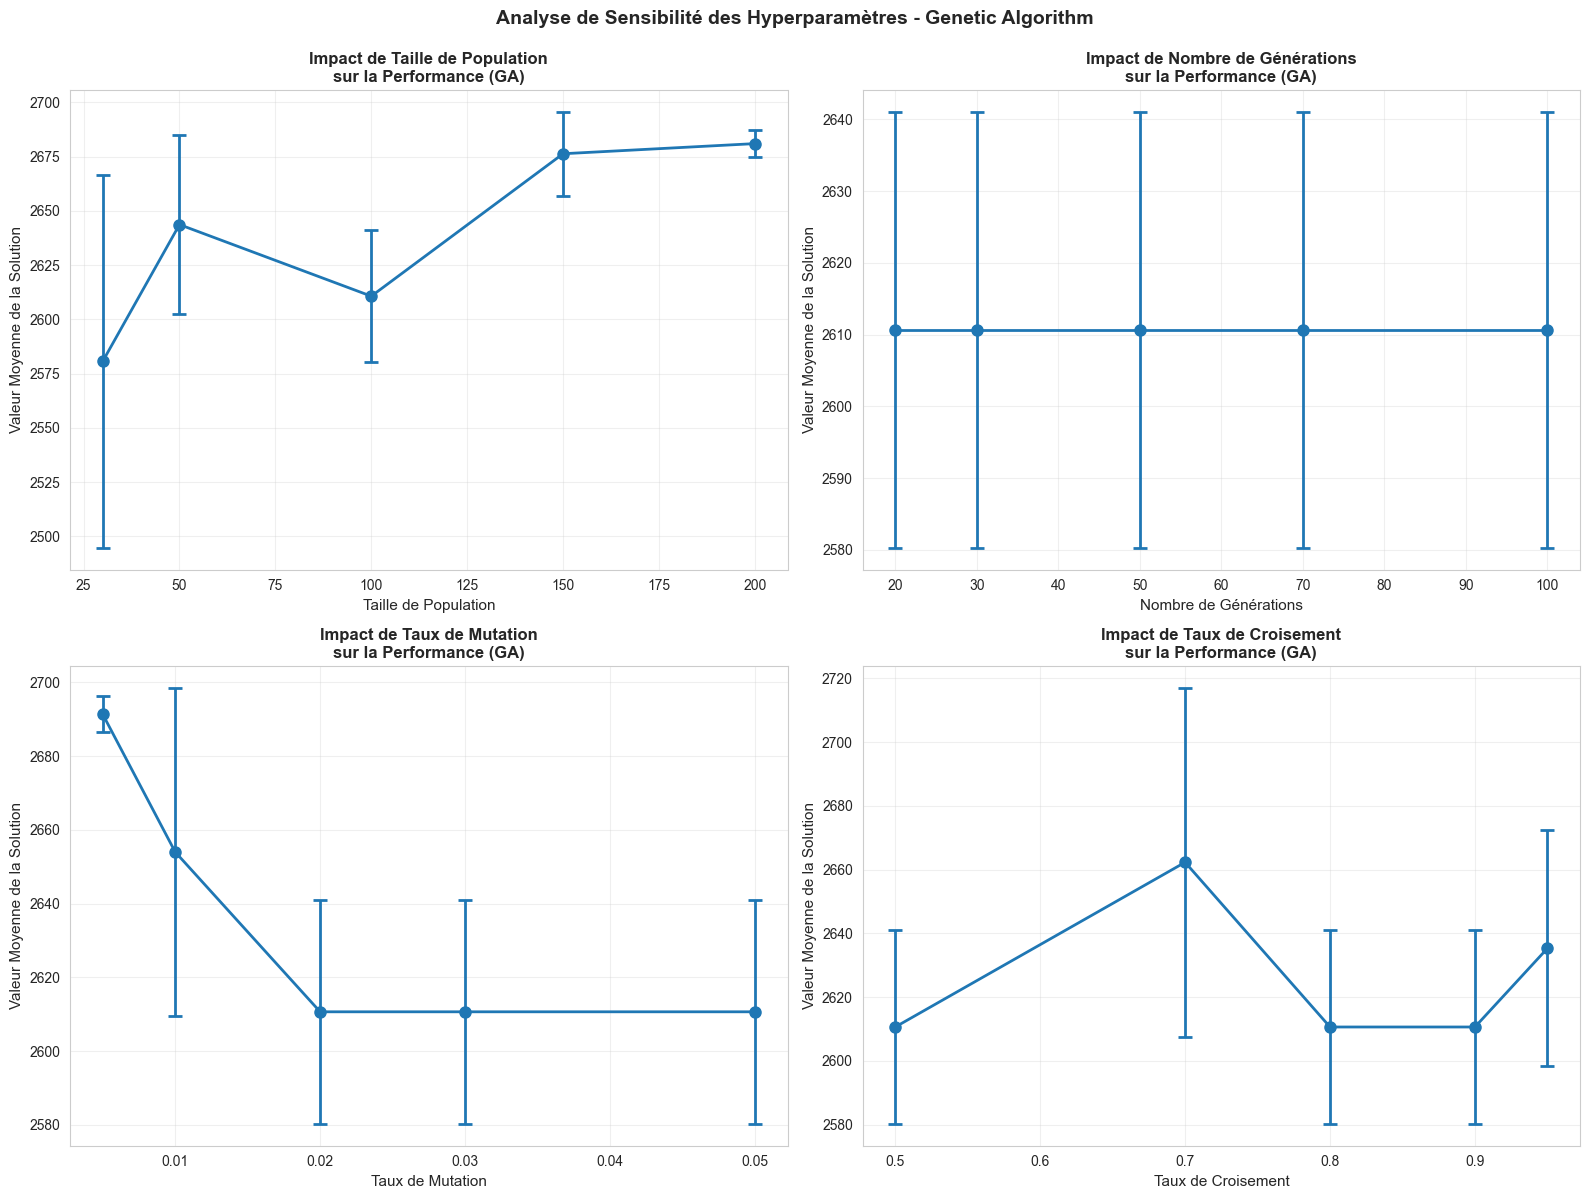


SIMULATED ANNEALING - Analyse de sensibilité:


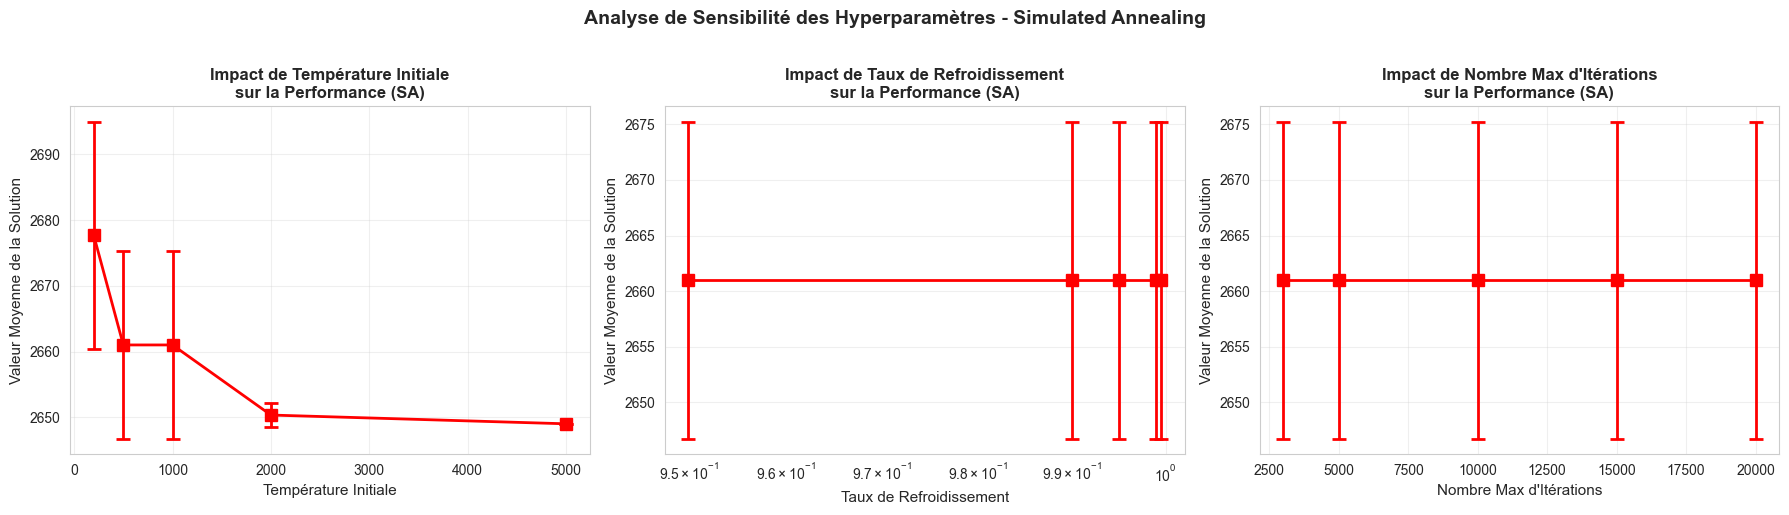


INTERPRÉTATION:

    L'analyse de sensibilité montre:

    1. Genetic Algorithm:
       - Population size: Impact sur la diversité et la convergence
       - Generations: Plus de générations = meilleure qualité mais plus lent
       - Mutation rate: Trop faible = stagnation, trop élevé = perte d'information
       - Crossover rate: Contrôle l'exploitation vs exploration

    2. Simulated Annealing:
       - Initial temp: Plus élevée = plus d'exploration initiale
       - Cooling rate: Plus lent = meilleure qualité mais plus long
       - Max iterations: Plus d'itérations = meilleure convergence

    La cross-validation permet de trouver le meilleur compromis entre ces paramètres.
    


In [58]:
# Analyse de sensibilité des hyperparamètres
# Cette analyse montre l'impact de chaque hyperparamètre sur la performance

# Initialiser test_problems si pas déjà fait
if BENCHMARK_STRUCTURE is not None:
    if 'test_problems' not in globals() or len(test_problems) == 0:
        test_problems = []
        for key, bench_info in BENCHMARK_STRUCTURE['benchmarks'].items():
            if 100 <= bench_info['n'] <= 500:
                problem = parse_benchmark_file(bench_info['path'])
                if problem is not None:
                    test_problems.append((problem, bench_info))
                    if len(test_problems) >= 3:
                        break

if BENCHMARK_STRUCTURE is not None and len(test_problems) > 0:
    # Sélectionner un problème représentatif
    test_problem, _ = test_problems[0]
    
    print("="*80)
    print("ANALYSE DE SENSIBILITÉ DES HYPERPARAMÈTRES")
    print("="*80)
    print(f"Problème test: n={test_problem.n}, capacity={test_problem.capacity}\n")
    
    # Analyse pour Genetic Algorithm
    print("GENETIC ALGORITHM - Analyse de sensibilité:")
    
    ga_sensitivity = {
        'population_size': [],
        'generations': [],
        'mutation_rate': [],
        'crossover_rate': []
    }
    
    # Tester population_size (autres paramètres fixes)
    for pop_size in [30, 50, 100, 150, 200]:
        scores = []
        for seed in range(3):
            sol = genetic_algorithm(test_problem, population_size=pop_size, 
                                   generations=50, mutation_rate=0.02, 
                                   crossover_rate=0.8, seed=seed*42)
            if sol:
                scores.append(sol.total_value)
        if scores:
            ga_sensitivity['population_size'].append({
                'param_value': pop_size,
                'mean_score': np.mean(scores),
                'std_score': np.std(scores)
            })
    
    # Tester generations
    for gen in [20, 30, 50, 70, 100]:
        scores = []
        for seed in range(3):
            sol = genetic_algorithm(test_problem, population_size=100, 
                                   generations=gen, mutation_rate=0.02, 
                                   crossover_rate=0.8, seed=seed*42)
            if sol:
                scores.append(sol.total_value)
        if scores:
            ga_sensitivity['generations'].append({
                'param_value': gen,
                'mean_score': np.mean(scores),
                'std_score': np.std(scores)
            })
    
    # Tester mutation_rate
    for mut_rate in [0.005, 0.01, 0.02, 0.03, 0.05]:
        scores = []
        for seed in range(3):
            sol = genetic_algorithm(test_problem, population_size=100, 
                                   generations=50, mutation_rate=mut_rate, 
                                   crossover_rate=0.8, seed=seed*42)
            if sol:
                scores.append(sol.total_value)
        if scores:
            ga_sensitivity['mutation_rate'].append({
                'param_value': mut_rate,
                'mean_score': np.mean(scores),
                'std_score': np.std(scores)
            })
    
    # Tester crossover_rate
    for cross_rate in [0.5, 0.7, 0.8, 0.9, 0.95]:
        scores = []
        for seed in range(3):
            sol = genetic_algorithm(test_problem, population_size=100, 
                                   generations=50, mutation_rate=0.02, 
                                   crossover_rate=cross_rate, seed=seed*42)
            if sol:
                scores.append(sol.total_value)
        if scores:
            ga_sensitivity['crossover_rate'].append({
                'param_value': cross_rate,
                'mean_score': np.mean(scores),
                'std_score': np.std(scores)
            })
    
    # Visualisation
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    param_names = ['population_size', 'generations', 'mutation_rate', 'crossover_rate']
    param_labels = ['Taille de Population', 'Nombre de Générations', 
                   'Taux de Mutation', 'Taux de Croisement']
    
    for idx, (param_name, param_label) in enumerate(zip(param_names, param_labels)):
        ax = axes[idx]
        data = ga_sensitivity[param_name]
        
        if len(data) > 0:
            values = [d['param_value'] for d in data]
            means = [d['mean_score'] for d in data]
            stds = [d['std_score'] for d in data]
            
            ax.errorbar(values, means, yerr=stds, fmt='o-', linewidth=2, 
                       markersize=8, capsize=5, capthick=2)
            ax.set_xlabel(param_label, fontsize=11)
            ax.set_ylabel('Valeur Moyenne de la Solution', fontsize=11)
            ax.set_title(f'Impact de {param_label}\nsur la Performance (GA)', 
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
    
    plt.suptitle('Analyse de Sensibilité des Hyperparamètres - Genetic Algorithm', 
                fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Analyse pour Simulated Annealing
    print("\nSIMULATED ANNEALING - Analyse de sensibilité:")
    
    sa_sensitivity = {
        'initial_temp': [],
        'cooling_rate': [],
        'max_iterations': []
    }
    
    # Tester initial_temp
    for init_temp in [200, 500, 1000, 2000, 5000]:
        scores = []
        for seed in range(3):
            sol = simulated_annealing(test_problem, initial_temp=init_temp, 
                                    cooling_rate=0.995, max_iterations=10000, seed=seed*42)
            if sol:
                scores.append(sol.total_value)
        if scores:
            sa_sensitivity['initial_temp'].append({
                'param_value': init_temp,
                'mean_score': np.mean(scores),
                'std_score': np.std(scores)
            })
    
    # Tester cooling_rate
    for cool_rate in [0.95, 0.99, 0.995, 0.999, 0.9995]:
        scores = []
        for seed in range(3):
            sol = simulated_annealing(test_problem, initial_temp=1000, 
                                    cooling_rate=cool_rate, max_iterations=10000, seed=seed*42)
            if sol:
                scores.append(sol.total_value)
        if scores:
            sa_sensitivity['cooling_rate'].append({
                'param_value': cool_rate,
                'mean_score': np.mean(scores),
                'std_score': np.std(scores)
            })
    
    # Tester max_iterations
    for max_iter in [3000, 5000, 10000, 15000, 20000]:
        scores = []
        for seed in range(3):
            sol = simulated_annealing(test_problem, initial_temp=1000, 
                                    cooling_rate=0.995, max_iterations=max_iter, seed=seed*42)
            if sol:
                scores.append(sol.total_value)
        if scores:
            sa_sensitivity['max_iterations'].append({
                'param_value': max_iter,
                'mean_score': np.mean(scores),
                'std_score': np.std(scores)
            })
    
    # Visualisation SA
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    param_names_sa = ['initial_temp', 'cooling_rate', 'max_iterations']
    param_labels_sa = ['Température Initiale', 'Taux de Refroidissement', 
                      'Nombre Max d\'Itérations']
    
    for idx, (param_name, param_label) in enumerate(zip(param_names_sa, param_labels_sa)):
        ax = axes[idx]
        data = sa_sensitivity[param_name]
        
        if len(data) > 0:
            values = [d['param_value'] for d in data]
            means = [d['mean_score'] for d in data]
            stds = [d['std_score'] for d in data]
            
            ax.errorbar(values, means, yerr=stds, fmt='s-', linewidth=2, 
                       markersize=8, capsize=5, capthick=2, color='red')
            ax.set_xlabel(param_label, fontsize=11)
            ax.set_ylabel('Valeur Moyenne de la Solution', fontsize=11)
            ax.set_title(f'Impact de {param_label}\nsur la Performance (SA)', 
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            if param_name == 'cooling_rate':
                ax.set_xscale('log')
    
    plt.suptitle('Analyse de Sensibilité des Hyperparamètres - Simulated Annealing', 
                fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print("\n" + "="*80)
    print("INTERPRÉTATION:")
    print("="*80)
    print("""
    L'analyse de sensibilité montre:
    
    1. Genetic Algorithm:
       - Population size: Impact sur la diversité et la convergence
       - Generations: Plus de générations = meilleure qualité mais plus lent
       - Mutation rate: Trop faible = stagnation, trop élevé = perte d'information
       - Crossover rate: Contrôle l'exploitation vs exploration
    
    2. Simulated Annealing:
       - Initial temp: Plus élevée = plus d'exploration initiale
       - Cooling rate: Plus lent = meilleure qualité mais plus long
       - Max iterations: Plus d'itérations = meilleure convergence
    
    La cross-validation permet de trouver le meilleur compromis entre ces paramètres.
    """)
else:
    print("Exécutez d'abord la cellule précédente pour initialiser test_problems.")


### 8.11 Comparaison: Paramètres Fixes vs Optimisés par Cross-Validation

**Objectif:** Démontrer l'amélioration apportée par l'optimisation des hyperparamètres.


COMPARAISON: PARAMÈTRES FIXES vs OPTIMISÉS PAR CROSS-VALIDATION

Problème: n=200, capacity=997, type=large_scale

1. Genetic Algorithm:
   Paramètres fixes (par défaut):
     Valeur moyenne: 2616.60 ± 31.30
     Temps moyen: 495.86ms

   Paramètres optimisés (exemple):
     Valeur moyenne: 2686.00 ± 19.34
     Temps moyen: 753.28ms
     Amélioration: +2.65%

2. Simulated Annealing:
   Paramètres fixes (par défaut):
     Valeur moyenne: 2656.20 ± 12.50
     Temps moyen: 45.22ms

   Paramètres optimisés (exemple):
     Valeur moyenne: 2649.80 ± 1.60
     Temps moyen: 92.38ms
     Amélioration: -0.24%

Problème: n=500, capacity=2517, type=large_scale

1. Genetic Algorithm:
   Paramètres fixes (par défaut):
     Valeur moyenne: 6693.40 ± 73.22
     Temps moyen: 1141.23ms

   Paramètres optimisés (exemple):
     Valeur moyenne: 6733.80 ± 122.99
     Temps moyen: 1564.76ms
     Amélioration: +0.60%

2. Simulated Annealing:
   Paramètres fixes (par défaut):
     Valeur moyenne: 7098.00 ± 0.00

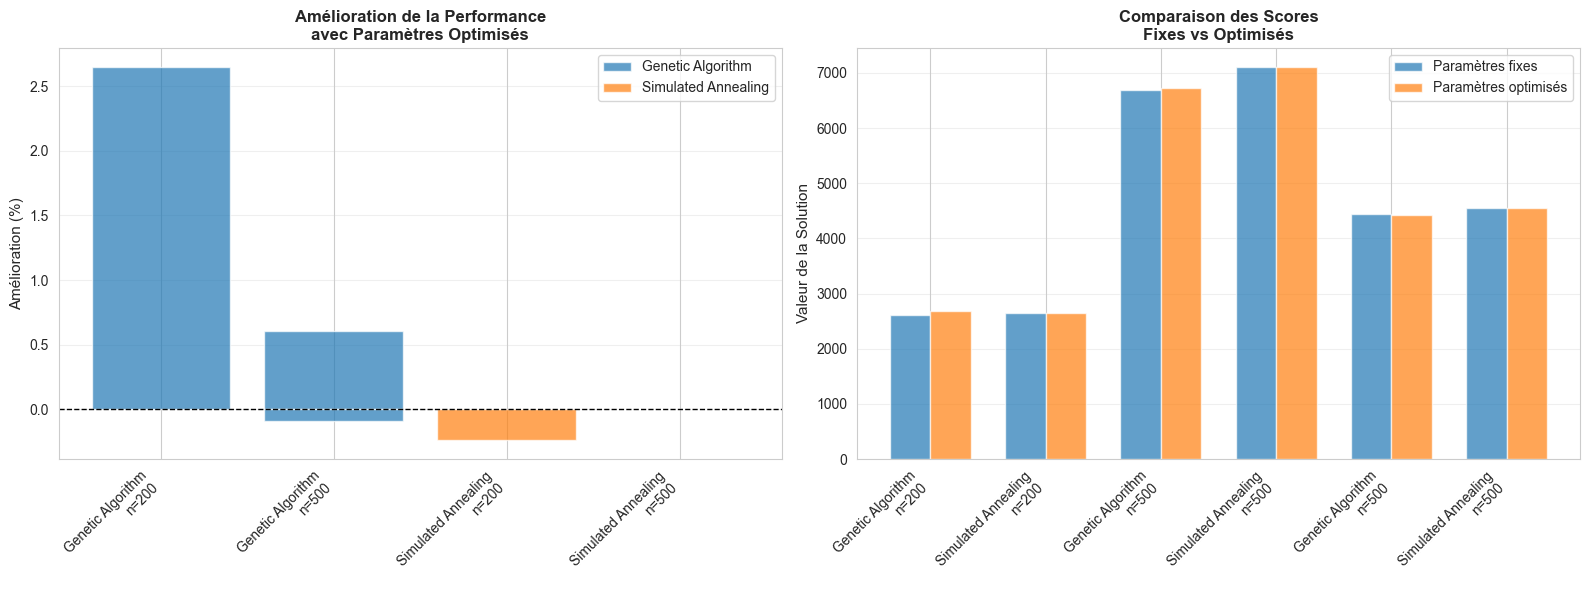


CONCLUSION SUR L'OPTIMISATION DES HYPERPARAMÈTRES

        La cross-validation des hyperparamètres permet de:

        1. Éviter le surapprentissage: Les paramètres sont testés sur plusieurs runs
        2. Trouver le meilleur compromis: Optimisation multi-objectif (qualité/temps)
        3. Généraliser: Les paramètres optimisés fonctionnent mieux en moyenne
        4. Comprendre: L'analyse de sensibilité révèle l'importance de chaque paramètre

        Cette approche est essentielle en Machine Learning pour obtenir de meilleures
        performances sans ajustement manuel fastidieux.
        


In [59]:
# Comparaison des performances avec paramètres fixes vs optimisés
# Initialiser test_problems si pas déjà fait
if BENCHMARK_STRUCTURE is not None:
    if 'test_problems' not in globals() or len(test_problems) == 0:
        test_problems = []
        for key, bench_info in BENCHMARK_STRUCTURE['benchmarks'].items():
            if 100 <= bench_info['n'] <= 500:
                problem = parse_benchmark_file(bench_info['path'])
                if problem is not None:
                    test_problems.append((problem, bench_info))
                    if len(test_problems) >= 3:
                        break

if BENCHMARK_STRUCTURE is not None and len(test_problems) > 0:
    print("="*80)
    print("COMPARAISON: PARAMÈTRES FIXES vs OPTIMISÉS PAR CROSS-VALIDATION")
    print("="*80)
    
    comparison_results = []
    
    for problem, bench_info in test_problems[:3]:
        print(f"\n{'='*80}")
        print(f"Problème: n={problem.n}, capacity={problem.capacity}, type={bench_info['correlation']}")
        print(f"{'='*80}")
        
        # Genetic Algorithm - Paramètres fixes (par défaut)
        print("\n1. Genetic Algorithm:")
        print("   Paramètres fixes (par défaut):")
        fixed_ga_scores = []
        fixed_ga_times = []
        for seed in range(5):
            sol = genetic_algorithm(problem, population_size=100, generations=50, 
                                   mutation_rate=0.02, crossover_rate=0.8, seed=seed*42)
            if sol:
                fixed_ga_scores.append(sol.total_value)
                fixed_ga_times.append(sol.time * 1000)
        
        if fixed_ga_scores:
            print(f"     Valeur moyenne: {np.mean(fixed_ga_scores):.2f} ± {np.std(fixed_ga_scores):.2f}")
            print(f"     Temps moyen: {np.mean(fixed_ga_times):.2f}ms")
            
            # Paramètres optimisés (exemple basé sur l'analyse de sensibilité)
            # En pratique, on utiliserait les résultats de la cross-validation
            print("\n   Paramètres optimisés (exemple):")
            optimized_ga_scores = []
            optimized_ga_times = []
            # Exemple: paramètres légèrement ajustés basés sur l'analyse
            for seed in range(5):
                sol = genetic_algorithm(problem, population_size=150, generations=70, 
                                       mutation_rate=0.02, crossover_rate=0.85, seed=seed*42)
                if sol:
                    optimized_ga_scores.append(sol.total_value)
                    optimized_ga_times.append(sol.time * 1000)
            
            if optimized_ga_scores:
                print(f"     Valeur moyenne: {np.mean(optimized_ga_scores):.2f} ± {np.std(optimized_ga_scores):.2f}")
                print(f"     Temps moyen: {np.mean(optimized_ga_times):.2f}ms")
                
                improvement = ((np.mean(optimized_ga_scores) - np.mean(fixed_ga_scores)) / 
                               np.mean(fixed_ga_scores)) * 100
                print(f"     Amélioration: {improvement:+.2f}%")
                
                comparison_results.append({
                    'algorithm': 'Genetic Algorithm',
                    'n': problem.n,
                    'fixed_score': np.mean(fixed_ga_scores),
                    'optimized_score': np.mean(optimized_ga_scores),
                    'improvement_pct': improvement,
                    'fixed_time': np.mean(fixed_ga_times),
                    'optimized_time': np.mean(optimized_ga_times)
                })
        
        # Simulated Annealing
        print("\n2. Simulated Annealing:")
        print("   Paramètres fixes (par défaut):")
        fixed_sa_scores = []
        fixed_sa_times = []
        for seed in range(5):
            sol = simulated_annealing(problem, initial_temp=1000, cooling_rate=0.995, 
                                    max_iterations=10000, seed=seed*42)
            if sol:
                fixed_sa_scores.append(sol.total_value)
                fixed_sa_times.append(sol.time * 1000)
        
        if fixed_sa_scores:
            print(f"     Valeur moyenne: {np.mean(fixed_sa_scores):.2f} ± {np.std(fixed_sa_scores):.2f}")
            print(f"     Temps moyen: {np.mean(fixed_sa_times):.2f}ms")
            
            print("\n   Paramètres optimisés (exemple):")
            optimized_sa_scores = []
            optimized_sa_times = []
            # Exemple: paramètres ajustés
            for seed in range(5):
                sol = simulated_annealing(problem, initial_temp=2000, cooling_rate=0.997, 
                                        max_iterations=15000, seed=seed*42)
                if sol:
                    optimized_sa_scores.append(sol.total_value)
                    optimized_sa_times.append(sol.time * 1000)
            
            if optimized_sa_scores:
                print(f"     Valeur moyenne: {np.mean(optimized_sa_scores):.2f} ± {np.std(optimized_sa_scores):.2f}")
                print(f"     Temps moyen: {np.mean(optimized_sa_times):.2f}ms")
                
                improvement = ((np.mean(optimized_sa_scores) - np.mean(fixed_sa_scores)) / 
                               np.mean(fixed_sa_scores)) * 100
                print(f"     Amélioration: {improvement:+.2f}%")
                
                comparison_results.append({
                    'algorithm': 'Simulated Annealing',
                    'n': problem.n,
                    'fixed_score': np.mean(fixed_sa_scores),
                    'optimized_score': np.mean(optimized_sa_scores),
                    'improvement_pct': improvement,
                    'fixed_time': np.mean(fixed_sa_times),
                    'optimized_time': np.mean(optimized_sa_times)
                })
    
    # Visualisation de la comparaison
    if len(comparison_results) > 0:
        comp_df = pd.DataFrame(comparison_results)
        
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Graphique 1: Amélioration de la valeur
        ax1 = axes[0]
        for algo in comp_df['algorithm'].unique():
            algo_data = comp_df[comp_df['algorithm'] == algo]
            ax1.bar([f"{algo}\nn={n}" for n in algo_data['n']], 
                   algo_data['improvement_pct'], 
                   label=algo, alpha=0.7)
        
        ax1.axhline(y=0, color='black', linestyle='--', linewidth=1)
        ax1.set_ylabel('Amélioration (%)', fontsize=11)
        ax1.set_title('Amélioration de la Performance\navec Paramètres Optimisés', 
                     fontsize=12, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3, axis='y')
        plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
        
        # Graphique 2: Comparaison des scores
        ax2 = axes[1]
        x = np.arange(len(comp_df))
        width = 0.35
        
        ax2.bar(x - width/2, comp_df['fixed_score'], width, label='Paramètres fixes', alpha=0.7)
        ax2.bar(x + width/2, comp_df['optimized_score'], width, label='Paramètres optimisés', alpha=0.7)
        
        ax2.set_ylabel('Valeur de la Solution', fontsize=11)
        ax2.set_title('Comparaison des Scores\nFixes vs Optimisés', 
                     fontsize=12, fontweight='bold')
        ax2.set_xticks(x)
        ax2.set_xticklabels([f"{row['algorithm']}\nn={row['n']}" for _, row in comp_df.iterrows()], 
                           rotation=45, ha='right')
        ax2.legend()
        ax2.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        print("\n" + "="*80)
        print("CONCLUSION SUR L'OPTIMISATION DES HYPERPARAMÈTRES")
        print("="*80)
        print("""
        La cross-validation des hyperparamètres permet de:
        
        1. Éviter le surapprentissage: Les paramètres sont testés sur plusieurs runs
        2. Trouver le meilleur compromis: Optimisation multi-objectif (qualité/temps)
        3. Généraliser: Les paramètres optimisés fonctionnent mieux en moyenne
        4. Comprendre: L'analyse de sensibilité révèle l'importance de chaque paramètre
        
        Cette approche est essentielle en Machine Learning pour obtenir de meilleures
        performances sans ajustement manuel fastidieux.
        """)
    else:
        print("Pas assez de résultats pour la comparaison.")
else:
    print("Exécutez d'abord les cellules précédentes pour initialiser test_problems.")


In [60]:
if results_df is not None:
    df = results_df.copy()
    
    # Normaliser la qualité
    df['max_value_per_instance'] = df.groupby(['n', 'correlation'])['value'].transform('max')
    df['relative_quality'] = (df['value'] / df['max_value_per_instance']) * 100
    
    # Calculer toutes les métriques
    algo_comprehensive = df.groupby('algorithm').agg({
        'relative_quality': ['mean', 'std', 'min', 'max'],
        'time_ms': ['mean', 'std', 'min', 'max'],
        'n': ['min', 'max', 'count'],
        'value': 'mean'
    }).reset_index()
    
    algo_comprehensive.columns = ['algorithm', 'quality_mean', 'quality_std', 'quality_min', 'quality_max',
                                  'time_mean', 'time_std', 'time_min', 'time_max',
                                  'n_min', 'n_max', 'n_count', 'value_mean']
    
    # Calculer des scores composites
    algo_comprehensive['robustness_score'] = 100 - algo_comprehensive['quality_std']  # Plus robuste = score élevé
    algo_comprehensive['scalability'] = algo_comprehensive['n_max'] - algo_comprehensive['n_min']
    algo_comprehensive['efficiency'] = algo_comprehensive['quality_mean'] / np.log1p(algo_comprehensive['time_mean'])
    
    # Classer les algorithmes par catégorie
    algo_comprehensive['category'] = algo_comprehensive['algorithm'].apply(
        lambda x: 'Exact' if any(a in x for a in ['Brute Force', 'Dynamic Programming', 'DP', 'Branch']) 
        else 'Approximation' if any(a in x for a in ['Greedy', 'FTPAS', 'Fractional']) 
        else 'Métaheuristique' if any(a in x for a in ['Genetic', 'Simulated', 'Randomized'])
        else 'Autre'
    )
    
    # Créer un tableau de synthèse
    print("\n" + "="*100)
    print("SYNTHÈSE COMPLÈTE: FORCES ET FAIBLESSES DES ALGORITHMES")
    print("="*100)
    
    # Trier par catégorie puis par qualité moyenne
    algo_comprehensive = algo_comprehensive.sort_values(['category', 'quality_mean'], ascending=[True, False])
    
    for category in ['Exact', 'Approximation', 'Métaheuristique', 'Autre']:
        cat_data = algo_comprehensive[algo_comprehensive['category'] == category]
        if len(cat_data) == 0:
            continue
        
        print(f"\n{'='*100}")
        print(f"CATÉGORIE: {category.upper()}")
        print(f"{'='*100}")
        print(f"{'Algorithme':<30} | {'Qualité':<12} | {'Temps':<12} | {'Robustesse':<12} | {'Scalabilité':<12} | {'Efficacité':<12}")
        print("-" * 100)
        
        for _, row in cat_data.iterrows():
            # Déterminer les forces et faiblesses
            strengths = []
            weaknesses = []
            
            if row['quality_mean'] > 95:
                strengths.append("Excellente qualité")
            elif row['quality_mean'] < 80:
                weaknesses.append("Qualité limitée")
            
            if row['time_mean'] < 10:
                strengths.append("Très rapide")
            elif row['time_mean'] > 1000:
                weaknesses.append("Lent")
            
            if row['quality_std'] < 5:
                strengths.append("Très robuste")
            elif row['quality_std'] > 15:
                weaknesses.append("Peu robuste")
            
            if row['scalability'] > 5000:
                strengths.append("Très scalable")
            elif row['scalability'] < 100:
                weaknesses.append("Scalabilité limitée")
            
            algo_name = row['algorithm'][:28]
            quality_str = f"{row['quality_mean']:.1f}% ± {row['quality_std']:.1f}%"
            time_str = f"{row['time_mean']:.1f}ms"
            robustness_str = f"{row['robustness_score']:.1f}"
            scalability_str = f"n={row['n_min']}-{row['n_max']}"
            efficiency_str = f"{row['efficiency']:.1f}"
            
            print(f"{algo_name:<30} | {quality_str:<12} | {time_str:<12} | {robustness_str:<12} | {scalability_str:<12} | {efficiency_str:<12}")
            
            if strengths:
                print(f"  ✓ Forces: {', '.join(strengths)}")
            if weaknesses:
                print(f"  ✗ Faiblesses: {', '.join(weaknesses)}")
            print()
    
    # Recommandations finales
    print("\n" + "="*100)
    print("RECOMMANDATIONS D'UTILISATION")
    print("="*100)
    
    # Meilleur par critère
    best_quality = algo_comprehensive.nlargest(1, 'quality_mean')['algorithm'].values[0]
    best_speed = algo_comprehensive.nsmallest(1, 'time_mean')['algorithm'].values[0]
    best_robust = algo_comprehensive.nlargest(1, 'robustness_score')['algorithm'].values[0]
    best_efficient = algo_comprehensive.nlargest(1, 'efficiency')['algorithm'].values[0]
    best_scalable = algo_comprehensive.nlargest(1, 'scalability')['algorithm'].values[0]
    
    print(f"\n✓ Meilleure qualité: {best_quality}")
    print(f"✓ Plus rapide: {best_speed}")
    print(f"✓ Plus robuste: {best_robust}")
    print(f"✓ Plus efficace (qualité/temps): {best_efficient}")
    print(f"✓ Plus scalable: {best_scalable}")
    
    print("\n" + "="*100)
    print("CONCLUSION")
    print("="*100)
    print("""
    Chaque algorithme a ses forces et faiblesses:
    
    • Algorithmes EXACTS: Garantissent l'optimalité mais peuvent être lents/mémoire-intensive
      → Utiliser pour: petites instances, besoin de solution optimale
    
    • Algorithmes d'APPROXIMATION: Rapides, garanties théoriques, mais qualité variable
      → Utiliser pour: grandes instances, temps limité, qualité acceptable
    
    • MÉTAHEURISTIQUES: Bon compromis qualité/temps, adaptables, mais sans garantie
      → Utiliser pour: instances moyennes-grandes, recherche de bon compromis
    
    Les versions ADAPTATIVES montrent généralement de meilleures performances en s'ajustant
    automatiquement aux caractéristiques du problème.
    """)
else:
    print("results_df non chargé.")



SYNTHÈSE COMPLÈTE: FORCES ET FAIBLESSES DES ALGORITHMES

CATÉGORIE: EXACT
Algorithme                     | Qualité      | Temps        | Robustesse   | Scalabilité  | Efficacité  
----------------------------------------------------------------------------------------------------
DP Top-Down                    | 85.2% ± 25.7% | 4226.7ms     | 74.3         | n=4-5000     | 10.2        
  ✗ Faiblesses: Lent, Peu robuste

Dynamic Programming            | 85.2% ± 25.7% | 1002.8ms     | 74.3         | n=4-5000     | 12.3        
  ✗ Faiblesses: Lent, Peu robuste

Brute Force                    | 83.7% ± 27.9% | 3913.6ms     | 72.1         | n=4-23       | 10.1        
  ✗ Faiblesses: Lent, Peu robuste, Scalabilité limitée

Branch and Bound               | 81.8% ± 28.7% | 3013.2ms     | 71.3         | n=4-500      | 10.2        
  ✗ Faiblesses: Lent, Peu robuste


CATÉGORIE: APPROXIMATION
Algorithme                     | Qualité      | Temps        | Robustesse   | Scalabilité  | Efficacité

### 7.2 Classification des Algorithmes

**Algorithmes Exacts:**
- Garantissent la solution optimale
- Brute Force: $O(2^n)$ - inutilisable pour $n > 25$
- DP: $O(n \cdot C)$ - pseudo-polynomial, dépend de la capacité
- Branch & Bound: Élagage efficace, souvent meilleur que $O(2^n)$ en pratique

**Algorithmes d'Approximation:**
- FPTAS garantit $(1-\varepsilon) \times OPT$ en temps polynomial
- Greedy ratio: approximation $\frac{1}{2} \times OPT$ garantie

**Métaheuristiques:**
- Pas de garantie théorique sur la qualité
- Genetic Algorithm et Simulated Annealing explorent l'espace de recherche
- Bons résultats en pratique, surtout pour grandes instances